# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

import numpy as np

In [2]:
df = pd.read_spss('../data/CCAM SPSS Data 2008-2018.sav')
df.to_csv('../data/CCAM SPSS Data 2008-2018.csv', index=False)
df = pd.read_csv('../data/CCAM SPSS Data 2008-2018.csv')

In [3]:
geo = pd.read_csv('../data/YCOM6.0_2021_Data_.csv', encoding='latin-1')

In [4]:
df.drop('case_ID', axis=1, inplace=True)

## Review Target Column

In [5]:
df.happening.value_counts(normalize=True)

Yes           0.665373
Don't know    0.170325
No            0.161135
Refused       0.003167
Name: happening, dtype: float64

In [6]:
# drop Refused
df = df[df.happening != "Refused"]

In [7]:
df.happening.value_counts(normalize=True)

Yes           0.667487
Don't know    0.170866
No            0.161647
Name: happening, dtype: float64

# Initial Inspection 

In [8]:
def columns_info(df):
    columns_df = pd.DataFrame({'nulls': [df[col].isna().sum() for col in df.keys()], 
                         'dtype': [df[col].dtype for col in df.keys()], 
                         'nunique_values': [df[col].nunique() for col in df.keys()], 
                         'unique_values': [df[col].unique()for col in df.keys()], 
                         'value_counts': [df[col].value_counts() for col in df.keys()]}, 
                         index=[col for col in df.keys()])
    return columns_df

# Function to Inspect Column
def col_info(col):
    return pd.DataFrame({'nulls': df[col].isna().sum(), 
                         'dtype': df[col].dtype,
                         'nunique': df[col].nunique(), 
                         'unique_values': [df[col].unique()], 
                         'value_counts': [df[col].value_counts()]}, 
                         index=[col])

In [9]:
columns_info(df)

nulls    dtype  nunique_values  \
wave                             0   object              19   
year                             0    int64              10   
weight_wave                      0  float64            8225   
weight_aggregate                 0  float64           11637   
happening                        0   object               3   
cause_original                   0   object               5   
cause_other_text             20358   object            1389   
cause_recoded                    0   object               7   
sci_consensus                 1330   object               5   
worry                            0   object               5   
harm_personally                  0   object               6   
harm_US                          0   object               6   
harm_dev_countries               0   object               6   
harm_future_gen                  0   object               6   
harm_plants_animals           1330   object               6   
when_harm_US                     0   object               7   
reg_CO2_pollutant              998   object               5   
reg_utilities                 5026   object               5   
fund_research                    0   object               5   
reg_coal_emissions            9034   object               5   
discuss_GW                       0   object               5   
hear_GW_media                13587   object               7   
gender                           0   object               2   
age                              0  float64              78   
age_category                     0   object               3   
generation                       0   object               6   
educ                             0   object              14   
educ_category                    0   object               4   
income                           0   object              21   
income_category                  0   object               3   
race                             0   object               4   
ideology                         0   object               6   
party                            0   object               6   
party_w_leaners                  0   object               5   
party_x_ideo                     0   object               7   
registered_voter                 0   object               6   
region9                          0   object               9   
region4                          0   object               4   
religion                         0   object              16   
religion_other_nonchristian  22253   object              65   
evangelical                      0   object               4   
service_attendance               0   object               7   
marit_status                     0   object               6   
employment                       0   object               7   
house_head                       0   object               2   
house_size                       0  float64              13   
house_ages0to1                   0  float64               7   
house_ages2to5                   0  float64               5   
house_ages6to12                  0  float64               7   
house_ages13to17                 0  float64               5   
house_ages18plus                 0  float64              11   
house_type                       0   object               5   
house_own                        0   object               3   

                                                                 unique_values  \
wave                         [Nov 2008, Jan 2010, Jun 2010, May 2011, Nov 2...   
year                         [2008, 2010, 2011, 2012, 2013, 2014, 2015, 201...   
weight_wave                  [0.5400000000000001, 0.85, 0.49, 0.29, 1.29, 2...   
weight_aggregate             [0.2944021792003114, 0.4634108376301197, 0.267...   
happening                                                [Yes, Don't know, No]   
cause_original               [Caused mostly by human activities, Caused mos...   
cause_other_text             [nan, both of the above

---
---

# Eploratory Data Analysis

### Happening

In [10]:
df.happening.value_counts().to_frame()

happening
Yes             14915
Don't know       3818
No               3612

### `happening` (target)

''

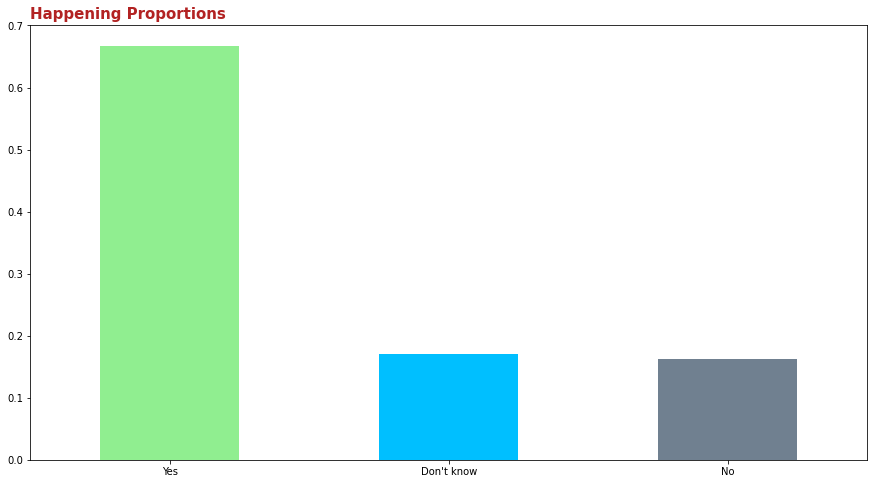

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))

df.happening.value_counts(normalize=True).plot(kind='bar', 
                                               color=['lightgreen', 
                                                      'deepskyblue', 
                                                      'slategrey'])

ax.set_title('happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')

plt.xticks(rotation = 0)

ax.set_title('Happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')
;

### Wave

In [12]:
df.wave = [' '.join(wave.split(' ')[::-1]) for wave in df.wave]

In [13]:
df.wave.value_counts().sort_index().to_frame()

wave
2008 Nov  2155
2010 Jan   994
2010 Jun  1021
2011 May   998
2011 Nov   980
2012 Mar   999
2012 Sep  1061
2013 Apr  1041
2013 Nov   826
2014 Apr  1012
2014 Oct  1274
2015 Mar  1263
2015 Oct  1330
2016 Mar  1204
2016 Nov  1226
2017 May  1266
2017 Oct  1304
2018 Dec  1113
2018 Mar  1278

In [14]:
df.wave.value_counts().sort_index()[1:].values.mean()

1121.6666666666667

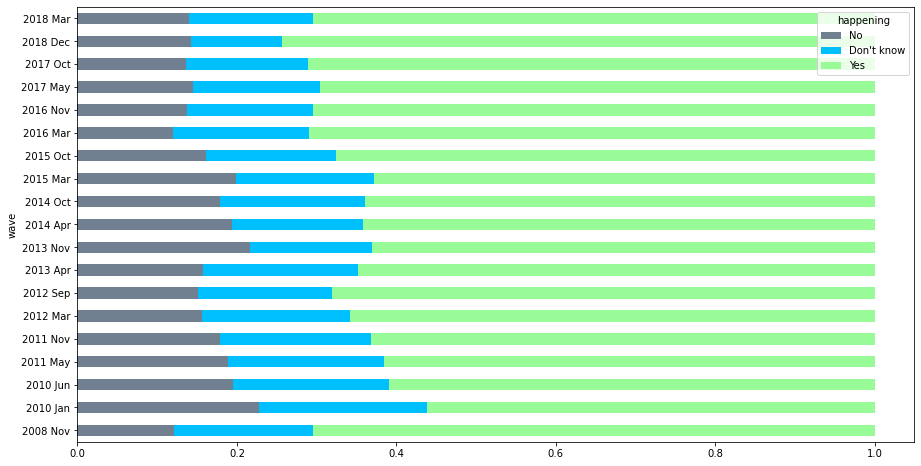

In [15]:
df.groupby('wave')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh',
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen']);

**Wave**

Observation
- The first poll had the largest number of responses. 
- Each poll afterwards had 1125 responses on average. 
- It seems like the number of people in each poll was divided in half after the first year. 

### Year

**Proportion of Believe in Climate Change over 2008 - 2018**

''

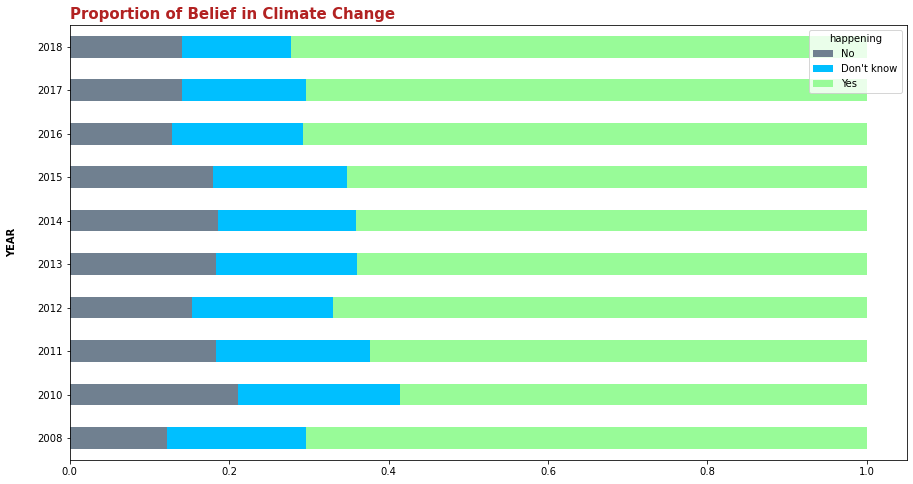

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

df.groupby('year')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh', 
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen'], 
          ax=ax)

ax.set_title('Proportion of Belief in Climate Change', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left')
ax.set_ylabel('YEAR', weight='bold', labelpad=20)

;

In [17]:
df.year.value_counts().to_frame()

year
2015  2593
2017  2570
2016  2430
2018  2391
2014  2286
2008  2155
2012  2060
2010  2015
2011  1978
2013  1867

In [18]:
df.groupby('year')['happening'].value_counts(normalize=True).to_frame().unstack()

happening                    
happening Don't know        No       Yes
year                                    
2008        0.174478  0.121578  0.703944
2010        0.202978  0.211414  0.585608
2011        0.193124  0.183519  0.623357
2012        0.176699  0.153398  0.669903
2013        0.176219  0.183717  0.640064
2014        0.174103  0.185477  0.640420
2015        0.167759  0.179715  0.652526
2016        0.164198  0.128807  0.706996
2017        0.156031  0.140467  0.703502
2018        0.135926  0.141363  0.722710

**Proportion of Believe in Climate Change over 2008 - 2018**

Observation
- 

### Weight Wave

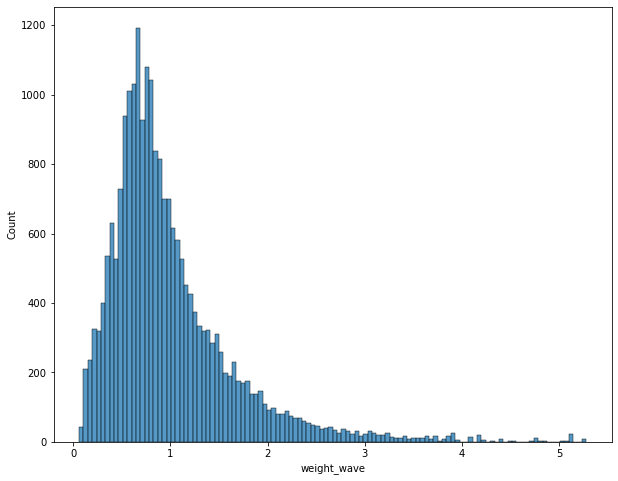

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df, x='weight_wave', ax=ax);

In [20]:
df.weight_wave.describe()

count    22345.000000
mean         0.999569
std          0.660354
min          0.060000
25%          0.586600
50%          0.825000
75%          1.221500
max          5.280000
Name: weight_wave, dtype: float64

In [21]:
df.groupby('year')['weight_wave'].value_counts().to_frame()

weight_wave
year weight_wave             
2008 0.5500                30
     0.5400                29
     0.5800                29
     0.6100                28
     0.6600                28
...                       ...
2018 3.2767                 1
     3.2917                 1
     3.4013                 1
     3.6874                 1
     3.7050                 1

[11069 rows x 1 columns]

**weight_wave**

Observation
- Not sure how they calculated the sampling weight for different waves of polling 
- I don't see how this feature would be useful in modeling or analyzing relationships between features and target

### Cause Original
Assuming global warming is happening do you think it is...

In [22]:
x = df.groupby('happening')['cause_original'].value_counts().to_frame().unstack().T
x['num_per_row'] = x.sum(axis=1).values
x

happening                                                          Don't know  \
               cause_original                                                   
cause_original Caused mostly by human activities                         1119   
               Caused mostly by natural changes in the environ...        1874   
               None of the above because global warming isn't ...         359   
               Other (Please specify)                                     436   
               Refused                                                     30   

happening                                                            No  \
               cause_original                                             
cause_original Caused mostly by human activities                    342   
               Caused mostly by natural changes in the environ...  1854   
               None of the above because global warming isn't ...  1105   
               Other (Please specify)                               303   
               Refused                                                8   

happening                                                            Yes  \
               cause_original                                              
cause_original Caused mostly by human activities                   10068   
               Caused mostly by natural changes in the environ...   3421   
               None of the above because global warming isn't ...     30   
               Other (Please specify)                               1384   
               Refused                                                12   

happening                                                          num_per_row  
               cause_original                                                   
cause_original Caused mostly by human activities                         11529  
               Caused mostly by natural changes in the environ...         7149  
               None of the above because global warming isn't ...         1494  
               Other (Please specify)                                     2123  
               Refused                                                      50

''

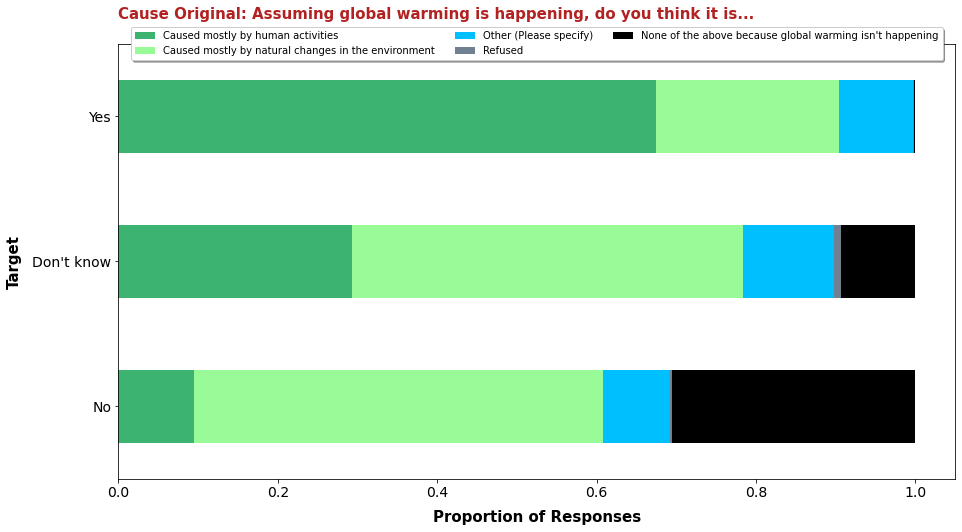

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_original'].value_counts(normalize=True)\
.unstack().loc[['No', "Don't know", 'Yes']].T\
          .loc[['Caused mostly by human activities',
               'Caused mostly by natural changes in the environment',
               'Other (Please specify)',
               'Refused',
               "None of the above because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            fontsize=14,
                                            color=['mediumseagreen', 
                                                   'palegreen',
                                                   'deepskyblue', 
                                                   'slategrey',
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Original: Assuming global warming is happening, do you think it is...', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Proportion of Responses', weight='bold', fontsize=15, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Original**

Observation 
- 95 people refused to answer this question 
- For each `happening` subgroup, some people "None of the above because global warming isn't happening." 30 people who said "Yes" to `happening` selected this response for this question 
- For the 'No' subgroup of `happening`, 2,960 people selected either of the two choices that state what the cause of global warming is. This is a contradiction. 
- Drop "Refused" when ordinal encoding feature
    1. "None of the above because global warming isn't happening"
    2. "Other (Please specify)"
    3. "Caused mostly by natural changes in the environment"
    4. "Caused mostly by human activities"

In [24]:
# df.drop(columns=['cause_original'], axis=1, inplace=True)

### Cause Other Text

[Other - Specify] Assuming global warming is happening, do you think it is...

- This feature had empty strings that I converted to np.nan
- Were these questions only answered if cause_original responses was "Other"

In [25]:
# Number of "Other (Please specify)" in cause_original
df[df.cause_original == 'Other (Please specify)']['cause_original'].count()

2123

In [26]:
# People who answer 'other' in 1st question, but didn't specify here as directed
df.cause_other_text.fillna('', inplace=True)

df[(df.cause_original == 'Other (Please specify)') & 
   (df.cause_other_text == '')]['cause_other_text'].count()

136

In [27]:
# Responses to cause_original for people who didn't answer this question 
df[df.cause_other_text == '']['cause_original'].value_counts().to_frame()

cause_original
Caused mostly by human activities                            11529
Caused mostly by natural changes in the environ...            7149
None of the above because global warming isn't ...            1494
Other (Please specify)                                         136
Refused                                                         50

In [28]:
df.cause_other_text.value_counts(dropna=False)

                                                           20358
both                                                         116
Both                                                          60
both of the above                                             29
combination of both                                           23
                                                           ...  
combo of natural and human                                     1
I'm not sure                                                   1
natural changes somewhat influenced by human activities        1
caused by both human and enviroment                            1
it is caused by both                                           1
Name: cause_other_text, Length: 1390, dtype: int64

In [29]:
# How many people did answer this question 
df[df.cause_other_text != '']['happening'].count()

1987

In [30]:
df.cause_other_text.nunique()

1390

**Cause Other Text**

- there are a 2126 unique answers. Many of them mean the same thing and could be grouped. It could be interesting to investigate further and get more ideas about the data.  
    - lots of people said it was both, meaning both human activity and natural causes 
    - lots of people reference God
    - lot of people said they don't know 
- 1991 people responded to this question
- 135 people who answered "Other" for `cause_original` did not specify here as instructed
- Because only 9% of people answered this question, and it overlaps with `cause_original`, this feature is unlikely to be useful

In [31]:
df.drop(columns=['cause_other_text'], axis=1, inplace=True)

### Cause Recorded

Assuming global warming is happening, do you think it is... (Recoded to include open-ends)

- it seems this feature was created from combining both `cause_original` and `cause_original_text`

In [32]:
# df.cause_recoded.value_counts().to_frame()

x = df.groupby('happening')['cause_recoded'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)
x.astype(dtype=int, errors='ignore')

C:\Users\Larry\AppData\Local\Temp/ipykernel_3544/2947318618.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      cause_recoded  Don't know  \
0             Caused by human activities and natural changes         227   
1                          Caused mostly by human activities        1127   
2          Caused mostly by natural changes in the enviro...        1931   
3                                                 Don't know          71   
4             Neither because global warming isn't happening         363   
5                                     Other (Please specify)          69   
6                                                    Refused          30   
(sum)                                                      0        3818   

happening    No    Yes  (sum)  
0            46   1093   1366  
1           347  10142  11616  
2          1999   3498   7428  
3             5     46    122  
4          1118     30   1511  
5            89     94    252  
6             8     12     50  
(sum)      3612  14915  22345

''

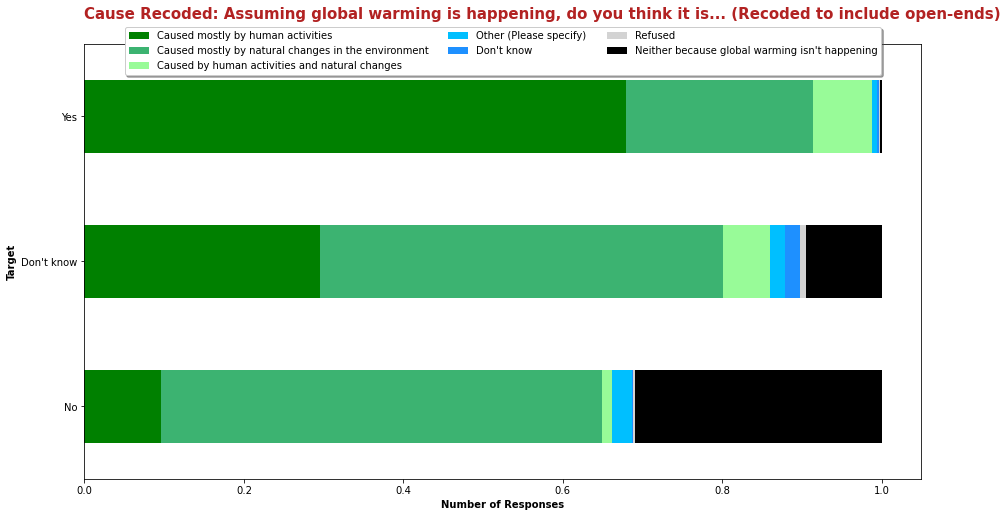

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_recoded'].value_counts(normalize=True).unstack()\
.loc[['No', "Don't know", 'Yes']].T\
.loc[['Caused mostly by human activities', 
      'Caused mostly by natural changes in the environment', 
      'Caused by human activities and natural changes', 
      'Other (Please specify)', 
      "Don't know", 
      'Refused', 
      "Neither because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True, 
                                            color=['g', 
                                                   'mediumseagreen', 
                                                   'palegreen', 
                                                   'deepskyblue',
                                                   'dodgerblue', 
                                                   'lightgrey', 
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Recoded: Assuming global warming is happening, do you think it is... (Recoded to include open-ends)', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold')
ax.set_xlabel('Number of Responses', weight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Recoded**

Observation 
- "Don't Know" and "Caused by human activities and natural changes" were added. 
- "Refused" had no change between `cause_original` and `cause_original_text`
- Differences in answers from `cause_original` = "Other (Please specify) and `cause_recoded`
    - 17 people answered "Neither because global warming isn't happening" here
    - 1647 people answered either the 1st 2 questions meaning they believe in Global Warming 
    - 252 people still responded "Other (Please specify)" 

### SCI Concensus 

Scientist Consensus: Which comes closest to your own view?
- Not asked in Oct 2015

In [34]:
# Number of Nulls in sci_consensus from "2016 Oct"
df.sci_consensus.isnull().sum()

1330

In [35]:
x = df.groupby('happening')['sci_consensus'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

C:\Users\Larry\AppData\Local\Temp/ipykernel_3544/2592813390.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      sci_consensus  Don't know  \
0                                                          0         216   
1                                   Don't know enough to say        1485   
2          Most scientists think global warming is happening         440   
3          Most scientists think global warming is not ha...          58   
4                                                    Refused          15   
5          There is a lot of disagreement among scientist...        1604   
(sum)                                                      0        3818   

happening    No    Yes  (sum)  
0           215    899   1330  
1           392   1711   3588  
2           230   8715   9385  
3           515    134    707  
4            11     19     45  
5          2249   3437   7290  
(sum)      3612  14915  22345

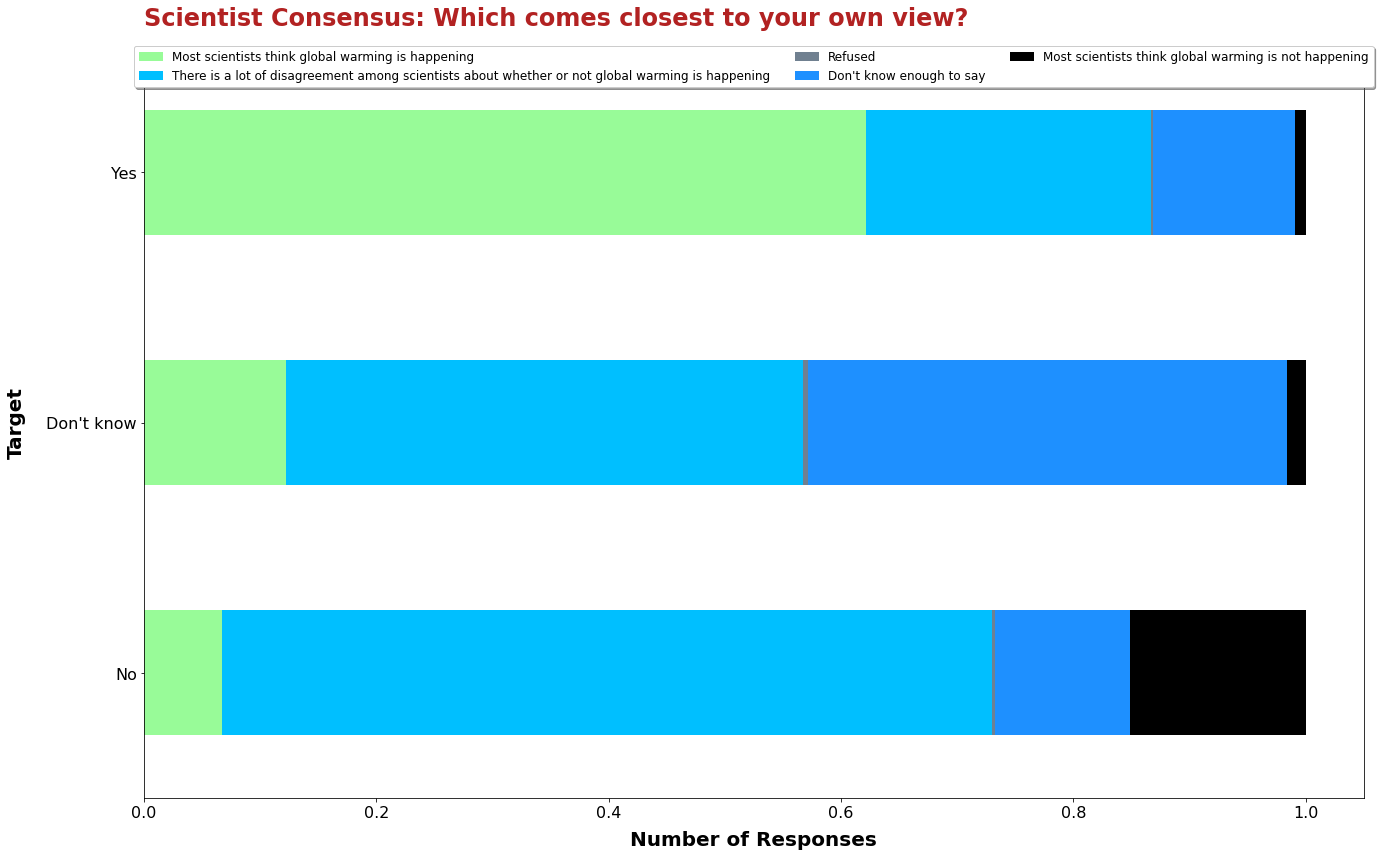

In [36]:
fig, ax = plt.subplots(figsize=(20, 12))

df.groupby('happening')['sci_consensus'].value_counts(normalize=True).unstack().loc[['No', "Don't know", 'Yes']].T\
.loc[['Most scientists think global warming is happening', 
      'There is a lot of disagreement among scientists about whether or not global warming is happening', 
      'Refused',
      "Don't know enough to say", 
      'Most scientists think global warming is not happening']].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            color=['palegreen', 
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'dodgerblue',
                                                   'black'], 
                                           label=('1', '2'), 
                                           fontsize=16)
ax.set_title('Scientist Consensus: Which comes closest to your own view?', 
             fontsize=24, fontweight='bold', color='firebrick', loc='left', pad=22)
ax.set_ylabel('Target', weight='bold', fontsize=20, labelpad=20)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=20, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [37]:
df.groupby('happening')['sci_consensus'].value_counts().to_frame()

sci_consensus
happening  sci_consensus                                                    
Don't know There is a lot of disagreement among scientists...           1604
           Don't know enough to say                                     1485
           Most scientists think global warming is happening             440
           Most scientists think global warming is not hap...             58
           Refused                                                        15
No         There is a lot of disagreement among scientists...           2249
           Most scientists think global warming is not hap...            515
           Don't know enough to say                                      392
           Most scientists think global warming is happening             230
           Refused                                                        11
Yes        Most scientists think global warming is happening            8715
           There is a lot of disagreement among scientists...           3437
           Don't know enough to say                                     1711
           Most scientists think global warming is not hap...            134
           Refused                                                        19

**Science Consensus**

Observation 
- 90 people Refused to answer this question 
- This question is the least likely to leak data into the model
- 1330 Nulls for this feature from 2015 Oct
    - possible to impute with KNNImputer

### Worry

How worried are you about global warming?

In [38]:
x = df.groupby('happening')['worry'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

C:\Users\Larry\AppData\Local\Temp/ipykernel_3544/2187703950.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening               worry  Don't know    No    Yes  (sum)
0          Not at all worried         845  2207    789   3841
1            Not very worried        1847  1221   2930   5998
2                     Refused          17     7     18     42
3            Somewhat worried        1050   162   7822   9034
4                Very worried          59    15   3356   3430
(sum)                       0        3818  3612  14915  22345

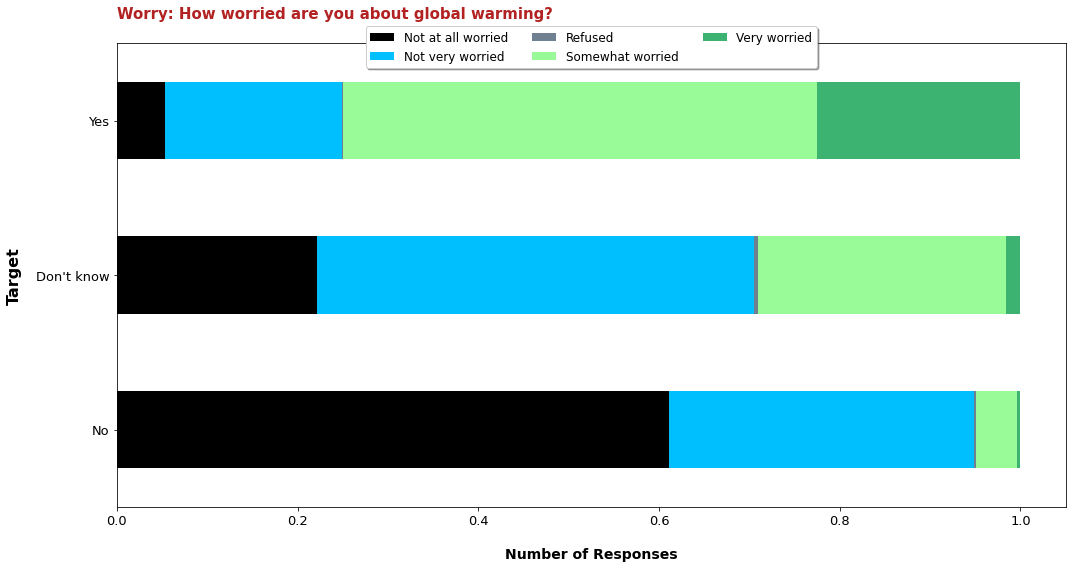

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['worry'].value_counts(dropna=False, normalize=True).unstack().loc[['No', "Don't know", 'Yes']] \
                                      .plot(kind='barh', 
                                            ax=ax,
                                            stacked=True,
                                            color=['black',
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'palegreen', 
                                                   'mediumseagreen',
                                                   'g'], 
                                           label=('1', '2'), 
                                           fontsize=13)
ax.set_title('Worry: How worried are you about global warming?', 
             fontsize=15, fontweight='bold', color='firebrick', loc='left', pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=16, labelpad=14)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=14, labelpad=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

**Worry**

Observation 
- 83 people Refused 
- For `happening` = "Not Yes"
    - 68 Refused
    - 3056 Not at all worried 
    - 19292 expressed some level of worry
- This feature might be misleading for predicting the target
- This feature could be reduced to binary (worry_True, worry_False) for OHE
- Could also reduce to 3 subgroups (not_worried, worried, very_worried)

## Harm Series of Questions
The following five risk perception questions were asked together as a set
- harm_personally
- harm_US
- harm_dev_coutnries
- harm_future_gen
- harm_plants_animals

### Harm Personally
How much do you think global warming will harm: You personally

In [40]:
x = df.groupby('happening')['harm_personally'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

C:\Users\Larry\AppData\Local\Temp/ipykernel_3544/2848853250.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening    harm_personally  Don't know    No    Yes  (sum)
0               A great deal         131    32   2396   2559
1          A moderate amount         599   180   4796   5575
2                 Don't know        1092   254   1190   2536
3                 Not at all        1045  2618   1938   5601
4              Only a little         927   513   4574   6014
5                    Refused          24    15     21     60
(sum)                      0        3818  3612  14915  22345

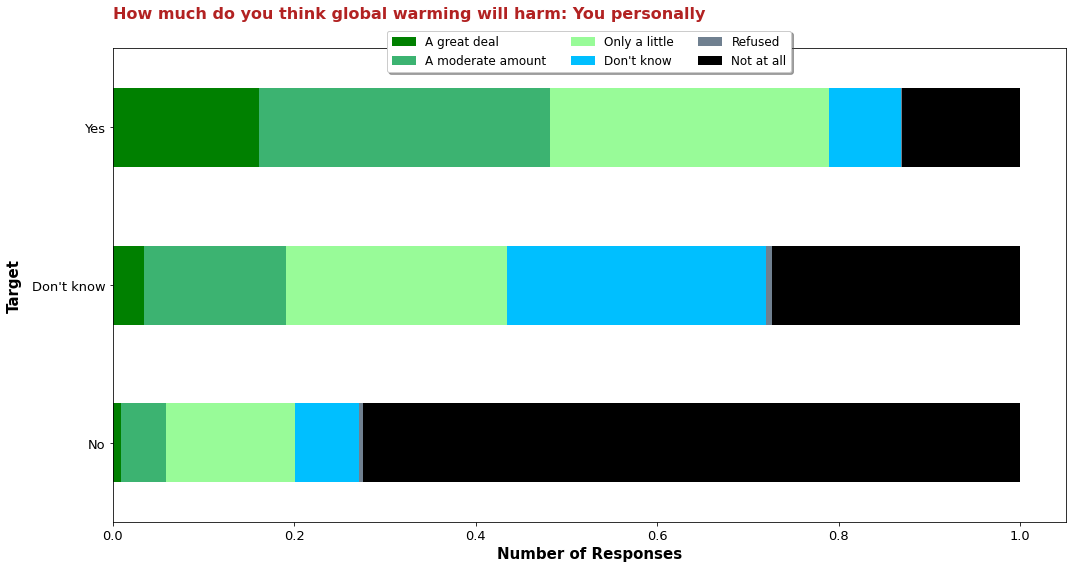

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_personally'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True,
                              fontsize=13, 
                            color=['g', 
                                   'mediumseagreen', 
                                   'palegreen',
                                   'deepskyblue',
                                   'slategrey',
                                   'black'],
                           label=('1', '2'))
ax.set_title('How much do you think global warming will harm: You personally', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=30)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [42]:
df.groupby('happening')['harm_personally'].value_counts().to_frame()

harm_personally
happening  harm_personally                   
Don't know Don't know                    1092
           Not at all                    1045
           Only a little                  927
           A moderate amount              599
           A great deal                   131
           Refused                         24
No         Not at all                    2618
           Only a little                  513
           Don't know                     254
           A moderate amount              180
           A great deal                    32
           Refused                         15
Yes        A moderate amount             4796
           Only a little                 4574
           A great deal                  2396
           Not at all                    1938
           Don't know                    1190
           Refused                         21

**Harm Personally**

Observation 
- 103 people "Refused"
- This will be a good predictor 

### Harm US
How much do you think global warming will harm: People in the United States

In [43]:
x = df.groupby('happening')['harm_US'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

C:\Users\Larry\AppData\Local\Temp/ipykernel_3544/404011177.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening            harm_US  Don't know    No    Yes  (sum)
0               A great deal         245    57   4767   5069
1          A moderate amount         847   288   5583   6718
2                 Don't know        1148   309   1088   2545
3                 Not at all         613  2268    752   3633
4              Only a little         939   670   2689   4298
5                    Refused          26    20     36     82
(sum)                      0        3818  3612  14915  22345

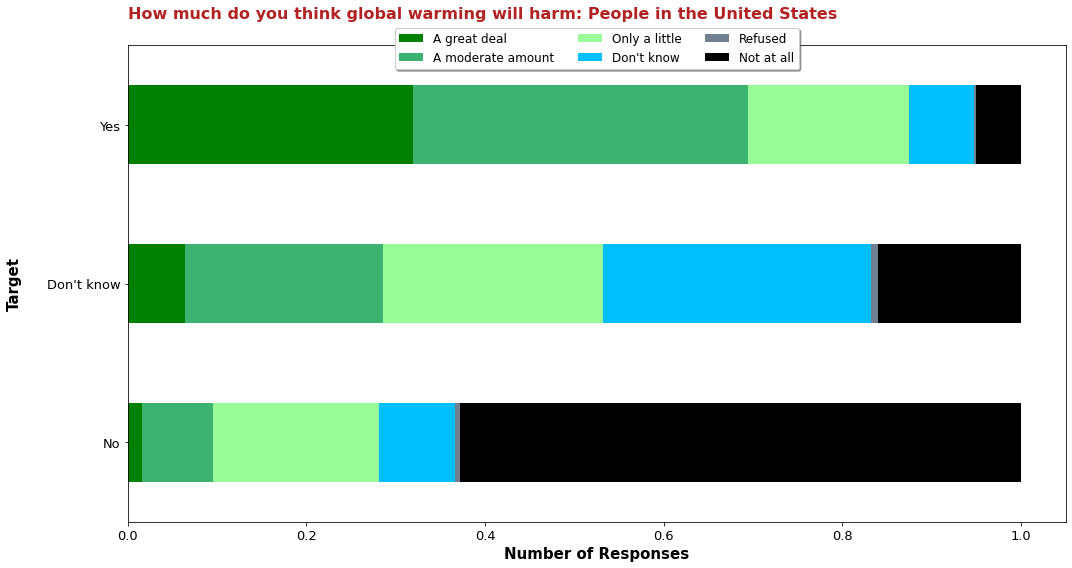

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_US'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True, 
                              fontsize=13,
                              color=['g', 
                                     'mediumseagreen', 
                                     'palegreen',
                                     'deepskyblue',
                                     'slategrey',
                                     'black'],
                              label=('1', '2'))
ax.set_title('How much do you think global warming will harm: People in the United States', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=27)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=25)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

---
---

**Rows with too many questions answered "Refused"**

In [45]:
# df.happening.value_counts()

In [46]:
# # Cause of Global Warming 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') 
#   ]['target'].value_counts()

In [47]:
# # People who "Refused" all Harm series questions 
# df[(df.harm_personally == 'Refused') & 
#    (df.harm_US == 'Refused') & 
#    (df.harm_dev_countries == 'Refused') & 
#    (df.harm_future_gen == 'Refused') & 
#    (df.harm_plants_animals == 'Refused') 
#   ]['target'].value_counts()

In [48]:
# # Cause of Global Warming 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') 
#   ]['target'].value_counts()

In [49]:
# # People who "Refused" Cause questions and all Harm series questions 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') &
#    (df.harm_personally == 'Refused') & 
#    (df.harm_US == 'Refused') & 
#    (df.harm_dev_countries == 'Refused') & 
#    (df.harm_future_gen == 'Refused') & 
#    (df.harm_plants_animals == 'Refused') 
#   ]['target'].value_counts()

**Questions with "Refused" possible answers**

happening

harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals

cause_original
cause_other_text
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

**Columns with underlying Nulls due to Poll Incongruity**

Columns with questions that weren't asked in 'all waves'
- sci_consensus
- harm_plants_animals
- reg_CO2_pollutant
- reg_utilities
- reg_coal_emissions
- hear_GW_media

# Conclusions and Recommendations 

**Features Explored:**
1. wave -> OrdinalEncode
2. year -> OrdinalEncode
3. <font color=grey>weight_wave</font>
4. <font color=grey>weight_aggregate</font>
5. **happening** (target)
    - "Refused" dropped
    - created binary class column `target` ("Yes", "Not Yes")
    - OrdinalEncode fit & transformed original `happening` column
6. <font color=grey>cause_original</font>
7. <font color=grey>cause_other_text</font>
8. cause_recoded
    - final response from features 6 & 7
9. ***sci_consensus***
    - not included for one poll (2015 Oct) 1330 rows
    - interesting feature, worth imputing with KNNImputer
10. worry
    - OrdinalEncode 
11. harm_personally
12. harm_US
13. harm_dev_countries


**Data Cleaning Recommendations:**
- drop rows that "Refused" all Cause and Harm series questions 
- drop remaining 24 rows that "Refused" answering `happening`
- drop columns `weight_wave` and `weight_aggregate`
- drop column `sci_consensus`

In [50]:
# # Row/Column Drops

# print(df.shape)

# df.drop(index=df[(df.harm_personally == 'Refused') & 
#                  (df.harm_US == 'Refused') & 
#                  (df.harm_dev_countries == 'Refused') & 
#                  (df.harm_future_gen == 'Refused') & 
#                  (df.harm_plants_animals == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[(df.cause_original == 'Refused') &
#                  (df.cause_recoded == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[df.happening == "Refused"].index, inplace=True)

# df.drop(labels=['weight_wave', 'weight_aggregate'], axis=1, inplace=True) 

# df.drop(labels=['sci_consensus'], axis=1, inplace=True) 

# df.reset_index(drop=True, inplace=True)

# print(df.shape)

In [51]:
# # Manufacturing Binary feature from worry column

# df['worry_y_n'] = ['worry_n' if x == 'Not at all worried' or x == 'Refused'
#                    else 'worry_y' for x in df.worry]

In [52]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_personally_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_personally]
# df['harm_personally_y_m_n'].value_counts()

In [53]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_US_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_US]
# df['harm_US_y_m_n'].value_counts()

# Model testing 
Binary classes, LabelEncoder, Ordinal Encoder, features aggregated to subgroups

1. Multi vs Binary Class w/ OrdinalEncoded Features
2. Multi vs Binary Class w/ Features simplified to subgroups and dummied

In [54]:
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import (RandomForestClassifier, 
#                               ExtraTreesClassifier, 
#                               BaggingClassifier)
# from sklearn.model_selection import StratifiedKFold

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OrdinalEncoder

In [55]:
# random_state = 73
# n_estimators = 200

# dt = DecisionTreeClassifier(random_state=random_state,
#                             class_weight='balanced',)

# bdt = BaggingClassifier(dt,
#                         random_state=random_state,
#                         n_jobs=-1,
#                         n_estimators=n_estimators)

# rf = RandomForestClassifier(n_jobs=-1, 
#                             class_weight='balanced',
#                             random_state=random_state,
#                             n_estimators=n_estimators)

# et = ExtraTreesClassifier(n_jobs=-1,
#                           class_weight='balanced',
#                           random_state=random_state,
#                           n_estimators=n_estimators)



# def score(model, name, X, y):
#     cv = StratifiedKFold(n_splits=10,
#                          random_state=random_state,
#                          shuffle=True)
#     s = cross_val_score(model, X, y, cv=cv,
#                         n_jobs=-1)
#     print('{} Score: {:.2f} +- {:.3f}'.format(name, 
#                                               s.mean(), 
#                                               2 * s.std()))

# Multi vs. Binary Class  w/ Ordinal Encoded Features

**Ordinal Encoding Selected Features**
- `cause_recoded`
- `worry`
- none, `year`, `wave`

In [56]:
# cats = [['Only a little', 'Not at all', "Don't know", 'A moderate amount',
#        'A great deal', 'Refused'], 
#         ['Only a little', 'Not at all', "Don't know", 'A moderate amount',
#        'A great deal', 'Refused'], 
#         [2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
#         ['2008 Nov', '2010 Jan', '2010 Jun', '2011 May', '2011 Nov', 
#         '2012 Mar', '2012 Sep', '2013 Apr', '2013 Nov', '2014 Apr',
#         '2014 Oct', '2015 Mar', '2015 Oct', '2016 Mar', '2016 Nov',
#         '2017 May', '2017 Oct', '2018 Mar', '2018 Dec',], 
#         ['Caused mostly by human activities',
#        'Caused mostly by natural changes in the environment',
#        "Neither because global warming isn't happening",
#        'Caused by human activities and natural changes', "Don't know",
#        'Other (Please specify)'], 
#         ['Somewhat worried', 'Not very worried', 'Not at all worried',
#        'Very worried', 'Refused']
#        ]

# enc = OrdinalEncoder(categories=cats)

# enc.fit(df[['harm_personally', 
#             'harm_US', 
#             'year', 
#             'wave', 
#             'cause_recoded', 
#             'worry']])

# X_ord = enc.transform(df[['harm_personally', 
#                           'harm_US', 
#                           'year', 
#                           'wave', 
#                           'cause_recoded', 
#                           'worry']])

### Patterns of Missingness

**Questions with "Refused" possible answers**

happening
cause_original
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

In [57]:
# x = '''happening
# cause_original
# cause_recoded
# sci_consensus
# worry
# harm_personally
# harm_US
# harm_dev_countries
# harm_future_gen
# harm_plants_animals
# when_harm_US
# reg_CO2_pollutant
# reg_utilities
# fund_research
# reg_coal_emissions
# discuss_GW
# hear_GW_media
# ideology
# party
# party_w_leaners
# party_x_ideo
# registered_voter
# religion
# evangelical
# service_attendance'''

# x.split('\n')

In [58]:
# tdf = df[['happening',
#          'cause_original',
#          'cause_recoded',
#          'sci_consensus',
#          'worry',
#          'harm_personally',
#          'harm_US',
#          'harm_dev_countries',
#          'harm_future_gen',
#          'harm_plants_animals',
#          'when_harm_US',
#          'reg_CO2_pollutant',
#          'reg_utilities',
#          'fund_research',
#          'reg_coal_emissions',
#          'discuss_GW',
#          'hear_GW_media',
#          'ideology',
#          'party',
#          'party_w_leaners',
#          'party_x_ideo',
#          'registered_voter',
#          'religion',
#          'evangelical',
#          'service_attendance']]

# tdf.head()

In [59]:
# tdf.isna().sum()

In [60]:
# for column in tdf.columns:
#     for i, answer in enumerate(tdf[column]):
#         if answer == 'Refused':
# #             print(column, i, answer)
#             tdf[column][i] = np.nan

In [61]:
# tdf.isna().sum()

NameError: name 'tdf' is not defined

In [ ]:
# tdf.head()

In [ ]:
# pattern = tdf.isnull()[~tdf.isnull().duplicated()].applymap(lambda x: int(x))
# pattern

In [ ]:
# lister = [] # count up appearance of each pattern

# for i in range(len(pattern)):
#     counter = 0

#     for j in tdf.isnull().values:
#         if np.array_equal(j, pattern.values[i]):
#             counter += 1 
#     lister.append(counter)

# pattern.reset_index(drop=True, 
#                     inplace = True) # reset index

# # num of missing values per pattern
# pattern['num_per_row'] = pattern.sum(axis=1).values

# pattern['count'] = lister # number of times a pattern appears in dataset

# pattern.sort_values('num_per_row', ascending=False) # sort values

---
---

In [ ]:
# pattern = tdf.isnull().applymap(lambda x: int(x))
# pattern

In [ ]:
# pattern['num_per_row'] = pattern.sum(axis=1).values

In [ ]:
# pattern[pattern.num_per_row >= 20]['happening'].count()

In [ ]:
# print(pattern.shape, '\n')

# print('75% -', round(pattern.shape[1] * .75), 'Questions - ',
#       pattern[pattern.num_per_row >= 20]['happening'].count(), 'people')

# print('50% -', round(pattern.shape[1] * .50), 'Questions - ',
#       pattern[pattern.num_per_row >= 13]['happening'].count(), 'people')

# pattern[pattern.num_per_row >= 13][['happening', 'num_per_row']].sort_values('num_per_row', ascending=False)

In [ ]:
# df.drop(index=pattern[pattern.num_per_row >= 13][['num_per_row']]\
# .sort_values('num_per_row', ascending=False).index, inplace=True)

In [ ]:
# df.reset_index(drop=True, inplace=True)

# Larry portion

## EDA

In [62]:
def distgraph(var,title):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.barh(df[var].value_counts(normalize=True).index,
              width = df[var].value_counts(normalize=True))

    # label each bar
    ax.bar_label(ax.containers[0],
                    fmt="%.3f",
                   padding = 3)

    # fluff
    ax.set_xlabel('% of Responses')
    ax.set_title(title+'\n\nDistribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left');

def propgraph(var,var_order,title):
    fig, ax = plt.subplots()

    df.groupby(var)['happening'].value_counts(normalize=True)\
        .unstack().loc[var_order].T\
        .loc[['No', "Don't know", 'Yes']].T\
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)
    ax.set_title(title+'\n\nProportion of Belief in Climate Change',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(None)
    ax.legend(loc=(1.05,0.88));

#### `harm_dev_countries`
**How much do you think global warming will harm: People in developing countries**

In [63]:
list(df.harm_dev_countries.unique())

['A great deal',
 'Only a little',
 'Not at all',
 'A moderate amount',
 "Don't know",
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [64]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_dev_countries = df.harm_dev_countries.replace({i:j for i,j in my_dict.items()})

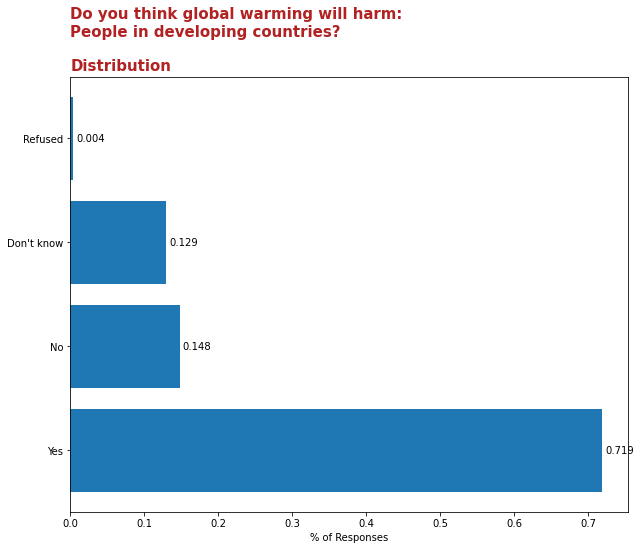

In [65]:
distgraph('harm_dev_countries',
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')

**Observation**
  *  A majority of respondents (71.9%) answered Yes that global warming will harm people in developing countries.
  *  14.8% of respondents answered No
  *  Around 13.3% of respondents either did not know or refused to answer


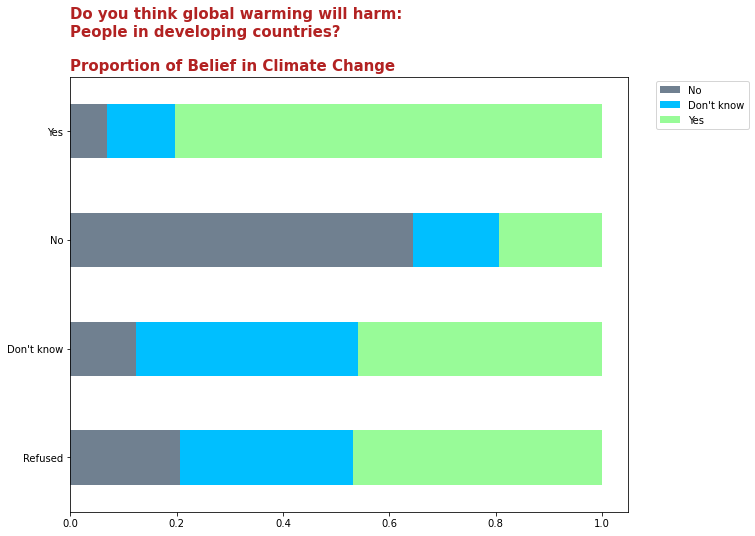

In [66]:
propgraph('harm_dev_countries',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')


  
**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_future_gen`
**How much do you think global warming will harm: Future generations of people**

In [67]:
list(df.harm_future_gen.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [68]:
df.harm_future_gen = df.harm_future_gen.replace({i:j for i,j in my_dict.items()})

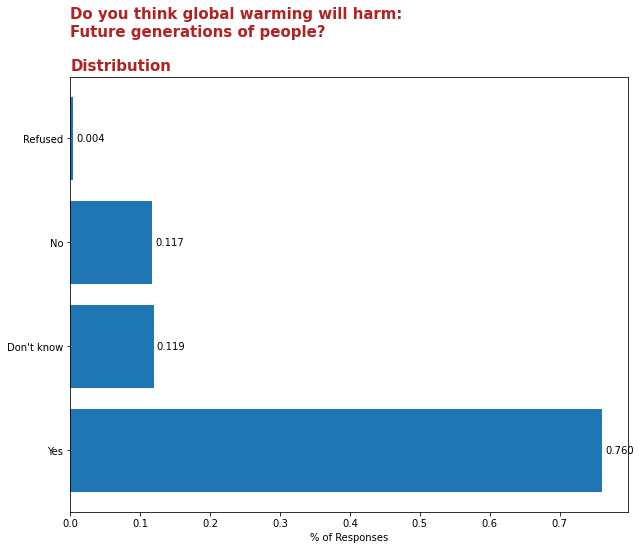

In [69]:
distgraph('harm_future_gen',
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  A majority of respondents (76.0%) answered Yes that global warming will harm future generations of people.
  *  11.9% of respondents answered No
  *  Around 12.1% of respondents either did not know or refused to answer


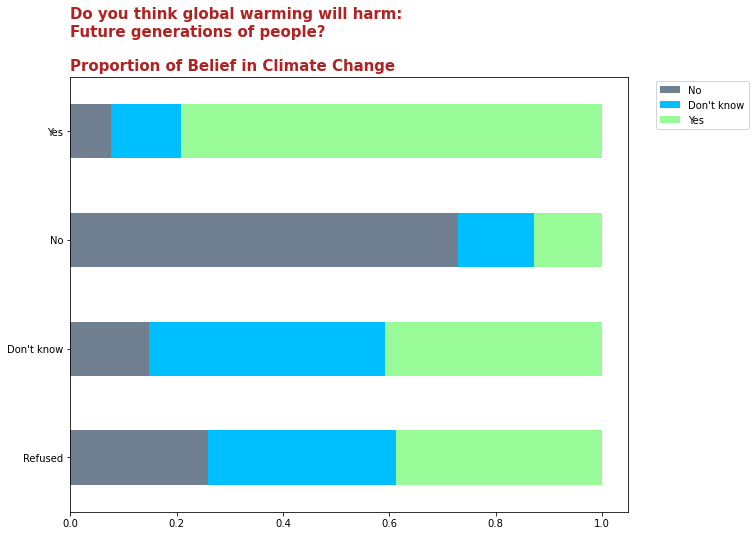

In [70]:
propgraph('harm_future_gen',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_plants_animals`
**How much do you think global warming will harm: Plant and animal species**

In [71]:
df.harm_plants_animals.isnull().sum() / df.shape[0]

0.0595211456701723

6% of respondents were not offered this question as it was not asked in Oct 2015. These will need to be imputed.

In [72]:
list(df.harm_plants_animals.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused',
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [73]:
df.harm_plants_animals = df.harm_plants_animals.replace({i:j for i,j in my_dict.items()})

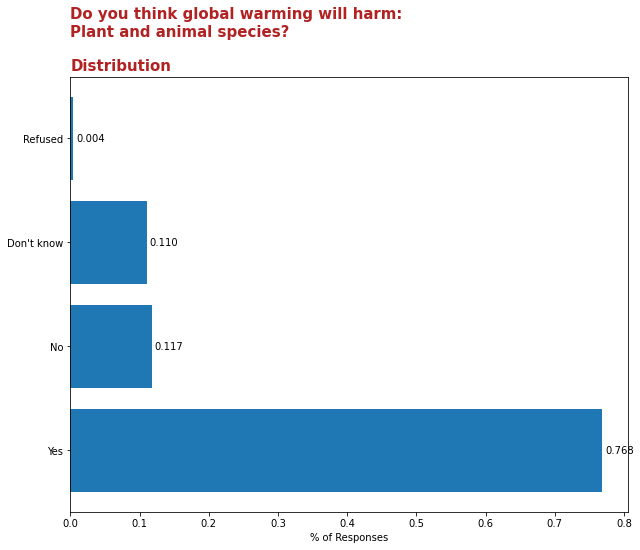

In [74]:
distgraph('harm_plants_animals',
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  A majority of respondents (76.8%) answered Yes that global warming will harm plants and animals.
  *  11.7% of respondents answered No
  *  Around 11.4% of respondents either did not know or refused to answer

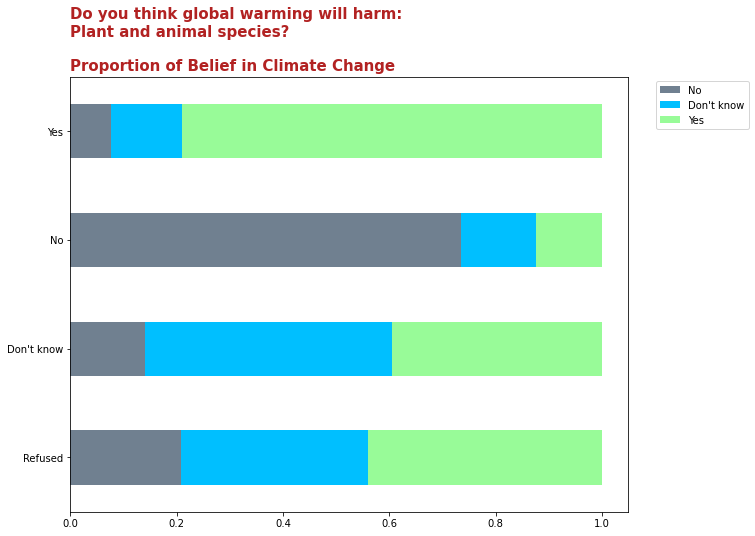

In [75]:
propgraph('harm_plants_animals',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know didn't know if they believe in global warming, closely followed by Yes.
  *  A majority of respondents for Refused believed in global warming.

#### `when_harm_us`
**When do you think global warming will start to harm people in the United States?**

In [76]:
list(df.when_harm_US.unique())

['In 10 years',
 'In 50 years',
 'Never',
 'In 25 years',
 'In 100 years',
 'They are being harmed now',
 'Refused']

The response options. Map these to Refused, Never, In the Future, and Now for more absolute groupings.

In [77]:
my_dict = {'In 10 years': 'In the Future',
           'In 50 years': 'In the Future',
           'Never': 'Never',
           'In 25 years': 'In the Future',
           'In 100 years': 'In the Future',
           'They are being harmed now': 'Now',
           'Refused': 'Refused'}

df.when_harm_US = df.when_harm_US.replace({i:j for i,j in my_dict.items()})

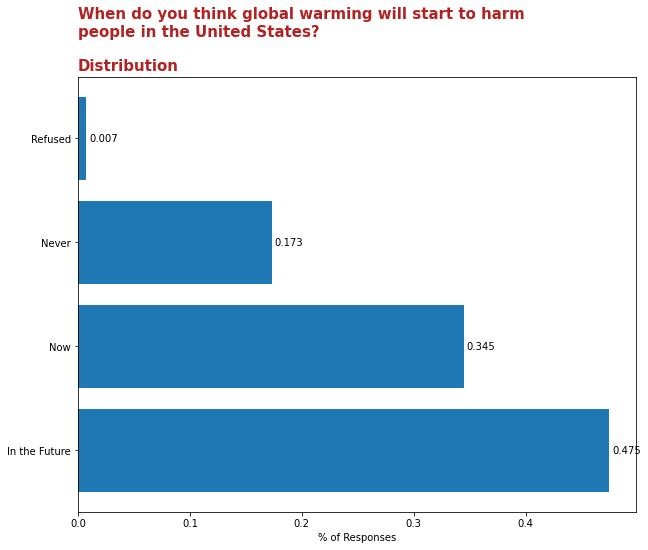

In [78]:
distgraph('when_harm_US',
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  A plurality of respondents (47.5%) answered `In the Future` for when global warming will start to harm people in the United States.
  *  34.5% of respondents answered `Now`
  *  17.3% of respondents answer `Never`

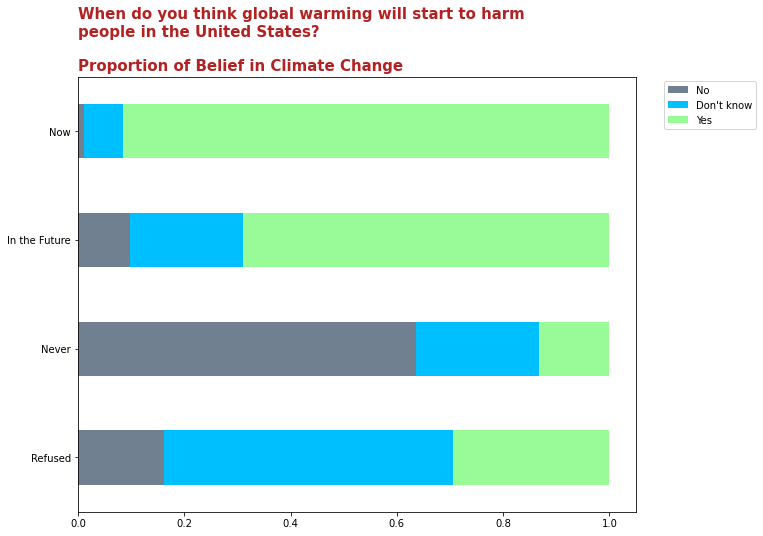

In [79]:
propgraph('when_harm_US',
          ['Refused','Never', 'In the Future','Now'],
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  Unsurprisingly, `Now` and `In the Future` both believe in global warming by a large margin
  *  Respondents for `Never` still held decent amounts of Don't Know and Yes for belief in global warming indicating that global warming may not be inherently harmful in their mind.

#### `reg_CO2_pollutant`
**How much do you support or oppose the following policies?
Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.**

In [80]:
df.reg_CO2_pollutant.isnull().sum()/df.shape[0]

0.04466323562318192

4.5% of respondents were not offered this question as it was not asked in May 2011. These will need to be imputed.

In [81]:
list(df.reg_CO2_pollutant.unique())

['Strongly support',
 'Somewhat support',
 'Somewhat oppose',
 'Strongly oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [82]:
my_dict = {'Strongly support': 'Support',
           'Somewhat support': 'Support',
           'Somewhat oppose': 'Oppose',
           'Strongly oppose': 'Oppose',
           'Refused': 'Refused'}

df.reg_CO2_pollutant = df.reg_CO2_pollutant.replace({i:j for i,j in my_dict.items()})

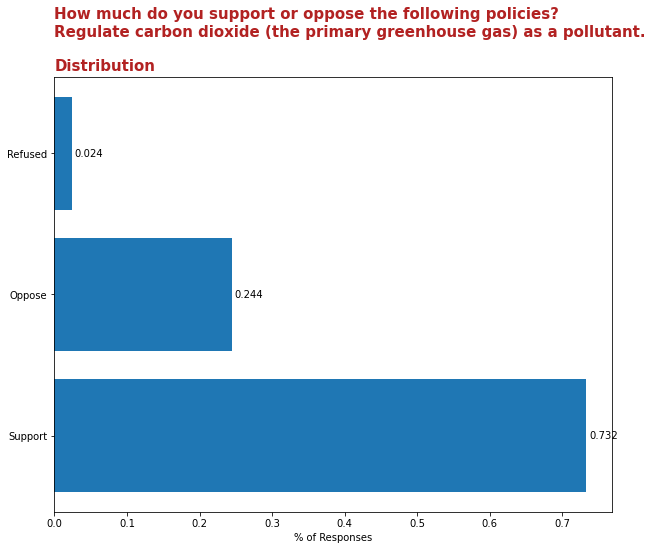

In [83]:
distgraph('reg_CO2_pollutant',
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  A majority of respondents (73.2%) support regulating carbon dioxide.
  *  24.4% of respondents answered No
  *  Around 2.4% of respondents either did not know or refused to answer

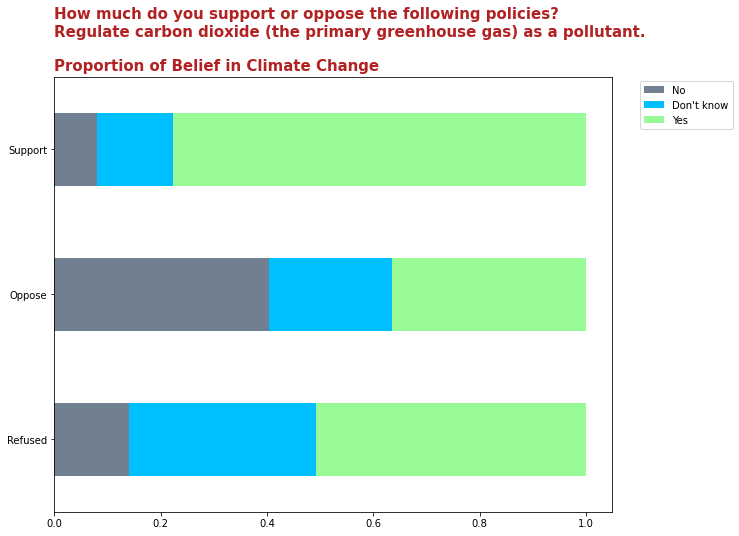

In [84]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_utilities`
**How much do you support or oppose the following policies? Require electric utilities to produce at least 20% of their electricity from wind, solar, or other renewable energy sources, even if it costs the average household an extra $100 a year.**

In [85]:
df.reg_utilities.isnull().sum() / df.shape[0]

0.22492727679570373

22.5% of respondents were not offered this question as it was not asked in Oct 2015, Mar and Nov 2016, and May 2017. These will need to be imputed.

In [86]:
list(df.reg_utilities .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [87]:
df.reg_utilities = df.reg_utilities.replace({i:j for i,j in my_dict.items()})

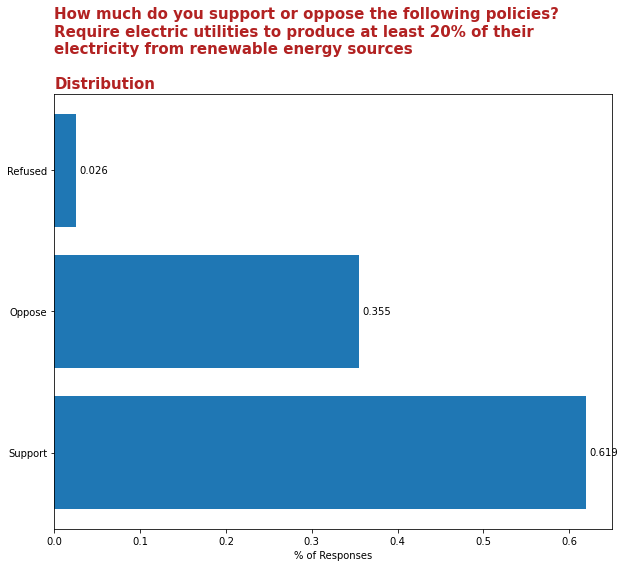

In [88]:
distgraph('reg_utilities',
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  A majority of respondents (61.9%) support requiring electric utilities to produce at least 20% renewable energy.
  *  35.5% of respondents answered No
  *  Around 2.6% of respondents either did not know or refused to answer

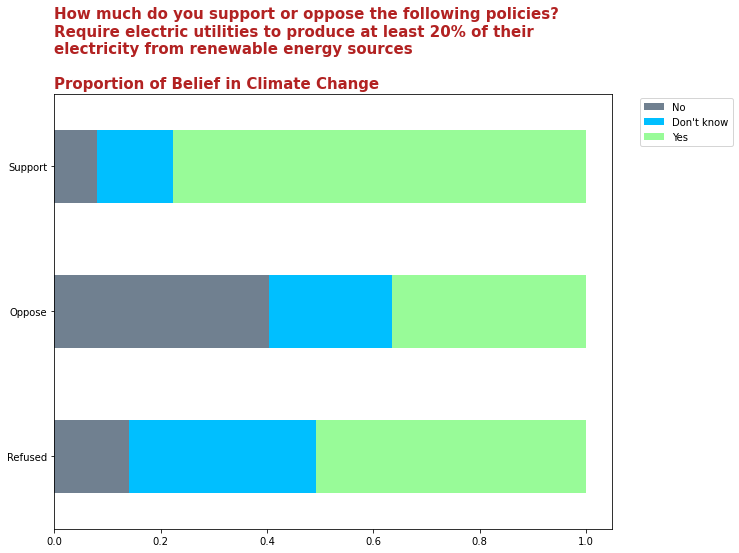

In [89]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `fund_research`
**How much do you support or oppose the following policies? Fund more research into renewable energy sources, such as solar and wind power.**

In [90]:
list(df.fund_research .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused']

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [91]:
df.fund_research = df.fund_research.replace({i:j for i,j in my_dict.items()})

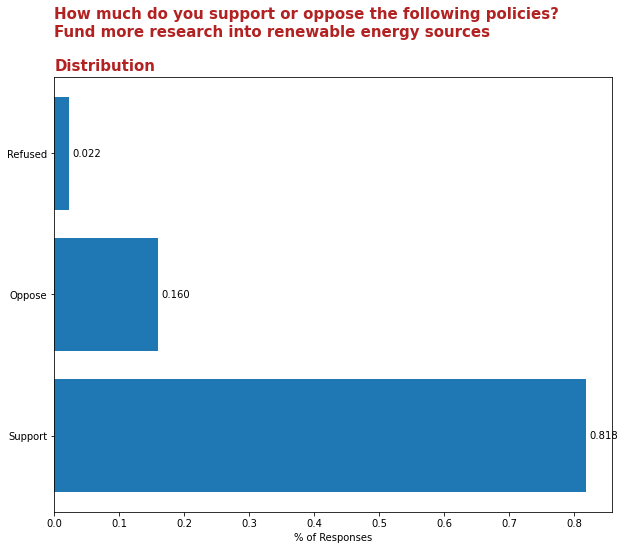

In [92]:
distgraph('fund_research',
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  A majority of respondents (81.8%) support funding more research into renewable energy sources.
  *  16.0% of respondents answered No
  *  Around 2.2% of respondents refused to answer

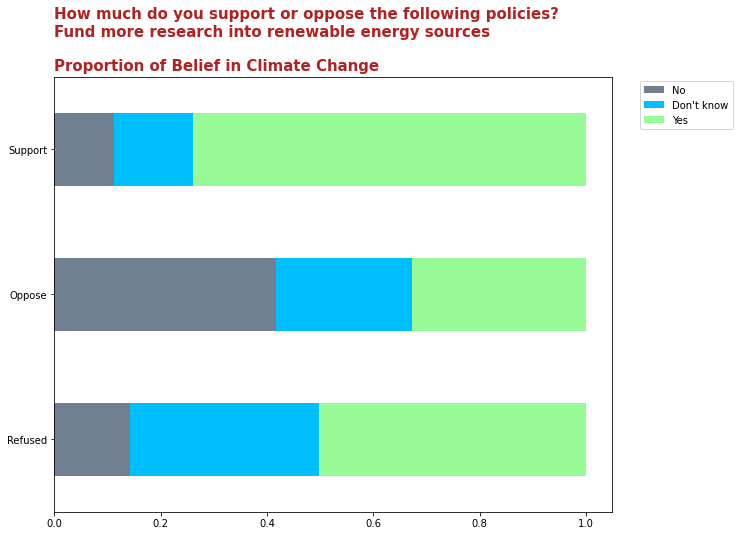

In [93]:
propgraph('fund_research',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_coal_emissions`
**How much do you support or oppose the following policy? Set strict carbon dioxide emission limits on existing coal-fired power plants to reduce global warming and improve public health. Power plants would have to reduce their emissions and/or invest in renewable energy and energy efficiency. The cost of electricity to consumers and companies would likely increase**

In [94]:
df.reg_coal_emissions.isnull().sum() / df.shape[0]

0.4042962631461177

40.4% of respondents were not offered this question as it was not asked between 2008 and 2012, and Nov 2013.

Because of this high amount of missingness, drop the column.

In [95]:
df.drop('reg_coal_emissions', axis = 1, inplace=True)

#### `discuss_GW`
**How often do you discuss global warming with your family and friends?**

In [96]:
list(df.discuss_GW.unique())

['Occasionally', 'Rarely', 'Never', 'Often', 'Refused']

The response options. Map these to Refused, Never, At All for more absolute groupings

In [97]:
my_dict = {'Occasionally': 'At All',
           'Rarely': 'At All',
           'Never': 'Never',
           'Often': 'At All',
           'Refused': 'Refused'}

df.discuss_GW = df.discuss_GW.replace({i:j for i,j in my_dict.items()})

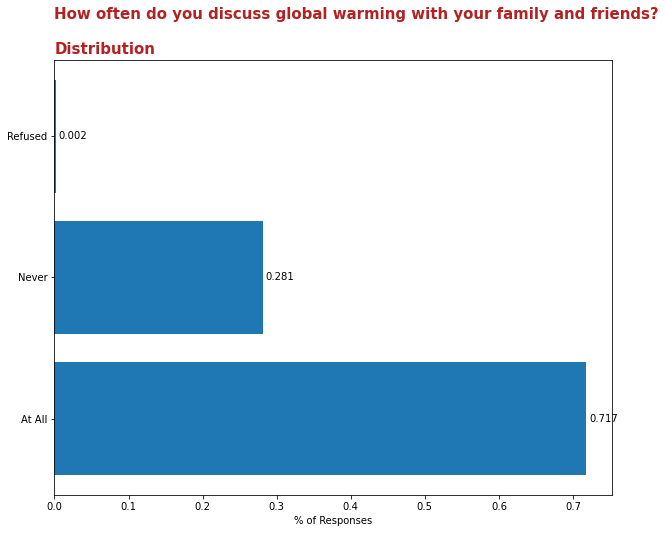

In [98]:
distgraph('discuss_GW',
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  A majority of respondents discuss global warming with family and friends

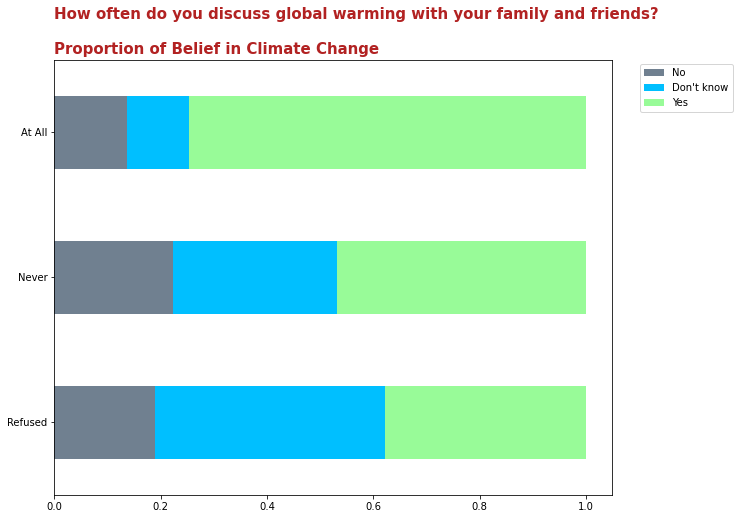

In [99]:
propgraph('discuss_GW',
          ['Refused','Never','At All'],
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  Despite `Never` discussing global warming with family and friends, that group of respondents still believes in global warming on average along with `At All`

#### `hear_GW_media`
**About how often do you hear about global warming in the media (TV, movies, radio, newspapers/news websites, magazines, etc.)?**

In [100]:
df.hear_GW_media.isnull().sum() / df.shape[0]

0.6080554933989707

60.8% of respondents were not offered this question as it was not asked between 2008 and 2014, and Nov 2016.

Because of this high amount of missingness, drop the column.

In [101]:
df.drop('hear_GW_media', axis = 1, inplace=True)

#### `gender`
**Are you Male or Female?**

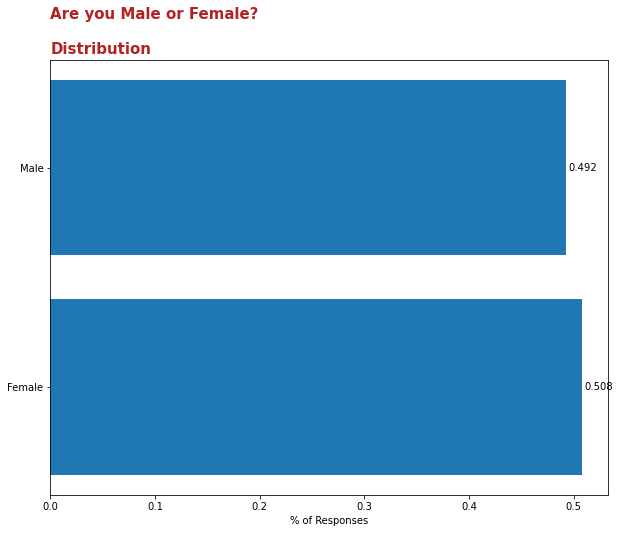

In [102]:
distgraph('gender',
          'Are you Male or Female?')

**Observation**
  *  The distribution of responses is very close to even with `female` representing a majority of responses at 50.8%

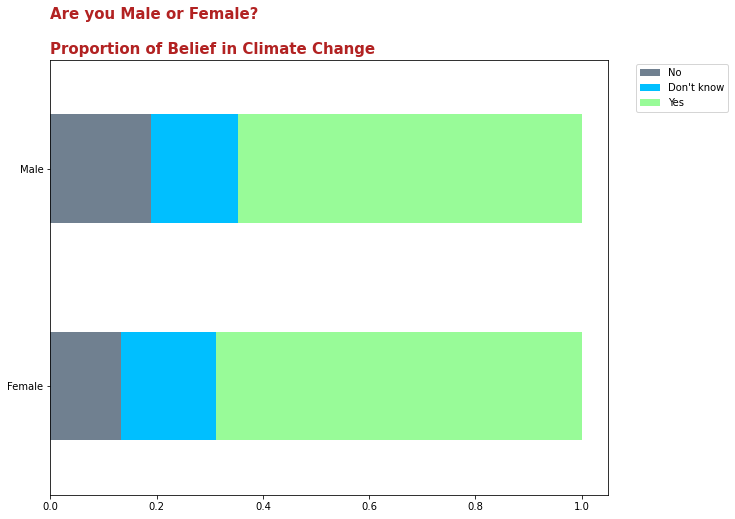

In [103]:
propgraph('gender',
          ['Female','Male'],
          'Are you Male or Female?')

**Observation**
  *  `Female` respondents believed in global warming more than `Male` respondents.

In [104]:
# dummify gender to be 0 for male and 1 for female
df.gender = [int(val == 'Female') for val in df.gender]

#### `age`
**How old are you?**

In [105]:
df.age.describe()

count    22345.000000
mean        50.482166
std         16.805682
min         18.000000
25%         37.000000
50%         52.000000
75%         64.000000
max         97.000000
Name: age, dtype: float64

The range of responses was 18-97 meaning only responses from adults were recorded. The average age was 50 years old.

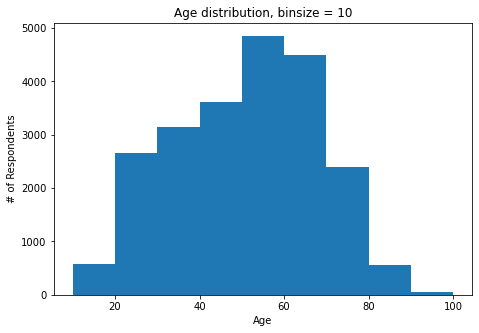

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax.hist(df.age,
        bins = np.arange(10,101,10))
ax.set_title('Age distribution, binsize = 10')
ax.set_ylabel('# of Respondents')
ax.set_xlabel('Age');

**Observation**
  *  The age distribution is centered around 50, which is also the mean and contains the median value 52.
  *  Right tailed with small amount of respondents in the 90-100 range.
  *  High number of young respondents also making it more skewed.

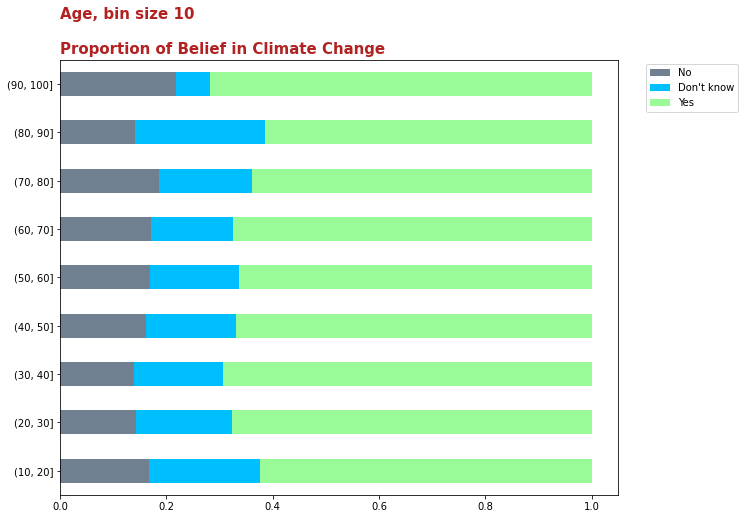

In [107]:
# graph

propgraph(pd.cut(df.age, bins = np.arange(10,101,10)),
          [pd.Interval(10, 20, closed='right'),
           pd.Interval(20, 30, closed='right'),
           pd.Interval(30, 40, closed='right'),
           pd.Interval(40, 50, closed='right'),
           pd.Interval(50, 60, closed='right'),
           pd.Interval(60, 70, closed='right'),
           pd.Interval(70, 80, closed='right'),
           pd.Interval(80, 90, closed='right'),
           pd.Interval(90, 100, closed='right')],
          "Age, bin size 10")

**Observations**
  *  Each age group has a majority of respondents believing in global warming
  *  `20-30` and `30-40` are some of the strongest believers on average
  *  `50-60` was the most popular age bracket for the survey and is one of the softer groups for believing in climate change.

#### `age_category`
**Computed from `age` as a range**

In [108]:
list(df.age_category.unique())

['55+ years', '35-54 years', '18-34 years']

The computed ranges.

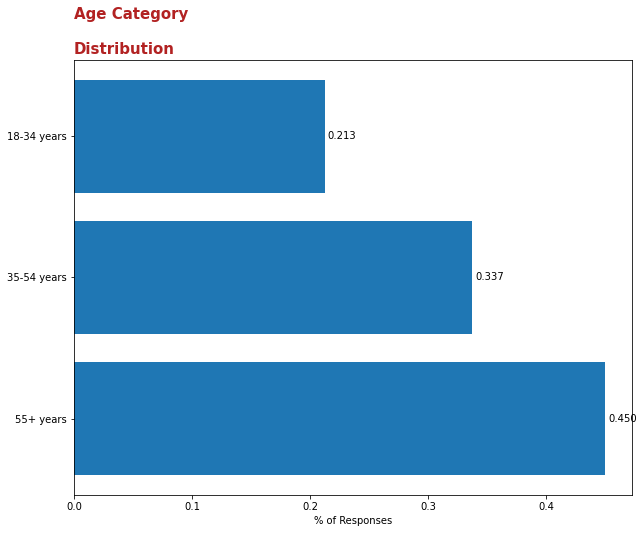

In [109]:
distgraph('age_category',
          'Age Category')

**Observation**
  *  A plurality of respondents are in the 55+ category
  *  The youngest age group is the least represented in the survey

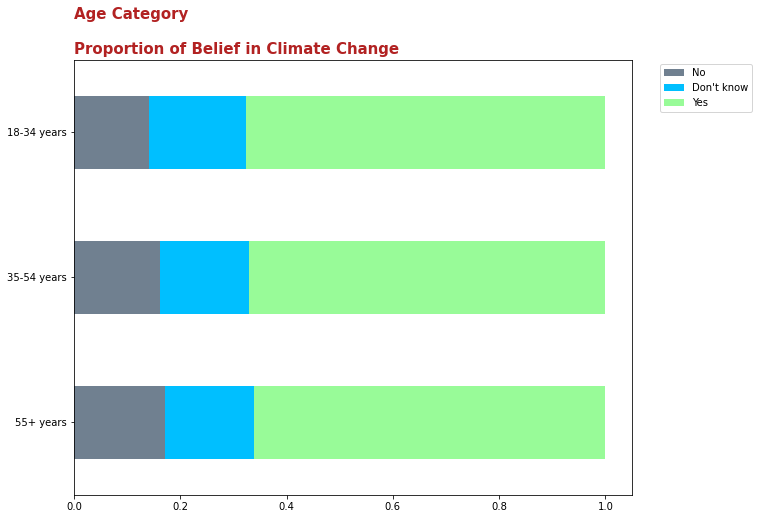

In [110]:
propgraph('age_category',
          ['55+ years','35-54 years','18-34 years'],
          'Age Category')

**Observation**
  *  All three age categories have similar belief proportions.

In [111]:
# dummify age_category and drop 18-34 years as an option
df = df.join(pd.get_dummies(df.age_category, prefix='age_category', 
                            drop_first=True))

# rename the new dummy columns to represent their value
df.rename(columns = {df.columns[-2]:'age_category_35_54', 
                     df.columns[-1]: 'age_category_55_plus'}, 
          inplace=True)

#drop age_category
df.drop('age_category', axis=1, inplace=True)

# VILO

### Dummifying values to do some initial EDA

In [112]:
dum_happen = pd.get_dummies(df['happening'])

### Taking a look at the features below


In [113]:
df2 = df[['generation', 'educ', 'educ_category', 'income', 'income_category',
          'race', 'ideology', 'party', 'party_w_leaners', 'party_x_ideo',
          'registered_voter', 'region9', 'region4']]

In [114]:
df2.describe()

generation  \
count                        22345   
unique                           6   
top     Baby Boomers (1946 - 1964)   
freq                          9132   

                                                     educ  \
count                                               22345   
unique                                                 14   
top     High school graduate - high school diploma or ...   
freq                                                 6303   

                      educ_category                income    income_category  \
count                         22345                 22345              22345   
unique                            4                    21                  3   
top     Bachelor's degree or higher  $100,000 to $124,999  Less than $50,000   
freq                           7700                  2567               8750   

                       race                      ideology     party  \
count                 22345                         22345     22345   
unique                    4                             6         6   
top     White, Non-Hispanic  Moderate, middle of the road  Democrat   
freq                  16777                          8837      7397   

       party_w_leaners             party_x_ideo registered_voter  \
count            22345                    22345            22345   
unique               5                        7                6   
top          Democrats  Conservative Republican       Registered   
freq              9237                     5491            18820   

               region9 region4  
count            22345   22345  
unique               9       4  
top     South Atlantic   South  
freq              4325    7847

### Checking the null values

In [115]:
df2.isnull().sum()

generation          0
educ                0
educ_category       0
income              0
income_category     0
race                0
ideology            0
party               0
party_w_leaners     0
party_x_ideo        0
registered_voter    0
region9             0
region4             0
dtype: int64

### Creating Dummies from the features

In [116]:
df2_dum = pd.get_dummies(df2)

In [117]:
df2_dum.head()

generation_Baby Boomers (1946 - 1964)  \
0                                      0   
1                                      1   
2                                      1   
3                                      0   
4                                      0   

   generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
0                                     0                                1   
1                                     0                                0   
2                                     0                                0   
3                                     0                                1   
4                                     1                                0   

   generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
0                                 0                0                0   
1                                 0                1                0   
2                                 0                0                0   
3                                 0                0                0   
4                                 0                0                0   

   educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
0                           0                                 0  ...   
1                           0                                 0  ...   
2                           0                                 0  ...   
3                           0                                 0  ...   
4                           0                                 0  ...   

   region9_Mountain  region9_New England  region9_Pacific  \
0                 0                    0                0   
1                 0                    0                0   
2                 1                    0                0   
3                 0                    0                0   
4                 0                    0                0   

   region9_South Atlantic  region9_West-North Central  \
0                       1                           0   
1                       0                           0   
2                       0                           0   
3                       1                           0   
4                       0                           0   

   region9_West-South Central  region4_Midwest  region4_Northeast  \
0                           0                0                  0   
1                           0                1                  0   
2                           0                0                  0   
3                           0                0                  0   
4                           0                0                  0   

   region4_South  region4_West  
0              1             0  
1              0             0  
2              0             1  
3              1             0  
4              1             0  

[5 rows x 95 columns]

In [118]:
df2.shape

(22345, 13)

In [119]:
dummies = pd.concat([df2_dum, dum_happen], axis=1)

### I am looking at the breakdown of people who answered Yes vs Not yes for if global warming is happening

In [120]:
dummies.groupby(['Yes']).mean()

generation_Baby Boomers (1946 - 1964)  \
Yes                                          
0                                 0.403769   
1                                 0.411130   

     generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
Yes                                                                             
0                                 0.238358                           0.008345   
1                                 0.242306                           0.006168   

     generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
Yes                                                                          
0                                0.176581                         0.162046   
1                                0.187127                         0.139859   

     generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
Yes                                                                       
0                            0.010902         0.016958         0.023015   
1                            0.013409         0.012873         0.018505   

     educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
Yes                                                                ...   
0                      0.025707                          0.000942  ...   
1                      0.020315                          0.001676  ...   

     region9_Pacific  region9_South Atlantic  region9_West-North Central  \
Yes                                                                        
0           0.132167                0.192732                    0.082638   
1           0.164733                0.193966                    0.074556   

     region9_West-South Central  region4_Midwest  region4_Northeast  \
Yes                                                                   
0                      0.108883         0.251144           0.164065   
1                      0.098961         0.229903           0.192156   

     region4_South  region4_West  Don't know        No  
Yes                                                     
0         0.373890      0.210902    0.513863  0.486137  
1         0.339859      0.238082    0.000000  0.000000  

[2 rows x 97 columns]

In [121]:
dummies.corr()

generation_Baby Boomers (1946 - 1964)  \
generation_Baby Boomers (1946 - 1964)                               1.000000   
generation_Generation X (1965 - 1980)                              -0.468449   
generation_Greatest (Before 1928)                                  -0.069255   
generation_Millennials (1981 - 1996)                               -0.394273   
generation_Silent (1928 - 1945)                                    -0.345442   
...                                                                      ...   
region4_South                                                      -0.007996   
region4_West                                                       -0.029601   
Don't know                                                         -0.025480   
No                                                                  0.017024   
Yes                                                                 0.007055   

                                       generation_Generation X (1965 - 1980)  \
generation_Baby Boomers (1946 - 1964)                              -0.468449   
generation_Generation X (1965 - 1980)                               1.000000   
generation_Greatest (Before 1928)                                  -0.046941   
generation_Millennials (1981 - 1996)                               -0.267236   
generation_Silent (1928 - 1945)                                    -0.234139   
...                                                                      ...   
region4_South                                                       0.005025   
region4_West                                                        0.010607   
Don't know                                                          0.002193   
No                                                                 -0.007808   
Yes                                                                 0.004349   

                                       generation_Greatest (Before 1928)  \
generation_Baby Boomers (1946 - 1964)                          -0.069255   
generation_Generation X (1965 - 1980)                          -0.046941   
generation_Greatest (Before 1928)                               1.000000   
generation_Millennials (1981 - 1996)                           -0.039508   
generation_Silent (1928 - 1945)                                -0.034615   
...                                                                  ...   
region4_South                                                  -0.002358   
region4_West                                                    0.006085   
Don't know                                                      0.012484   
No                                                              0.003095   
Yes                                                            -0.012393   

                                       generation_Millennials (1981 - 1996)  \
generation_Baby Boomers (1946 - 1964)                             -0.394273   
generation_Generation X (1965 - 1980)                             -0.267236   
generation_Greatest (Before 1928)                                 -0.039508   
generation_Millennials (1981 - 1996)                               1.000000   
generation_Silent (1928 - 1945)                                   -0.197064   
...                                                                     ...   
region4_South                                                      0.003179   
region4_West                                                       0.020693   
Don't know                                                         0.010422   
No                                                                -0.027078   
Yes                                                                0.012832   

                                       generation_Silent (1928 - 1945)  \
generation_Baby Boomers (1946 - 1964)                        -0.345442   
generation_Generation X (1965 - 1980)                        -0.234139   
generation_Greatest (Before 1928)

In [122]:
top_corr1 = pd.DataFrame(dummies.corr().sort_values(by='Yes', ascending=False)['Yes'][:20])

### Looking at the top positive correlated features with answering yes to 'happening'

In [123]:
top_corr1

Yes
Yes                                          1.000000
party_w_leaners_Democrats                    0.355989
party_Democrat                               0.283737
party_x_ideo_Liberal Democrat                0.280506
ideology_Somewhat liberal                    0.218352
party_x_ideo_Moderate/Conservative Democrat  0.155292
ideology_Very liberal                        0.132601
educ_category_Bachelor's degree or higher    0.101013
ideology_Moderate, middle of the road        0.090809
educ_Master's degree                         0.067025
educ_Professional or Doctorate degree        0.054109
race_Hispanic                                0.044516
region9_Pacific                              0.042517
educ_Bachelor's degree                       0.042166
race_Black, Non-Hispanic                     0.039823
income_category_$100,000 or more             0.037309
region4_Northeast                            0.034239
race_Other, Non-Hispanic                     0.032925
region4_West                                 0.030473
registered_voter_Registered                  0.027857

In [124]:
top_corr_neg = pd.DataFrame(dummies.corr().sort_values(by='Yes')['Yes'][:20])

### The top negative correlated features for answering yes to 'happening'

In [125]:
top_corr_neg

Yes
Don't know                                         -0.643180
No                                                 -0.622139
party_x_ideo_Conservative Republican               -0.331449
party_w_leaners_Republicans                        -0.312329
ideology_Very conservative                         -0.264175
party_Republican                                   -0.254572
ideology_Somewhat conservative                     -0.177769
race_White, Non-Hispanic                           -0.075204
educ_category_High school                          -0.065686
educ_High school graduate - high school diploma... -0.065686
region9_East-South Central                         -0.052208
party_Other; Please specify:                       -0.051025
party_w_leaners_No party/Not interested in poli... -0.047333
party_x_ideo_No Party/Not Interested in politics   -0.047333
party_No party/not interested in politics          -0.047333
registered_voter_Don't know                        -0.039035
ideology_Refused                                   -0.038713
educ_category_Less than high school                -0.034939
region4_South                                      -0.033587
party_x_ideo_Refused                               -0.032253

''

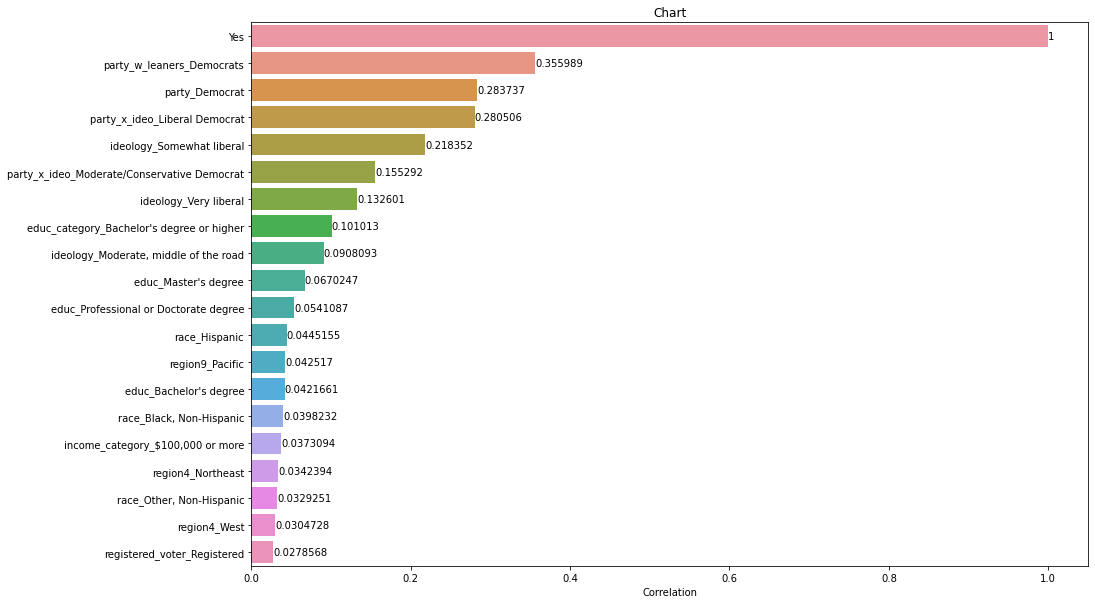

In [126]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr1.index, data=top_corr1, orient='h')
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

''

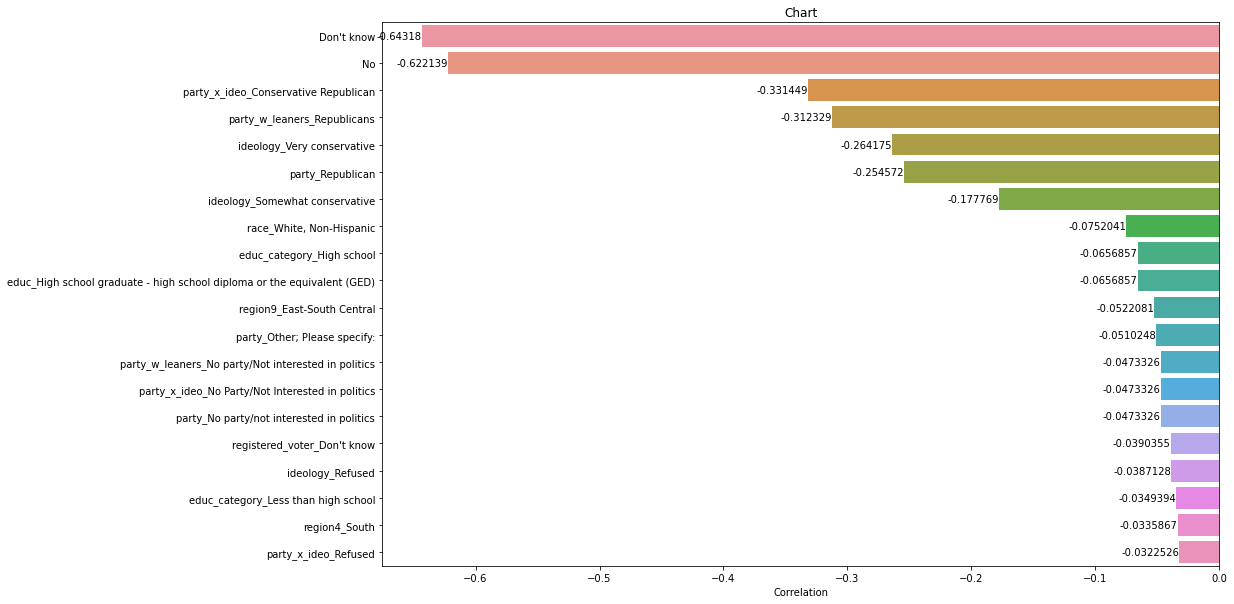

In [127]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr_neg.index, data=top_corr_neg)
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

### A rough correlation heat map between features

<AxesSubplot:>

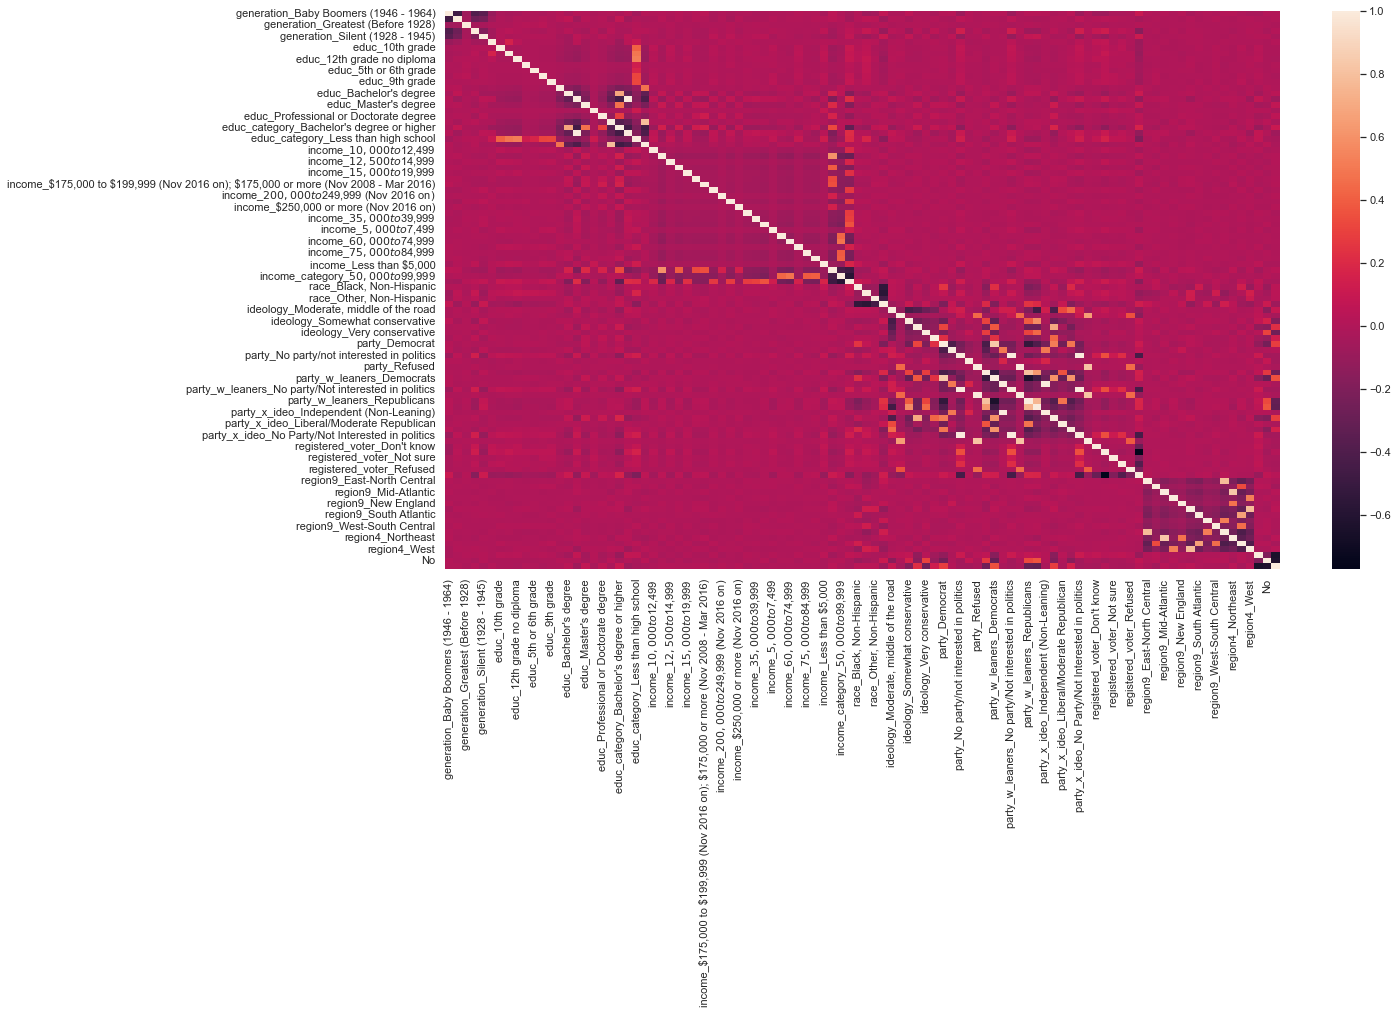

In [128]:
sns.set(rc={'figure.figsize':(18.7,10.27)})
sns.heatmap(dummies.corr())

### Checking distribution of all features

In [129]:
df2['generation'].value_counts(normalize=True)

Baby Boomers (1946 - 1964)    0.408682
Generation X (1965 - 1980)    0.240994
Millennials (1981 - 1996)     0.183620
Silent (1928 - 1945)          0.147237
iGen‎/Gen Z (1997 - )         0.012576
Greatest (Before 1928)        0.006892
Name: generation, dtype: float64

<AxesSubplot:xlabel='generation', ylabel='Count'>

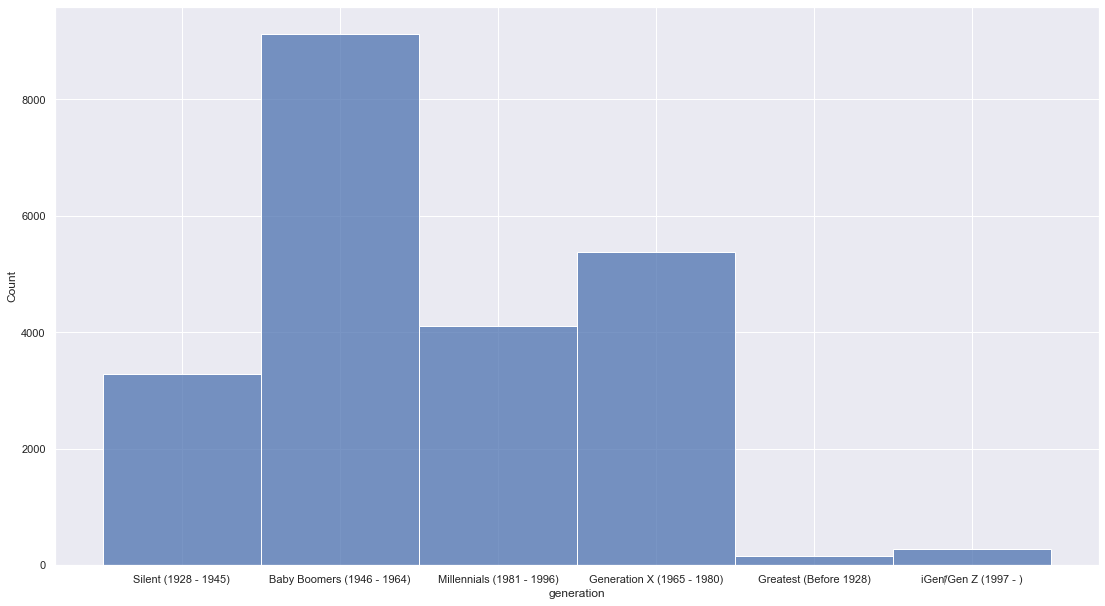

In [130]:
sns.histplot(data=df2, x = 'generation')

In [131]:
df2['educ'].value_counts(normalize=True)

High school graduate - high school diploma or the equivalent (GED)    0.282077
Some college, no degree                                               0.207697
Bachelor's degree                                                     0.199373
Master's degree                                                       0.105482
Associate's degree                                                    0.087402
Professional or Doctorate degree                                      0.039740
12th grade no diploma                                                 0.022108
11th grade                                                            0.020004
10th grade                                                            0.014231
9th grade                                                             0.008503
7th or 8th grade                                                      0.008235
5th or 6th grade                                                      0.002506
1st, 2nd, 3rd, or 4th grade                         

<AxesSubplot:xlabel='educ', ylabel='Count'>

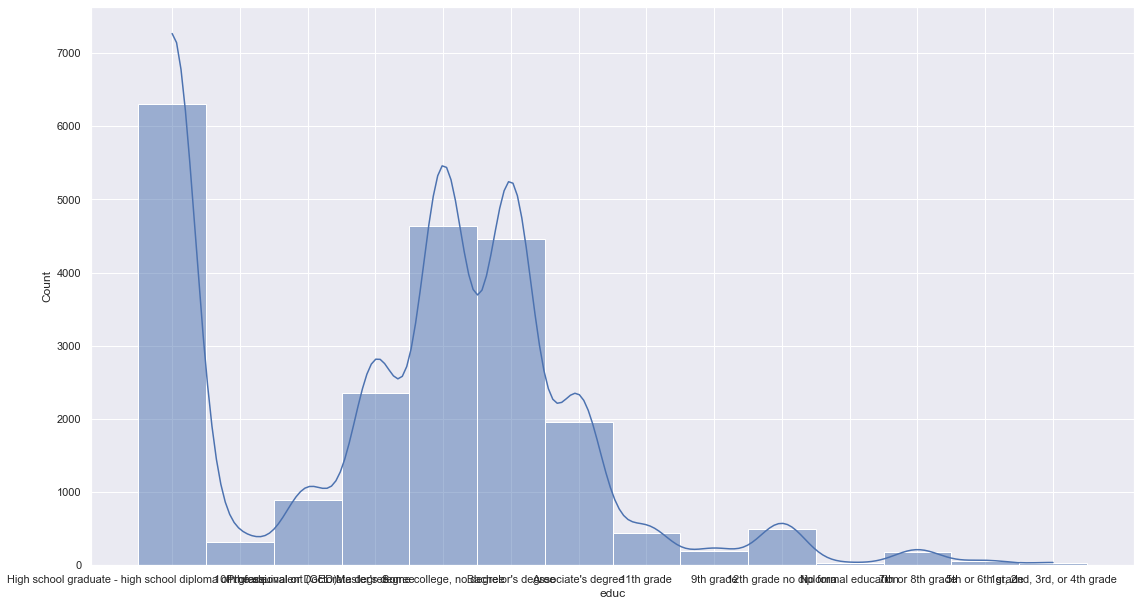

In [132]:
sns.histplot(data=df2, x = 'educ', kde=True)

In [133]:
df2['educ_category'].value_counts(normalize=True)

Bachelor's degree or higher    0.344596
Some college                   0.295100
High school                    0.282077
Less than high school          0.078228
Name: educ_category, dtype: float64

<AxesSubplot:xlabel='educ_category', ylabel='Count'>

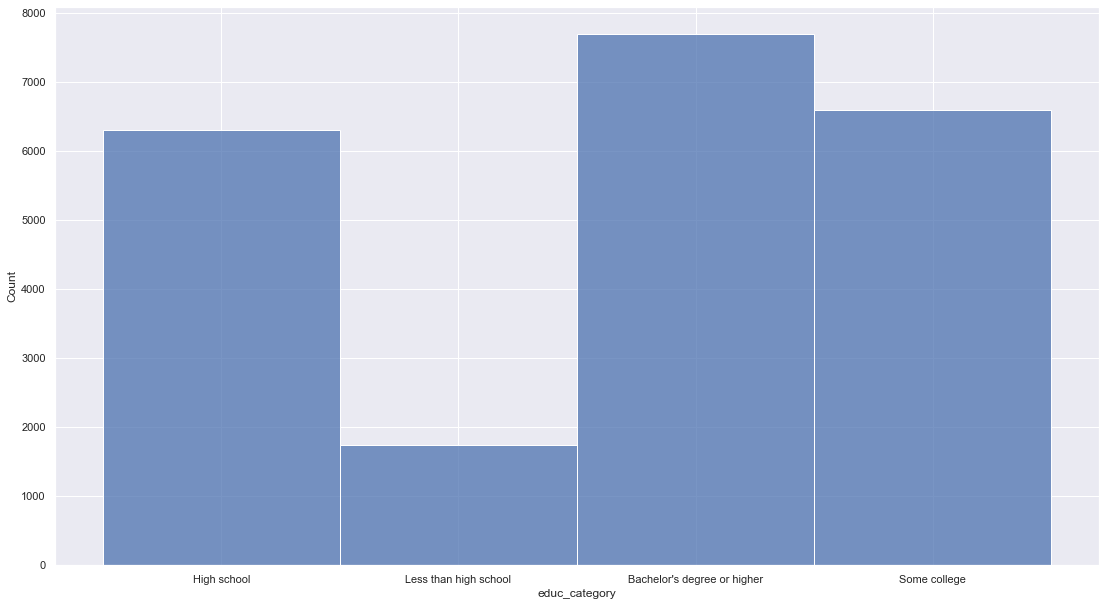

In [134]:
sns.histplot(data=df2, x = 'educ_category')

In [135]:
df2['income'].value_counts(normalize=True)

$100,000 to $124,999                                                          0.114880
$60,000 to $74,999                                                            0.106422
$50,000 to $59,999                                                            0.088029
$40,000 to $49,999                                                            0.078317
$85,000 to $99,999                                                            0.076393
$75,000 to $84,999                                                            0.071962
$125,000 to $149,999                                                          0.054017
$35,000 to $39,999                                                            0.053435
$30,000 to $34,999                                                            0.047930
$25,000 to $29,999                                                            0.046543
$175,000 to $199,999 (Nov 2016 on); $175,000 or more (Nov 2008 - Mar 2016)    0.042247
$20,000 to $24,999                         

<AxesSubplot:xlabel='income', ylabel='Count'>

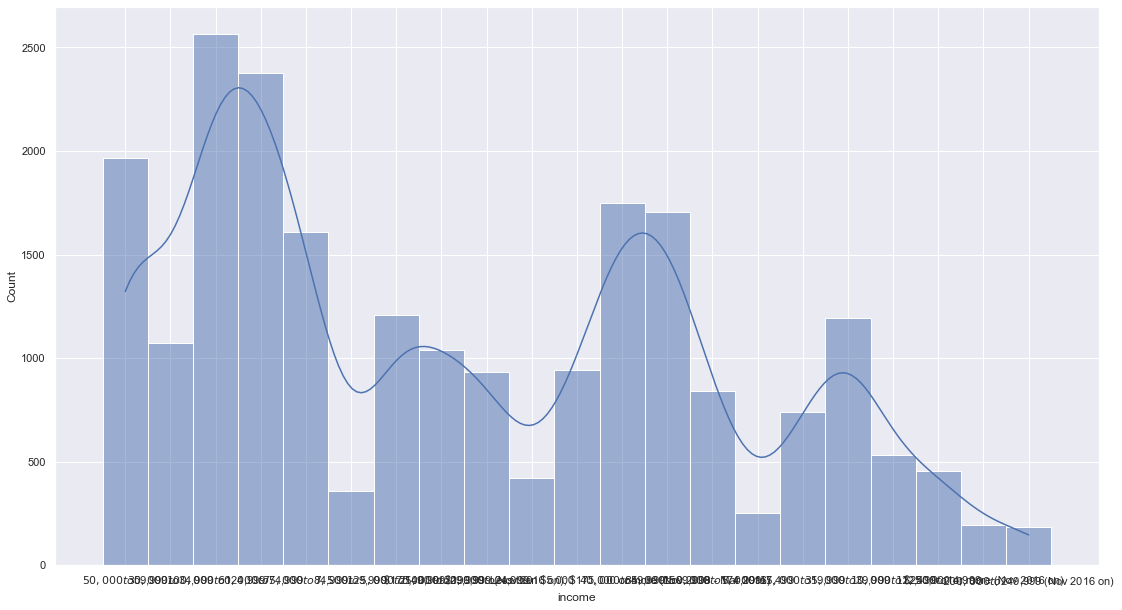

In [136]:
sns.histplot(data=df2, x = 'income', kde=True)

In [137]:
df2['income_category'].value_counts(normalize=True)

Less than $50,000     0.391586
$50,000 to $99,999    0.342806
$100,000 or more      0.265608
Name: income_category, dtype: float64

<AxesSubplot:xlabel='income_category', ylabel='Count'>

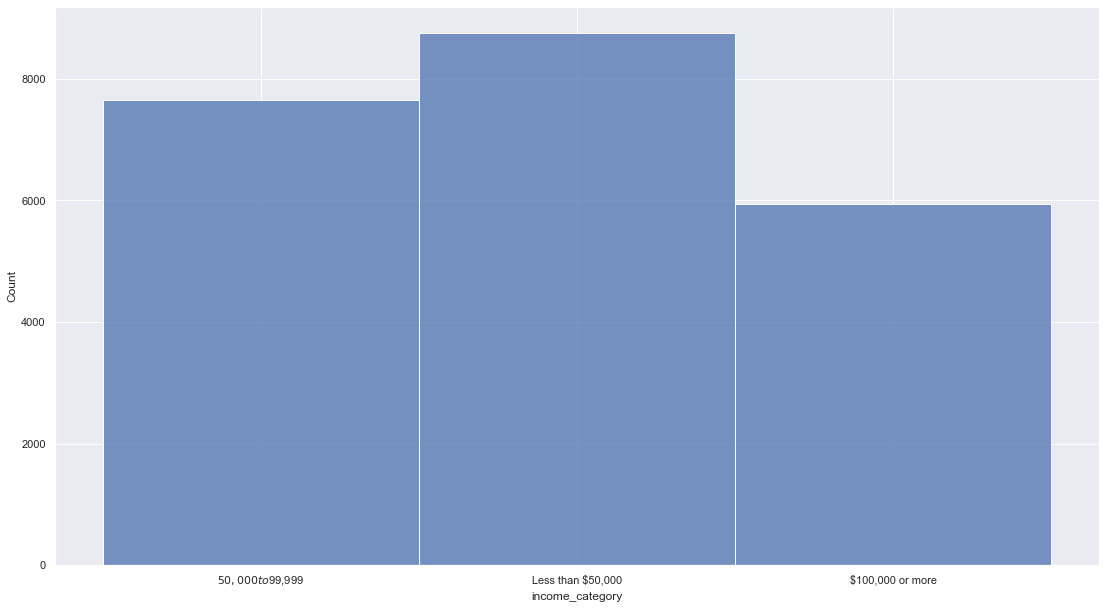

In [138]:
sns.histplot(data=df2, x = 'income_category')

In [139]:
df2['race'].value_counts(normalize=True)

White, Non-Hispanic    0.750817
Hispanic               0.099351
Black, Non-Hispanic    0.087402
Other, Non-Hispanic    0.062430
Name: race, dtype: float64

<AxesSubplot:xlabel='race', ylabel='Count'>

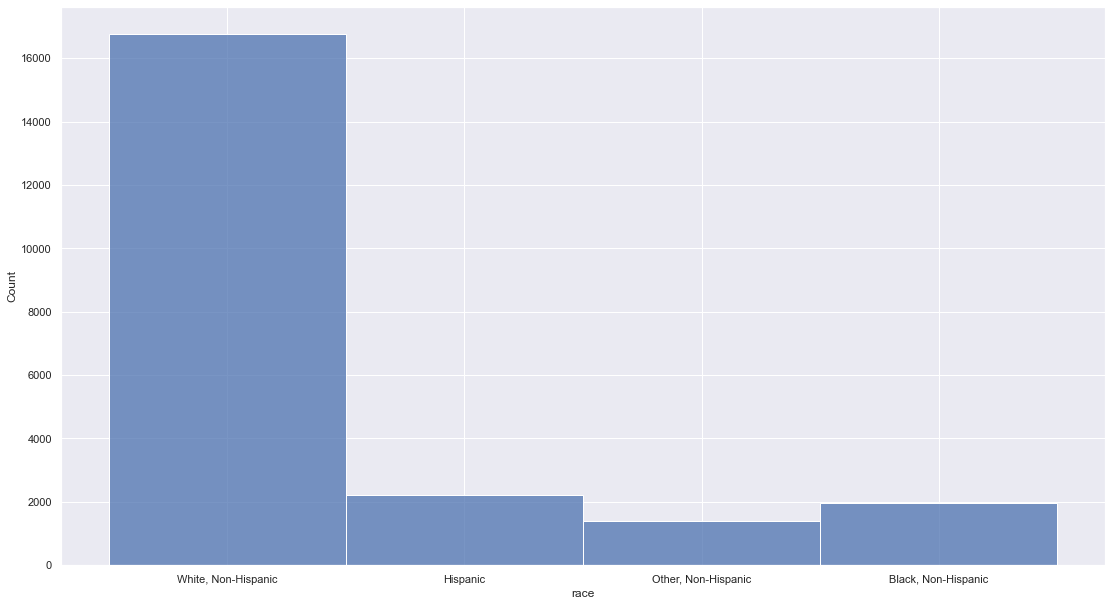

In [140]:
sns.histplot(data=df2, x = 'race')

In [141]:
df2['ideology'].value_counts(normalize=True)

Moderate, middle of the road    0.395480
Somewhat conservative           0.225554
Somewhat liberal                0.180488
Very conservative               0.109868
Very liberal                    0.069814
Refused                         0.018796
Name: ideology, dtype: float64

<AxesSubplot:xlabel='ideology', ylabel='Count'>

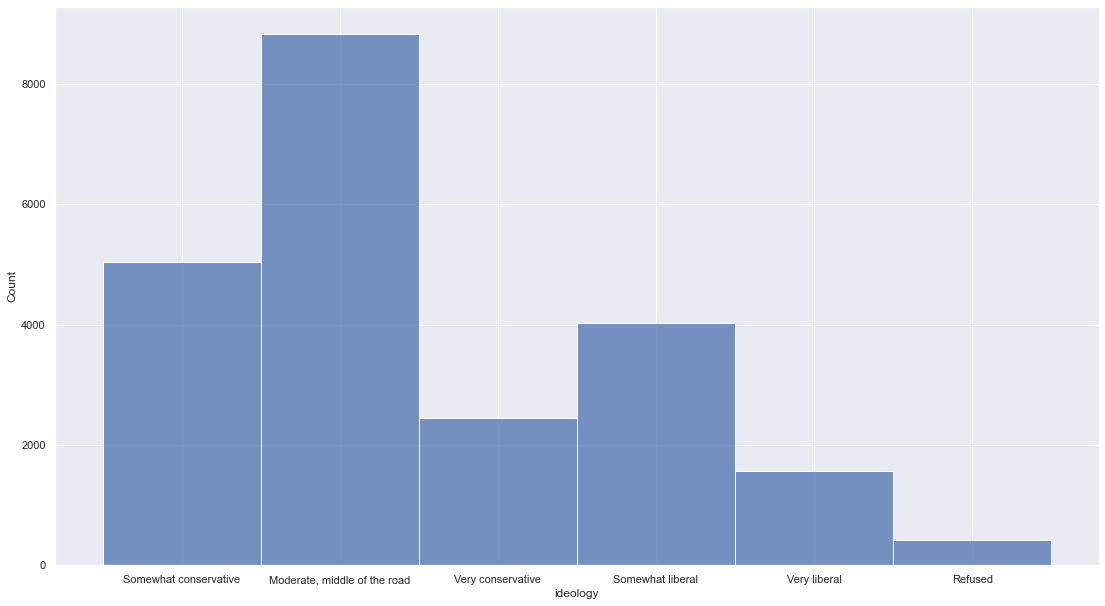

In [142]:
sns.histplot(data=df2, x = 'ideology')

In [143]:
df2['party'].value_counts(normalize=True)

Democrat                               0.331036
Republican                             0.271604
Independent                            0.250705
No party/not interested in politics    0.107988
Other; Please specify:                 0.029492
Refused                                0.009174
Name: party, dtype: float64

<AxesSubplot:xlabel='party', ylabel='Count'>

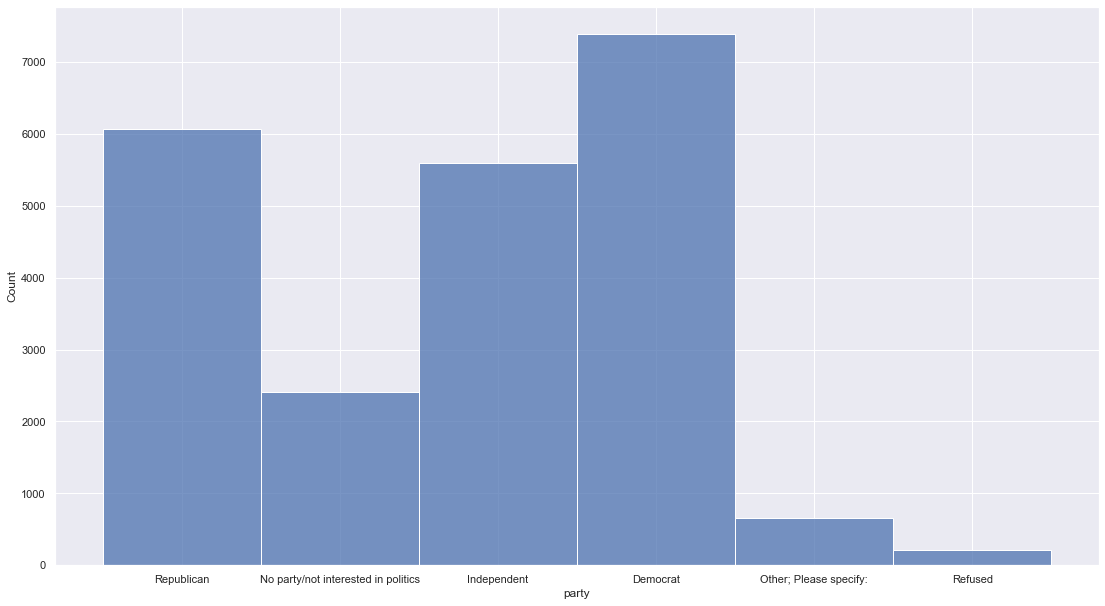

In [144]:
sns.histplot(data=df2, x = 'party')

In [145]:
df2['party_w_leaners'].value_counts(normalize=True)

Democrats                              0.413381
Republicans                            0.364780
No party/Not interested in politics    0.107988
Independent/Other                      0.104677
Refused                                0.009174
Name: party_w_leaners, dtype: float64

<AxesSubplot:xlabel='party_w_leaners', ylabel='Count'>

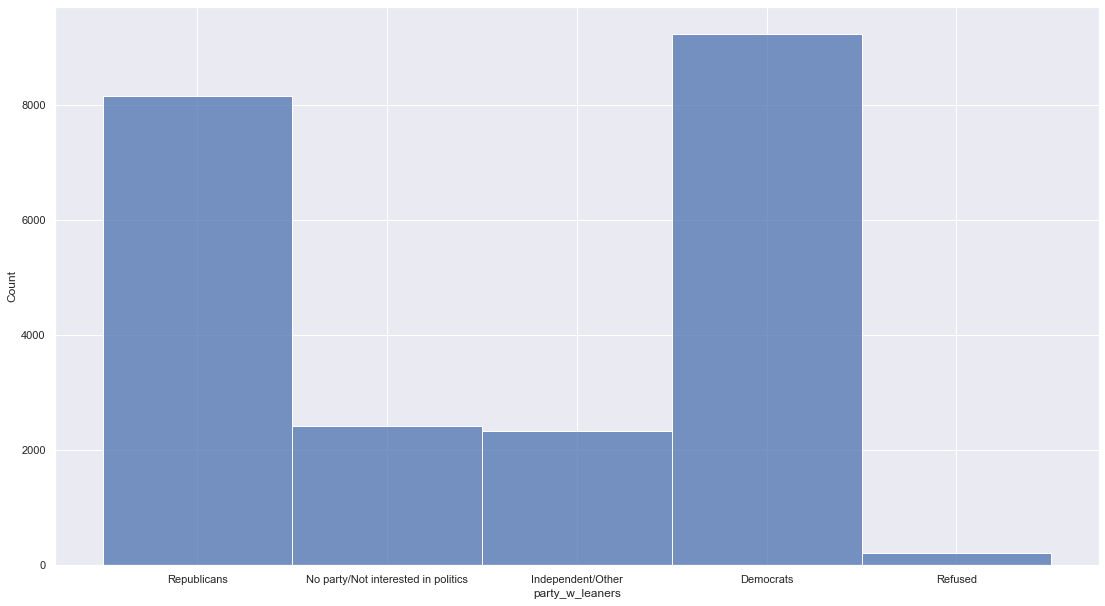

In [146]:
sns.histplot(data=df2, x = 'party_w_leaners')

In [147]:
df2['party_x_ideo'].value_counts(normalize=True)

Conservative Republican                0.245737
Moderate/Conservative Democrat         0.206892
Liberal Democrat                       0.203849
Liberal/Moderate Republican            0.117073
No Party/Not Interested in politics    0.107988
Independent (Non-Leaning)              0.104677
Refused                                0.013784
Name: party_x_ideo, dtype: float64

<AxesSubplot:xlabel='party_x_ideo', ylabel='Count'>

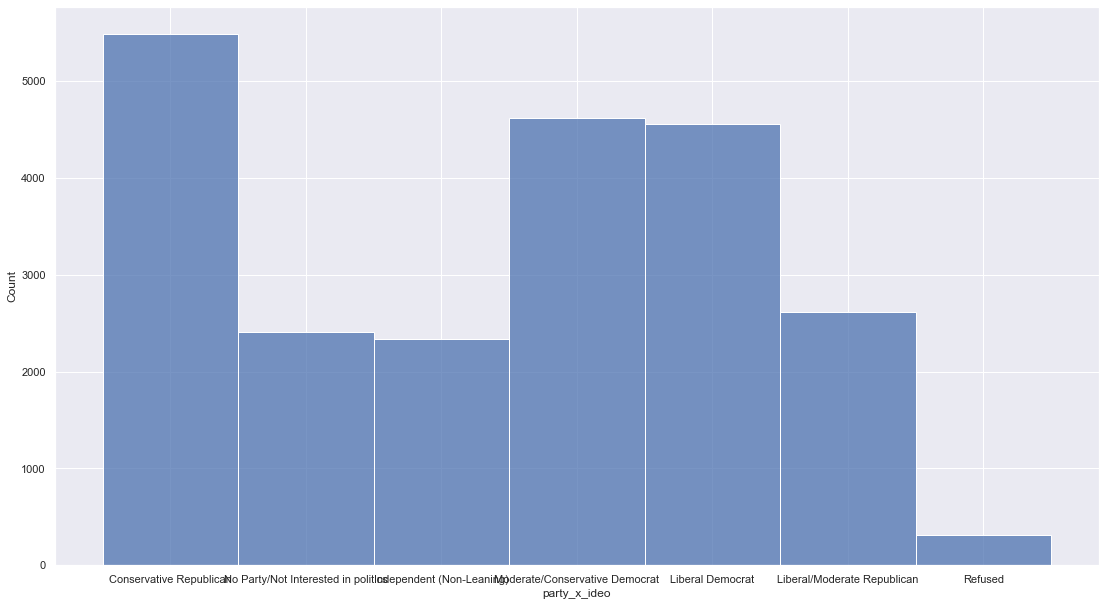

In [148]:
sns.histplot(data=df2, x = 'party_x_ideo')

In [149]:
df2['registered_voter'].value_counts(normalize=True)

Registered              0.842247
Not registered          0.100291
Prefer not to answer    0.026494
Don't know              0.015619
Refused                 0.008145
Not sure                0.007205
Name: registered_voter, dtype: float64

<AxesSubplot:xlabel='registered_voter', ylabel='Count'>

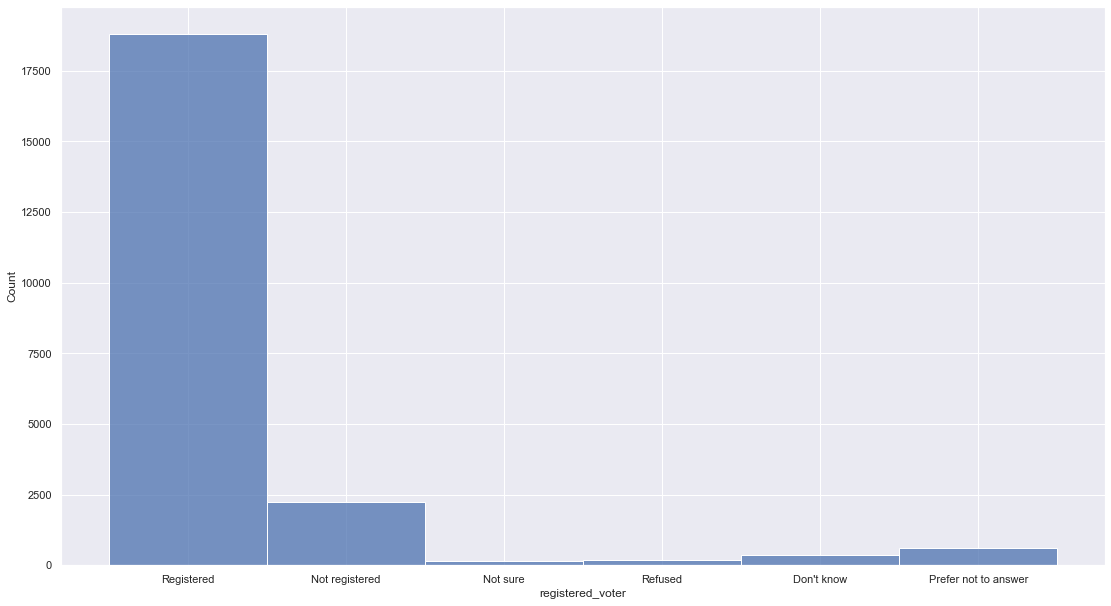

In [150]:
sns.histplot(data=df2, x = 'registered_voter')

In [151]:
df2['region9'].value_counts(normalize=True)

South Atlantic        0.193556
East-North Central    0.159723
Pacific               0.153905
Mid-Atlantic          0.134571
West-South Central    0.102260
West-North Central    0.077243
Mountain              0.075140
East-South Central    0.055359
New England           0.048243
Name: region9, dtype: float64

<AxesSubplot:xlabel='region9', ylabel='Count'>

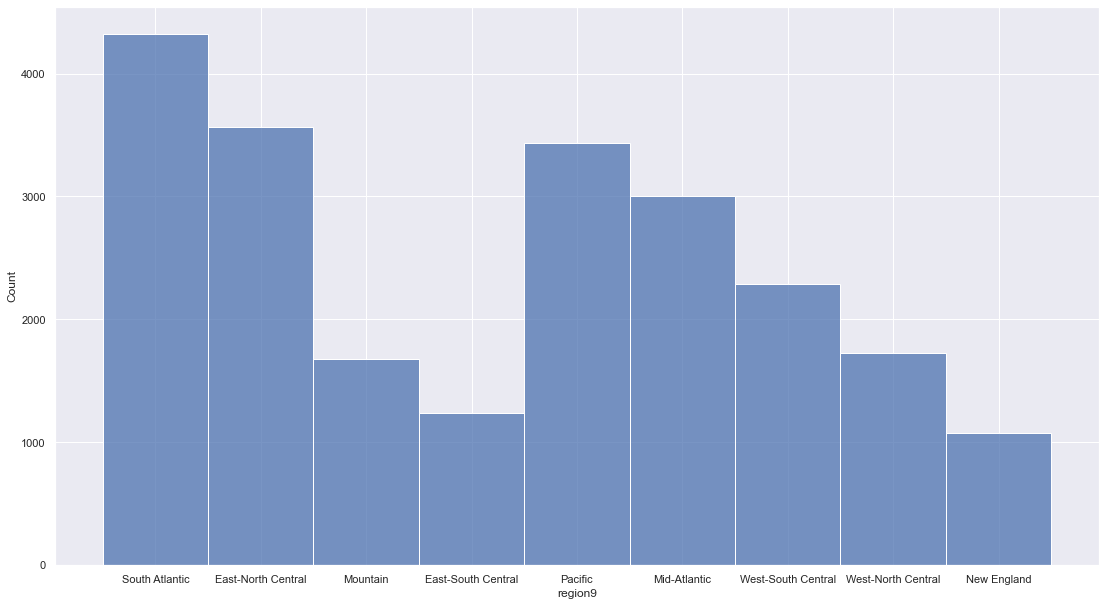

In [152]:
sns.histplot(data=df2, x = 'region9')

In [153]:
df2['region4'].value_counts(normalize=True)

South        0.351175
Midwest      0.236966
West         0.229045
Northeast    0.182815
Name: region4, dtype: float64

<AxesSubplot:xlabel='region4', ylabel='Count'>

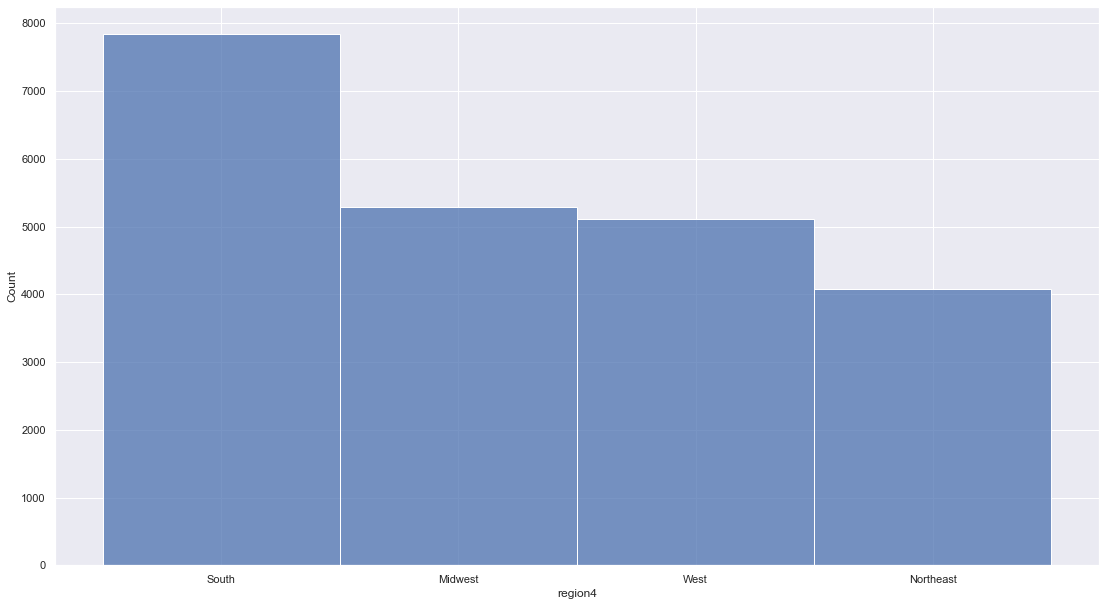

In [154]:
sns.histplot(data=df2, x = 'region4')

In [155]:
test_df = dummies.groupby('Yes').sum()

In [156]:
year_dum = pd.concat([df['year'], dummies], axis=1)

### Looking at responses for different categories for our features grouped by year to see changes over years

In [157]:
year_dum.groupby('year').sum()

generation_Baby Boomers (1946 - 1964)  \
year                                          
2008                                  837.0   
2010                                  783.0   
2011                                  769.0   
2012                                  849.0   
2013                                  794.0   
2014                                  944.0   
2015                                 1058.0   
2016                                 1022.0   
2017                                 1081.0   
2018                                  995.0   

      generation_Generation X (1965 - 1980)  \
year                                          
2008                                  544.0   
2010                                  697.0   
2011                                  497.0   
2012                                  472.0   
2013                                  402.0   
2014                                  541.0   
2015                                  579.0   
2016                                  518.0   
2017                                  577.0   
2018                                  558.0   

      generation_Greatest (Before 1928)  generation_Millennials (1981 - 1996)  \
year                                                                            
2008                               42.0                                 229.0   
2010                               17.0                                 263.0   
2011                               17.0                                 391.0   
2012                               20.0                                 382.0   
2013                               13.0                                 343.0   
2014                               17.0                                 464.0   
2015                                6.0                                 553.0   
2016                                8.0                                 502.0   
2017                                9.0                                 486.0   
2018                                5.0                                 490.0   

      generation_Silent (1928 - 1945)  generation_iGen‎/Gen Z (1997 - )  \
year                                                                      
2008                            503.0                               0.0   
2010                            255.0                               0.0   
2011                            304.0                               0.0   
2012                            337.0                               0.0   
2013                            315.0                               0.0   
2014                            320.0                               0.0   
2015                            356.0                              41.0   
2016                            320.0                              60.0   
2017                            317.0                             100.0   
2018                            263.0                              80.0   

      educ_10th grade  educ_11th grade  educ_12th grade no diploma  \
year                                                                 
2008             34.0             40.0                        54.0   
2010             50.0             51.0                        65.0   
2011             21.0             57.0                        48.0   
2012             29.0             42.0                        46.0   
2013             26.0             27.0                        42.0   
2014             23.0             47.0                        54.0   
2015             47.0             53.0                        60.0   
2016             32.0             46.0                        42.0   
2017             28.0             54.0                        45.0   
2018             28.0             30.0                        38.0   

      educ_1st, 2nd, 3rd, or 4th grade  ...  region9_South Atlantic  \
year                                    ...                           
2008               

### Creating a basic random forest model using only the features we have been working with

In [158]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=620,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, s.mean(), 2 * s.std()))

In [159]:
rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 150,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 100,
                            random_state=620)


In [160]:
X = dummies.drop(['Yes', 'No', "Don't know"], axis=1)
y = dummies['Yes']


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 620)

In [161]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=0.1, n_estimators=150,
                       n_jobs=-1, random_state=620)

In [162]:
score(rf, 'RF', X_train, y_train)

RF Score: 0.72 +- 0.017


In [163]:
score(rf, 'RF', X_test, y_test)

RF Score: 0.73 +- 0.033


In [164]:
score(rf, 'RF', X, y)

RF Score: 0.72 +- 0.021


In [165]:
feat_imp = pd.DataFrame({'Variable':X.columns,
                            'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)


### Getting the feature importances for basic random forest model

In [166]:
feat_imp

Variable  Importance
64             party_w_leaners_Democrats    0.167744
69  party_x_ideo_Conservative Republican    0.162065
68           party_w_leaners_Republicans    0.104120
71         party_x_ideo_Liberal Democrat    0.090905
56            ideology_Very conservative    0.081921
..                                   ...         ...
27           income_$125,000 to $149,999    0.000045
13               educ_Associate's degree    0.000045
9       educ_1st, 2nd, 3rd, or 4th grade    0.000027
85                      region9_Mountain    0.000000
40             income_$60,000 to $74,999    0.000000

[95 rows x 2 columns]

In [167]:
def stackplot(group, title, Xaxis):
    fig, ax = plt.subplots(figsize=(10, 10))

    df.groupby(group)['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)

    ax.set_title(title, 
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(Xaxis, weight='bold', labelpad=20)


    for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2
        ax.text(label_x, label_y, label_text, ha='center', va='center')
    ;


### Stacked bar plots normalized to see belief in climate change per feature

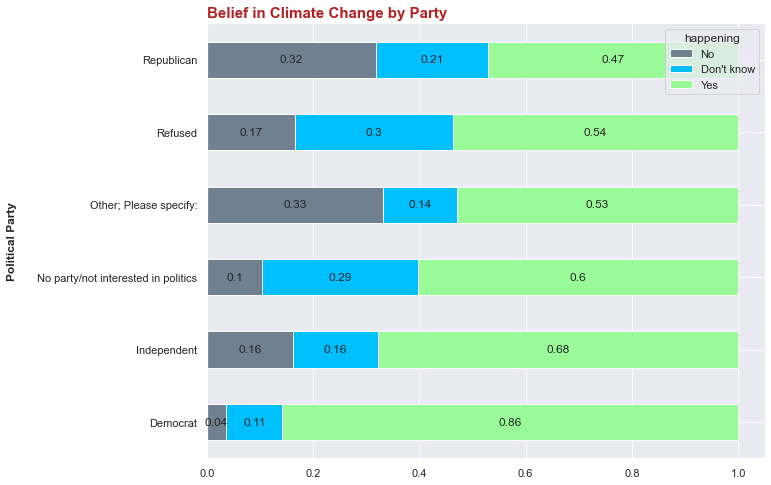

In [168]:
stackplot('party', 'Belief in Climate Change by Party', 'Political Party')

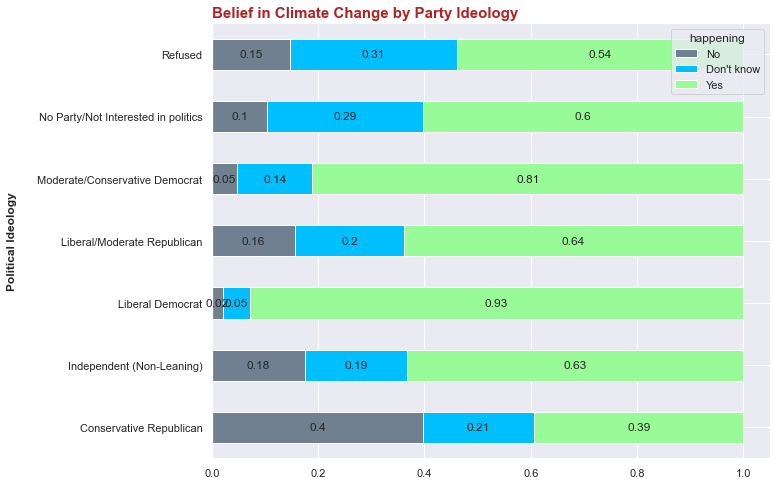

In [169]:
stackplot('party_x_ideo', 'Belief in Climate Change by Party Ideology', 'Political Ideology')

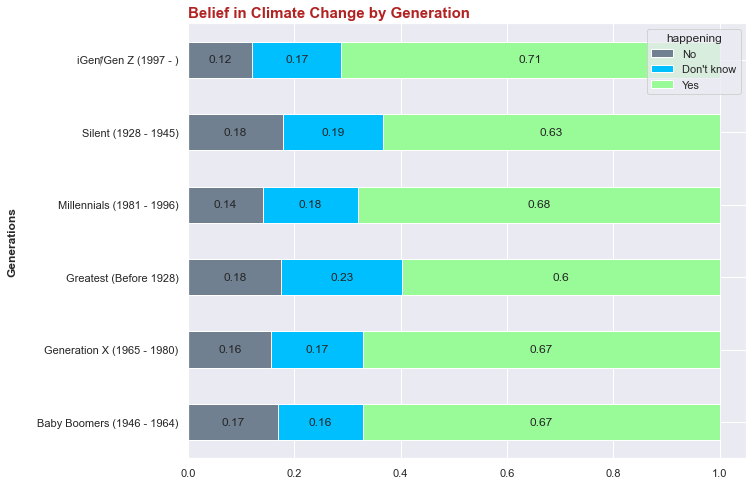

In [170]:
stackplot('generation', 'Belief in Climate Change by Generation', 'Generations')

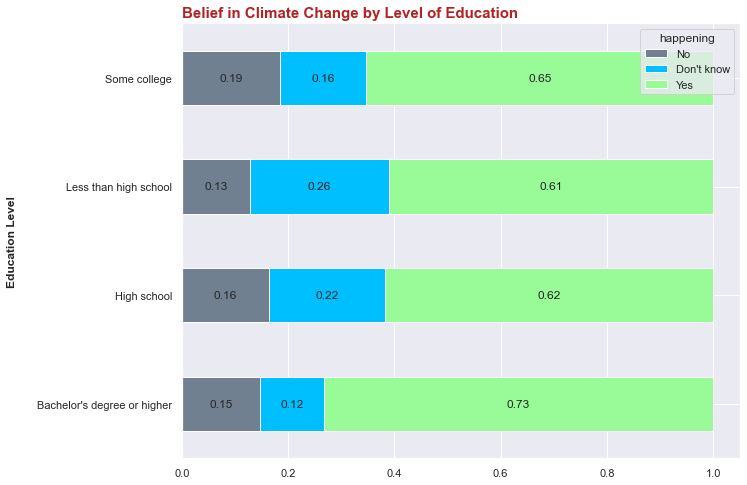

In [171]:
stackplot('educ_category', 'Belief in Climate Change by Level of Education', 'Education Level')

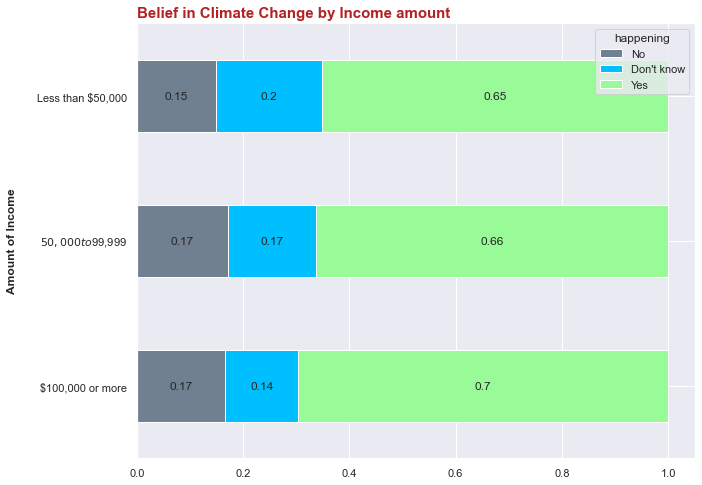

In [172]:
stackplot('income_category', 'Belief in Climate Change by Income amount', 'Amount of Income')

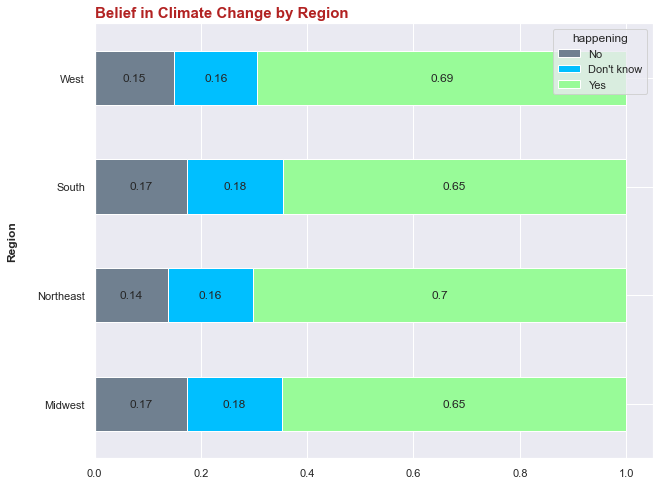

In [173]:
stackplot('region4', 'Belief in Climate Change by Region', 'Region')

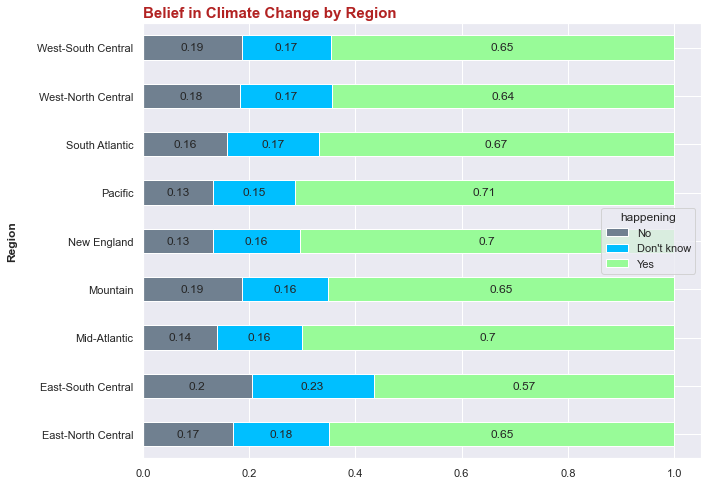

In [174]:
stackplot('region9', 'Belief in Climate Change by Region', 'Region')

### Recommendations for features to use in modeling

 * It appears that the group of people that feel most strongly about whether or not global warming is happening appears to be politically affiliated. We see the strongest change between majority 'yes' or majority 'no' to weather global warming is happening is seen with people affiliated with the Democratic and Republican party respectively as well as differing ideologies. 

* Education and income have been grouped in categories that are more normally distributed and will be useful for use in modeling.


* There is some variation in belief of global warming depending on the generation they were born in. It would be good to use this feature within our model.


* Region4 is an aggregated feature based on region9 locations. The more normalized region4 would be a good feature to use in the model as well

### Most interesting features:


- generation
- educ_category
- income_category
- party
- party_x_ideo
- region4

In [175]:
# ordinal_feat = df[['generation', 'educ_category', 'income_category']]
# nom_feat = df[['party', 'party_x_ideo', 'region4']]

In [176]:
# gen_lst = ['Greatest (Before 1928)','Silent (1928 - 1945)','Baby Boomers (1946 - 1964)',
#                                     'Generation X (1965 - 1980)','Millennials (1981 - 1996)',
#                                     'iGen\u200e/Gen Z (1997 - )']
# educ_lst = ['Less than high school','High school','Some college',
#                                      "Bachelor's degree or higher"]
# inc_lst = ['Less than $50,000', '$50,000 to $99,999', '$100,000 or more']


# ordinal = OrdinalEncoder(categories=[gen_lst, educ_lst, inc_lst],dtype=np.str_)



# ordinal_feat = ordinal.fit_transform(ordinal_feat)

In [177]:
df.drop(['educ', 'income', 'race', 'ideology', 'party_w_leaners',
         'registered_voter', 'region9'],
       axis = 1,
       inplace=True)

Drop the columns that are uninteresting.

## Saba

In [178]:
df.religion.value_counts(normalize=True)

Catholic                                                           0.228284
Protestant (e.g., Methodist, Lutheran, Presbyterian, Episcopal)    0.212799
None of the Above (Apr 2014 on); None (Nov 2008 - Dec 2013)        0.137212
Baptist - any denomination                                         0.136138
Other Christian                                                    0.113806
Pentecostal                                                        0.028776
Agnostic (Apr 2014 on)                                             0.028239
Atheist (Apr 2014 on)                                              0.027210
Jewish                                                             0.023450
Mormon                                                             0.017498
Other - non-Christian (Please specify)                             0.017409
Refused                                                            0.012352
Buddhist                                                           0.006489
Hindu       

**These values represent the identified religions in the survey**

In [179]:
df[df['year']=='2014']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [180]:
df[df['year']=='2013']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [181]:
df[df['year']=='2015']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [182]:
df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T

happening                                                 No  Don't know  \
religion                                                                   
Agnostic (Apr 2014 on)                              0.071315    0.074485   
Atheist (Apr 2014 on)                               0.065789    0.060855   
Baptist - any denomination                          0.207101    0.206772   
Buddhist                                            0.096552    0.096552   
Catholic                                            0.141541    0.159381   
Eastern Orthodox                                    0.150685    0.123288   
Hindu                                               0.044944    0.112360   
Jewish                                              0.125954    0.097328   
Mormon                                              0.273657    0.189258   
Muslim                                              0.086957    0.144928   
None of the Above (Apr 2014 on); None (Nov 2008...  0.106980    0.178082   
Other - non-Christian (Please specify)              0.105398    0.123393   
Other Christian                                     0.209988    0.195045   
Pentecostal                                         0.250389    0.209953   
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.179390    0.171188   
Refused                                             0.181159    0.307971   

happening                                                Yes  
religion                                                      
Agnostic (Apr 2014 on)                              0.854200  
Atheist (Apr 2014 on)                               0.873355  
Baptist - any denomination                          0.586128  
Buddhist                                            0.806897  
Catholic                                            0.699079  
Eastern Orthodox                                    0.726027  
Hindu                                               0.842697  
Jewish                                              0.776718  
Mormon                                              0.537084  
Muslim                                              0.768116  
None of the Above (Apr 2014 on); None (Nov 2008...  0.714938  
Other - non-Christian (Please specify)              0.771208  
Other Christian                                     0.594967  
Pentecostal                                         0.539658  
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.649422  
Refused                                             0.510870

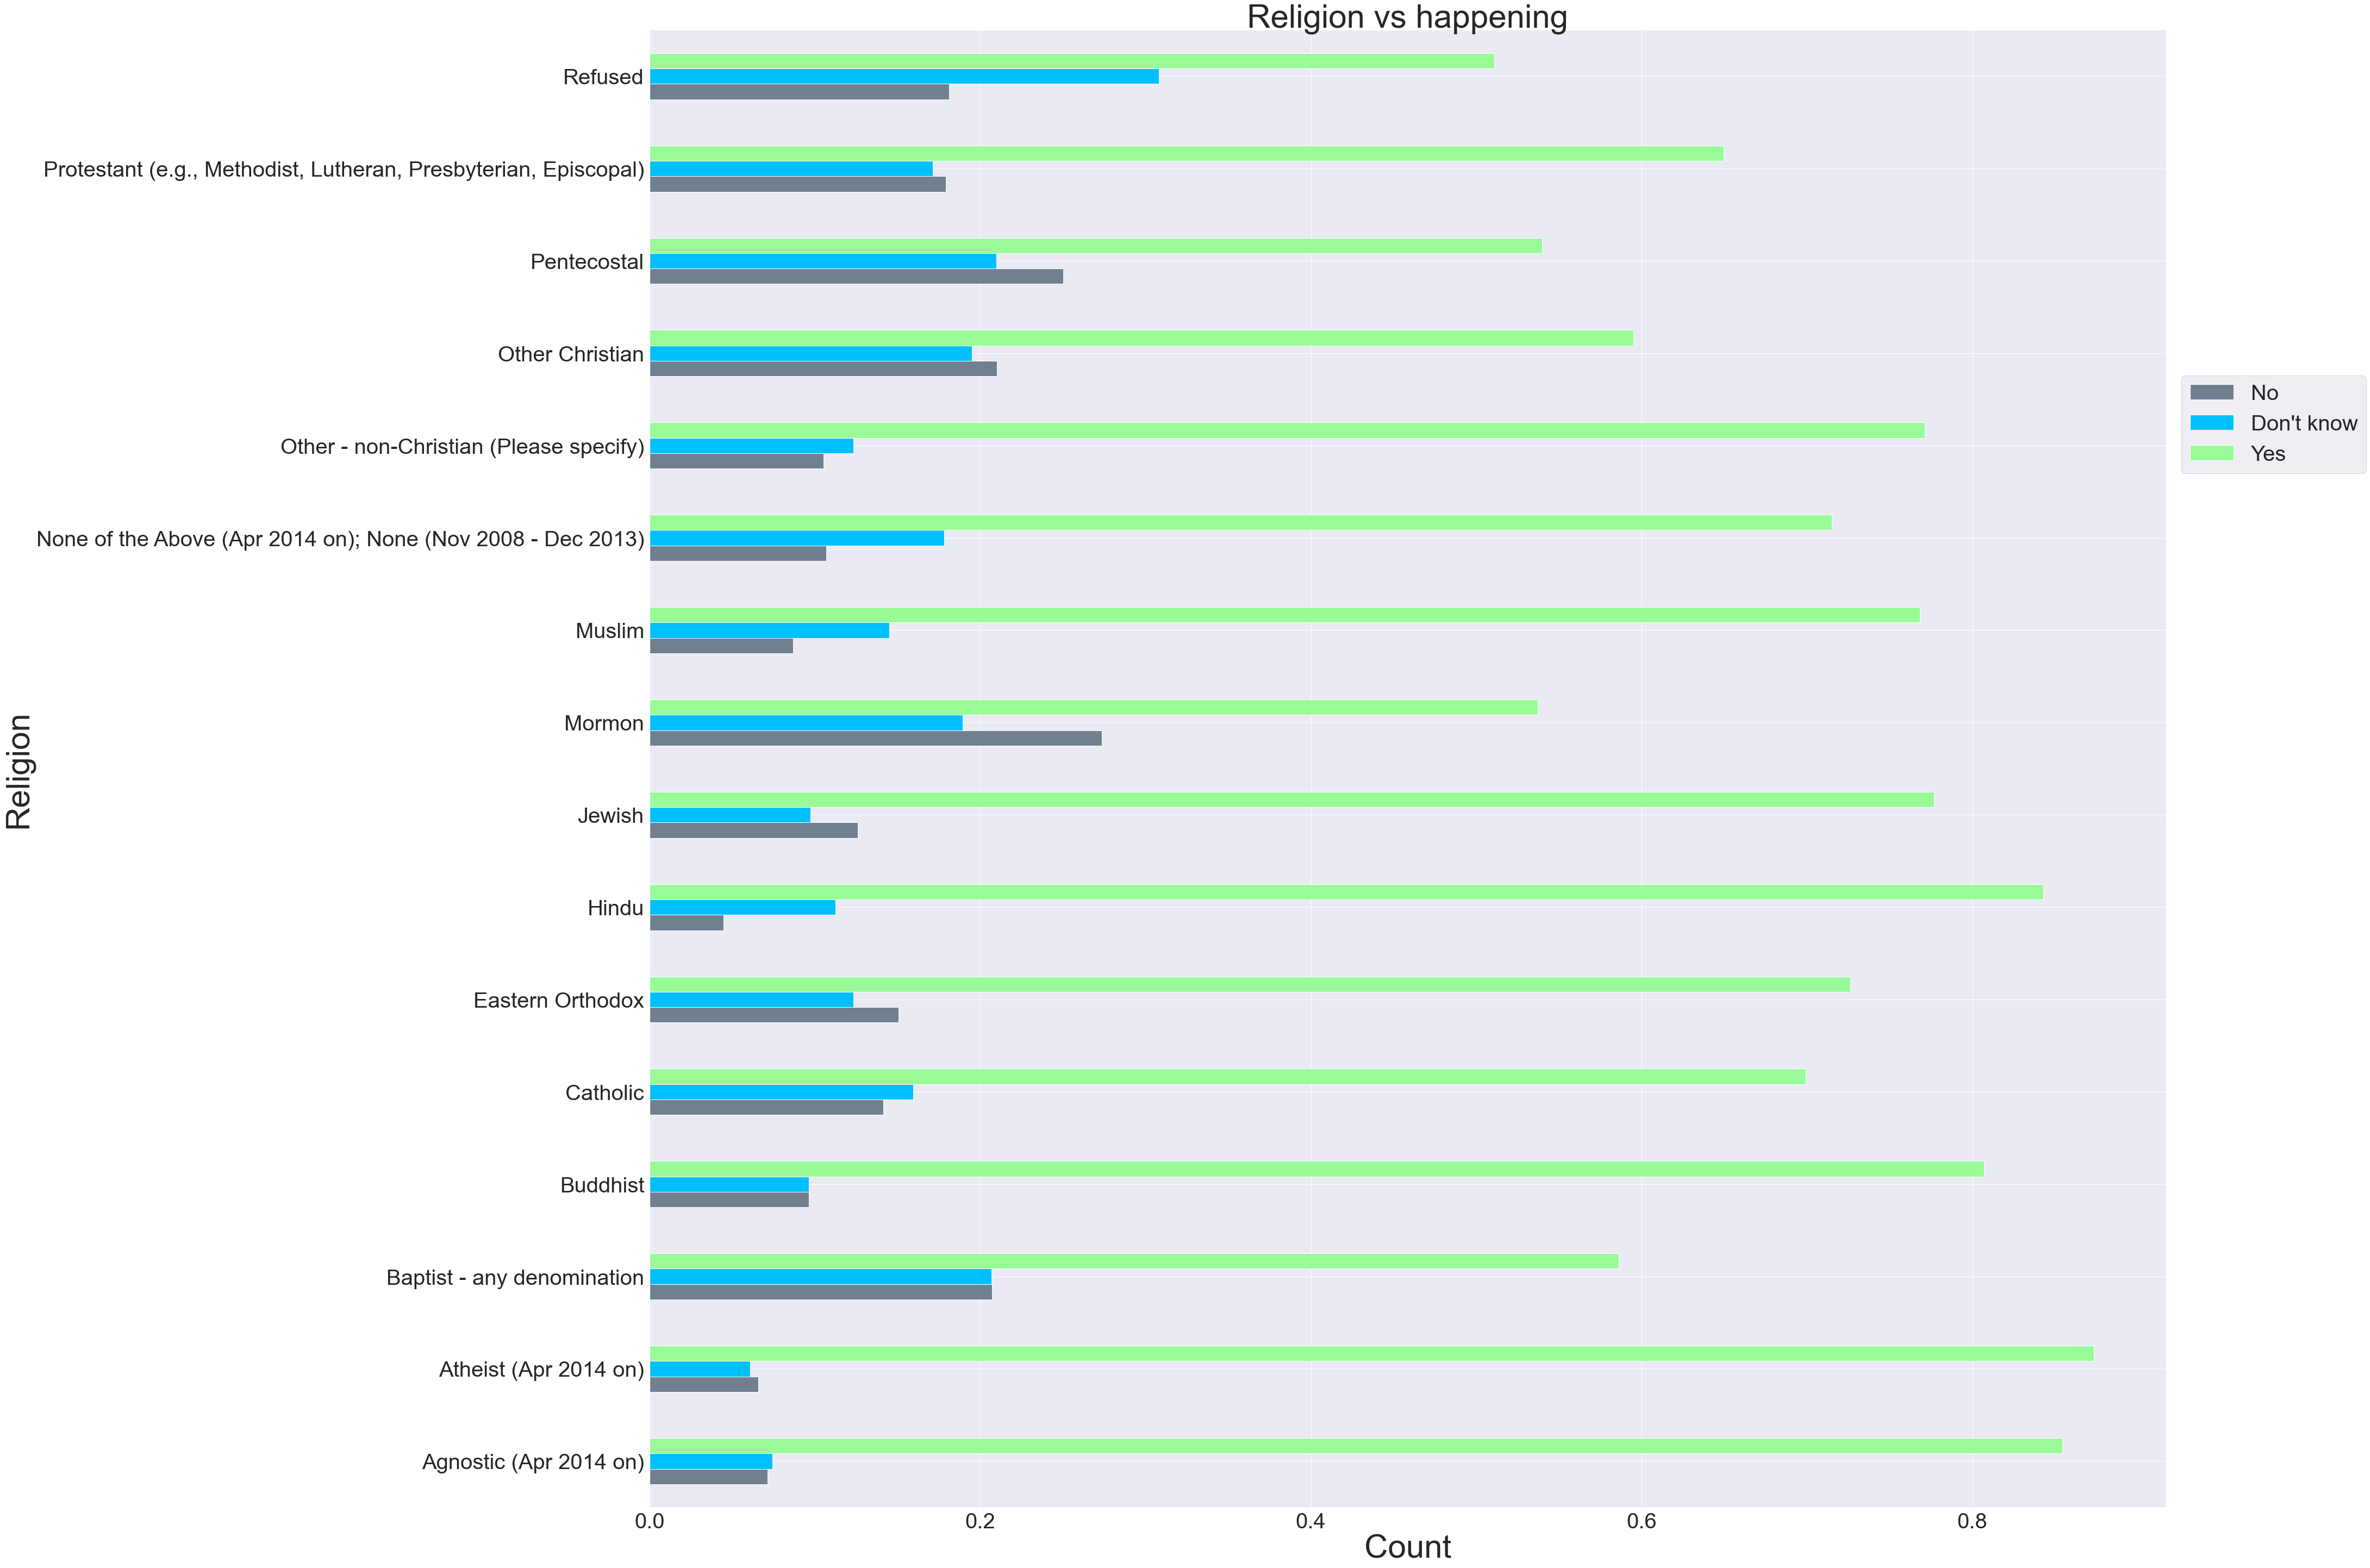

In [183]:
ax = df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **This graph represents the distribution of`happening` across various religions.**
- **Largely people across all religions accept that climate change is happening. Baptist seem to have a large proportion of people not accepting climate change**

In [184]:
list(df.religion_other_nonchristian.unique())

[nan,
 'Unitarian',
 "Spiritual but don't attend church",
 'Spiritual',
 'native american',
 'Unitarian Universalist',
 'Deist',
 'Pagan',
 'God Loving',
 'Wiccan',
 'nature-based',
 'baptist',
 'Eclectic Spiritualist',
 'Spiritual not religious',
 'Just',
 'Shaman',
 'Unitarian-Universalist',
 'Prefer not say',
 'Jw',
 '"Believer"',
 'Pagan/Shamanic Witch',
 'Spiritualist',
 'Church of Christ',
 'prefer not to state',
 'NO RELIGION',
 'none of your bee wax',
 'evangelical',
 'female ancestor worship',
 'Non denominational',
 'unitarian  SRF',
 'born again',
 'apostolic',
 'unitarian universalist',
 'Non-denominationa',
 'Jesus',
 'SEVENTH DAY  ADVENTIST',
 'Sikh',
 'Anabaptist',
 'spiritual',
 'Human',
 'science',
 'Dystheist',
 'Taoist',
 'no denomanation',
 'G',
 'Agnostic Atheist',
 'Jehovah’s witness',
 'Native American truths',
 "I'm a Christian",
 'Heathen',
 'Love and Compassion',
 'Christian',
 'Quaker',
 'Jehovah’s Witness',
 'pagan',
 'Unitarianism',
 'NOYB',
 'LOVEBIBLELIGH

**This is user filled column so a lot of typos are being seen, since we have religion and attendance data we might drop this column**

In [185]:
df.evangelical.value_counts(normalize=True)

No            0.656344
Yes           0.248512
Don't Know    0.083195
Refused       0.011949
Name: evangelical, dtype: float64

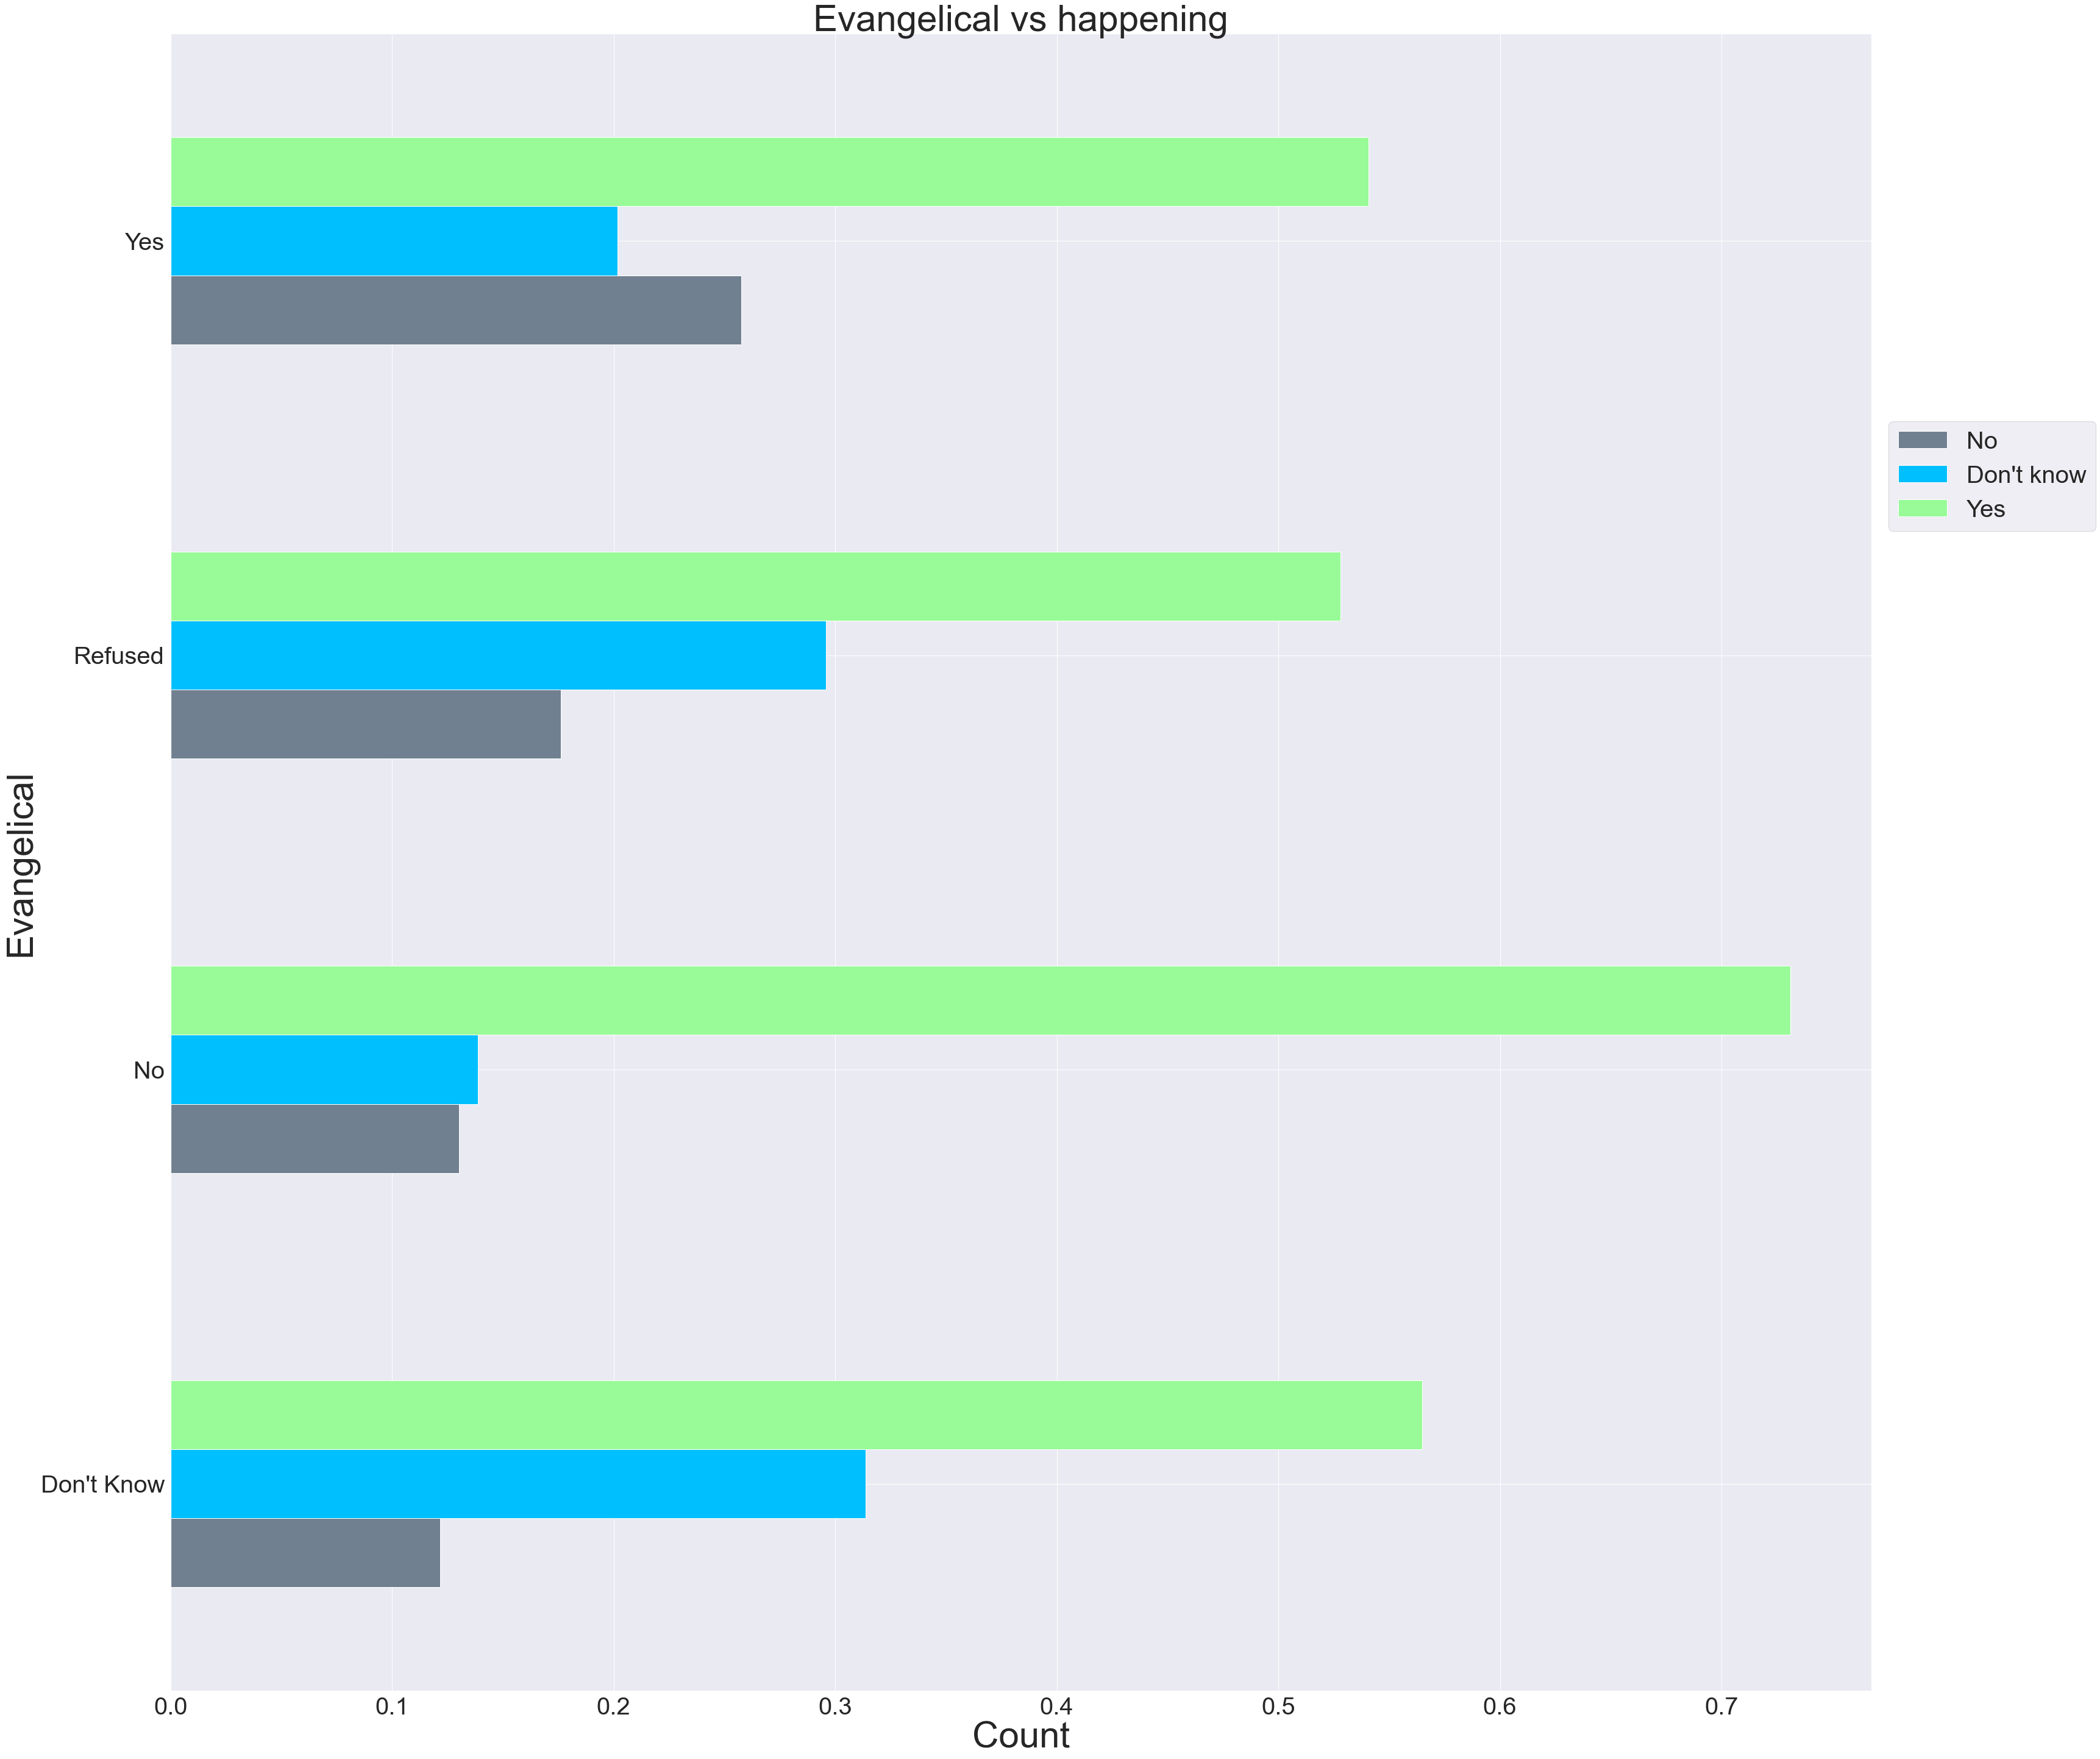

In [186]:
ax = df.groupby('evangelical')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Evangelical',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Evangelical vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who said Yes to being evangelical or refused to answer whether they are evangelical have a higher proportion of people not accepting climate change**

In [187]:
df.service_attendance.value_counts(normalize=True)

Never                    0.248333
Once a week              0.215708
Once a year or less      0.177400
A few times a year       0.165451
More than once a week    0.102036
Once or twice a month    0.078004
Refused                  0.013068
Name: service_attendance, dtype: float64

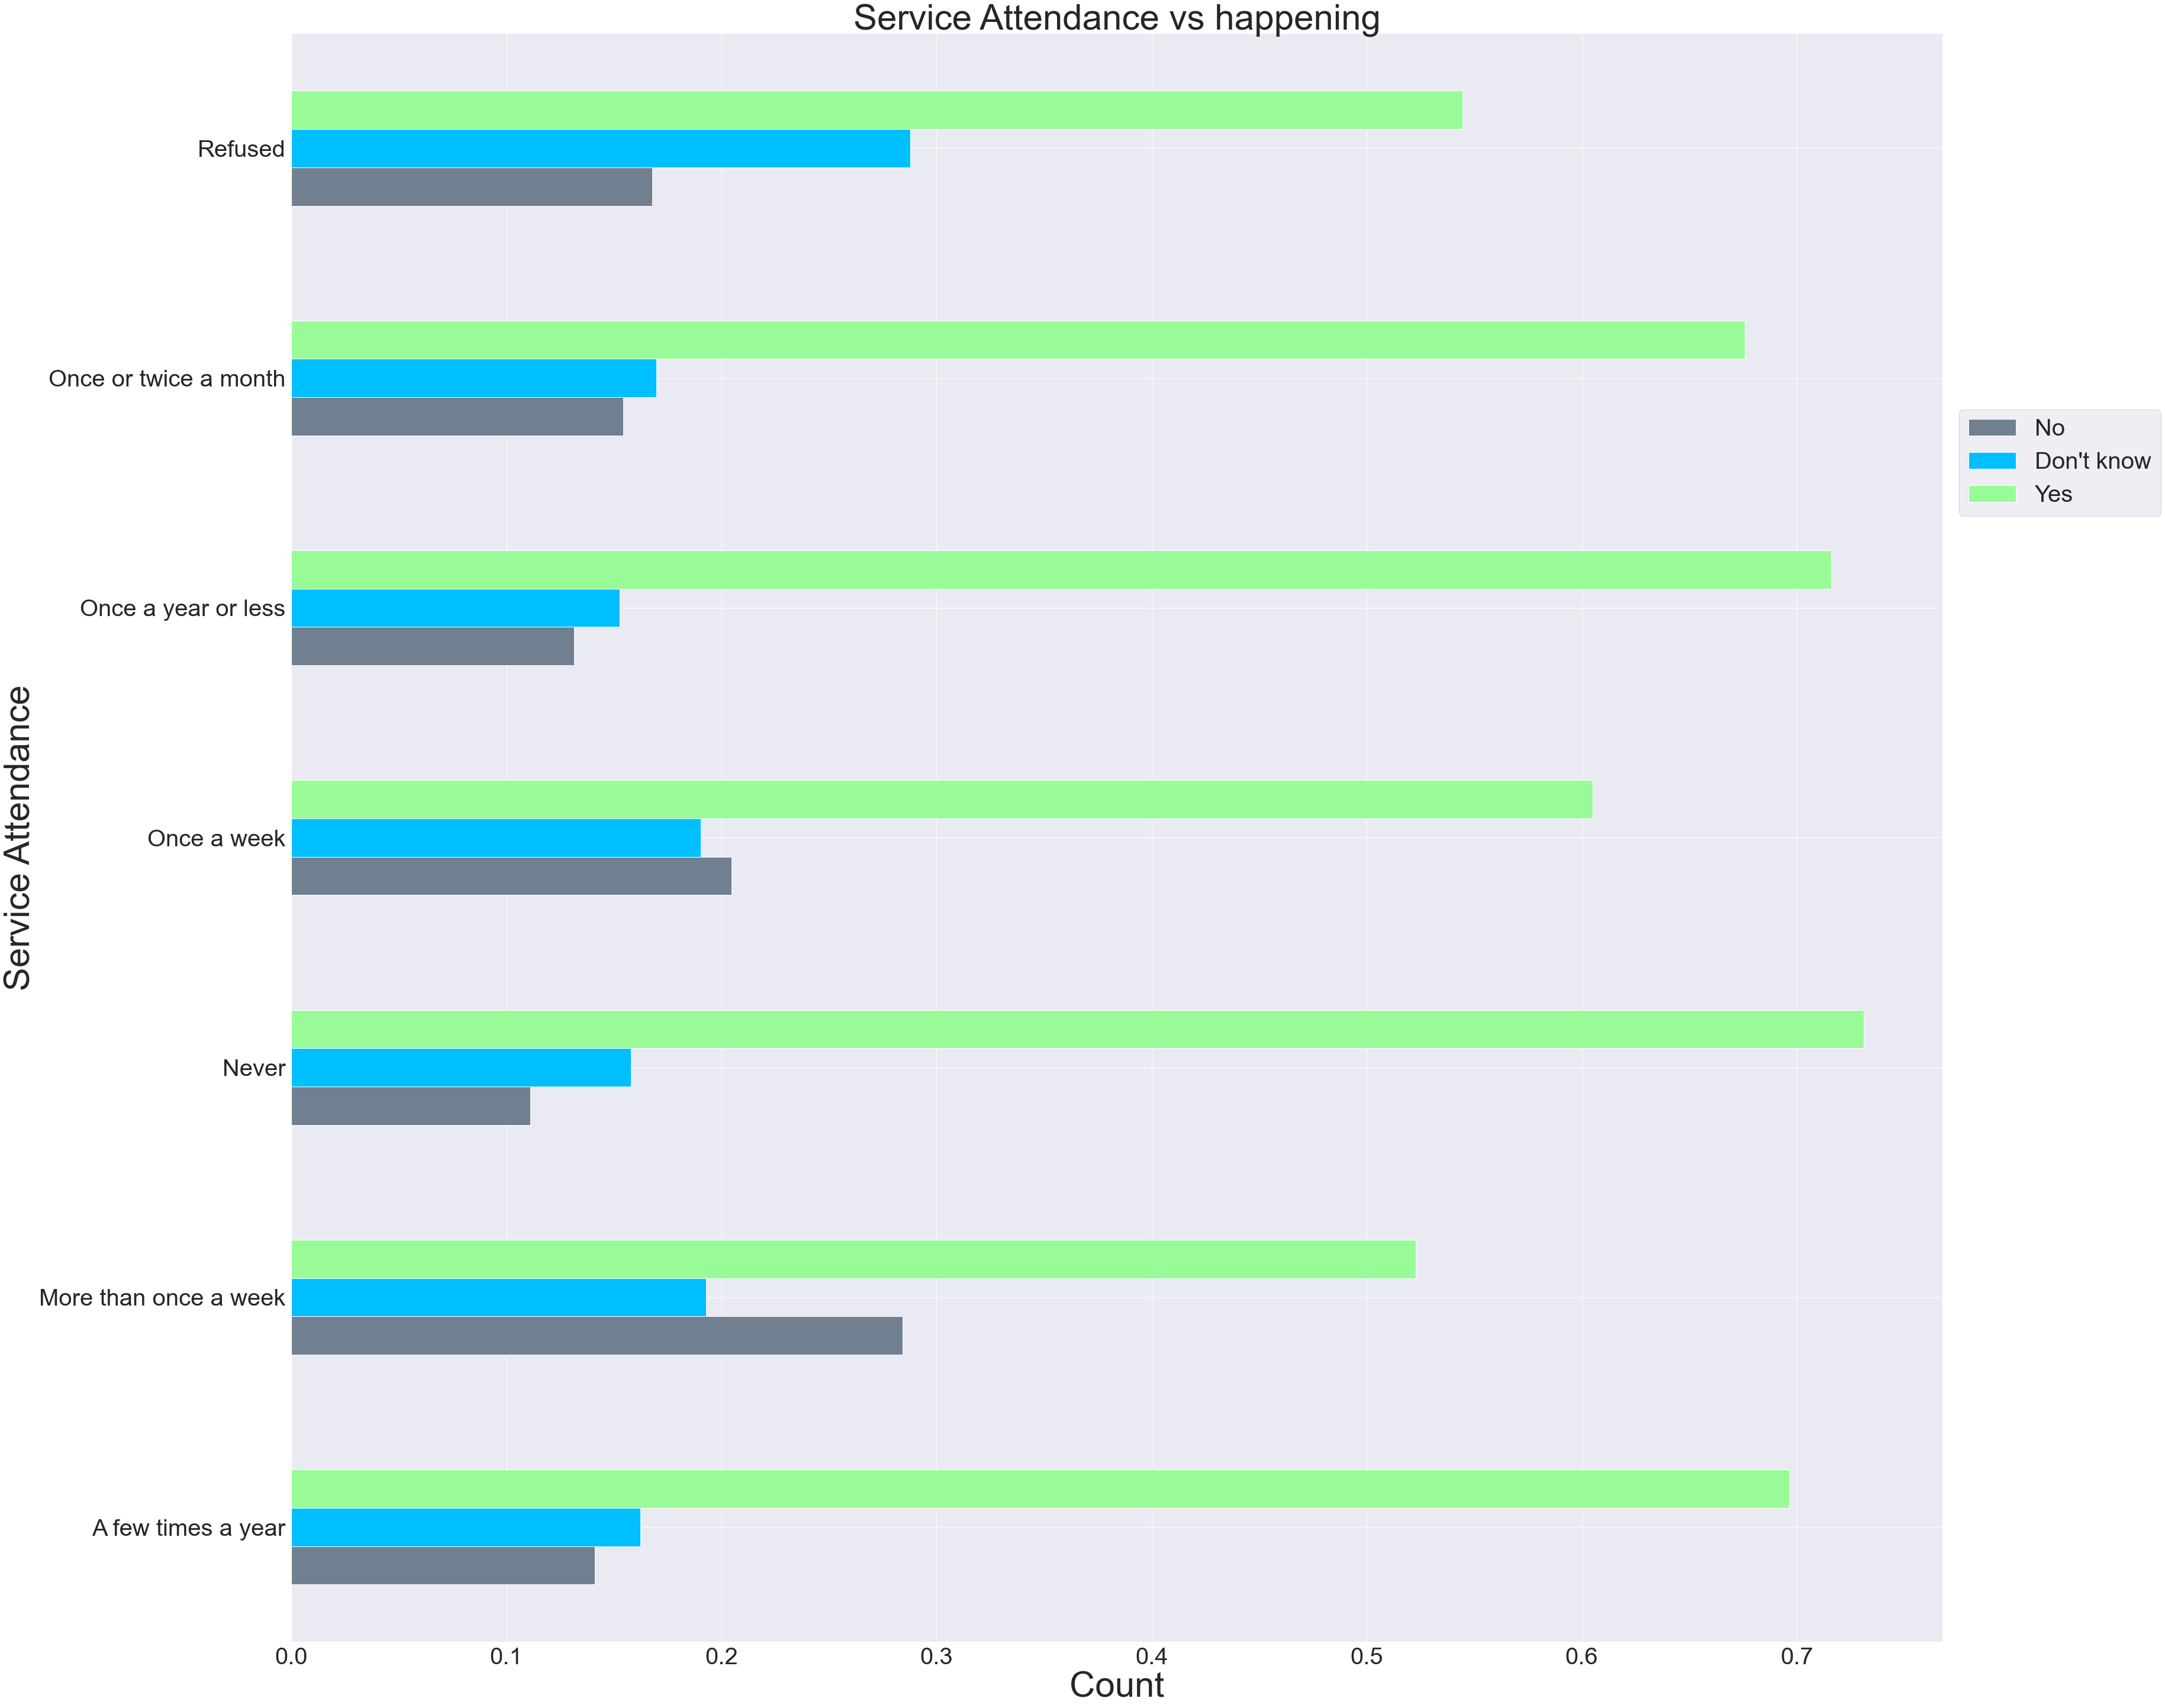

In [188]:
ax = df.groupby('service_attendance')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Service Attendance vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who go for service attendance for more than once a week and once a week have a higher proportion of people refusing to believe in climate change compared to all people in that particular label of service attendance**

In [189]:
#mapping values to the ordinal variable representing religiosity
service_attendance_di = {'Never': 1,
                   'Once a week': 5,
                   'Once a year or less': 2,
                   'A few times a year': 3,
                   'More than once a week':6,
                   'Once or twice a month':4,
                   'Refused':-1,
                        }
df.service_attendance= df['service_attendance'].map(lambda x: service_attendance_di[x])


In [190]:
df.marit_status.value_counts(normalize=True)

Married                0.580712
Never married          0.183620
Divorced               0.107675
Living with partner    0.060819
Widowed                0.050392
Separated              0.016782
Name: marit_status, dtype: float64

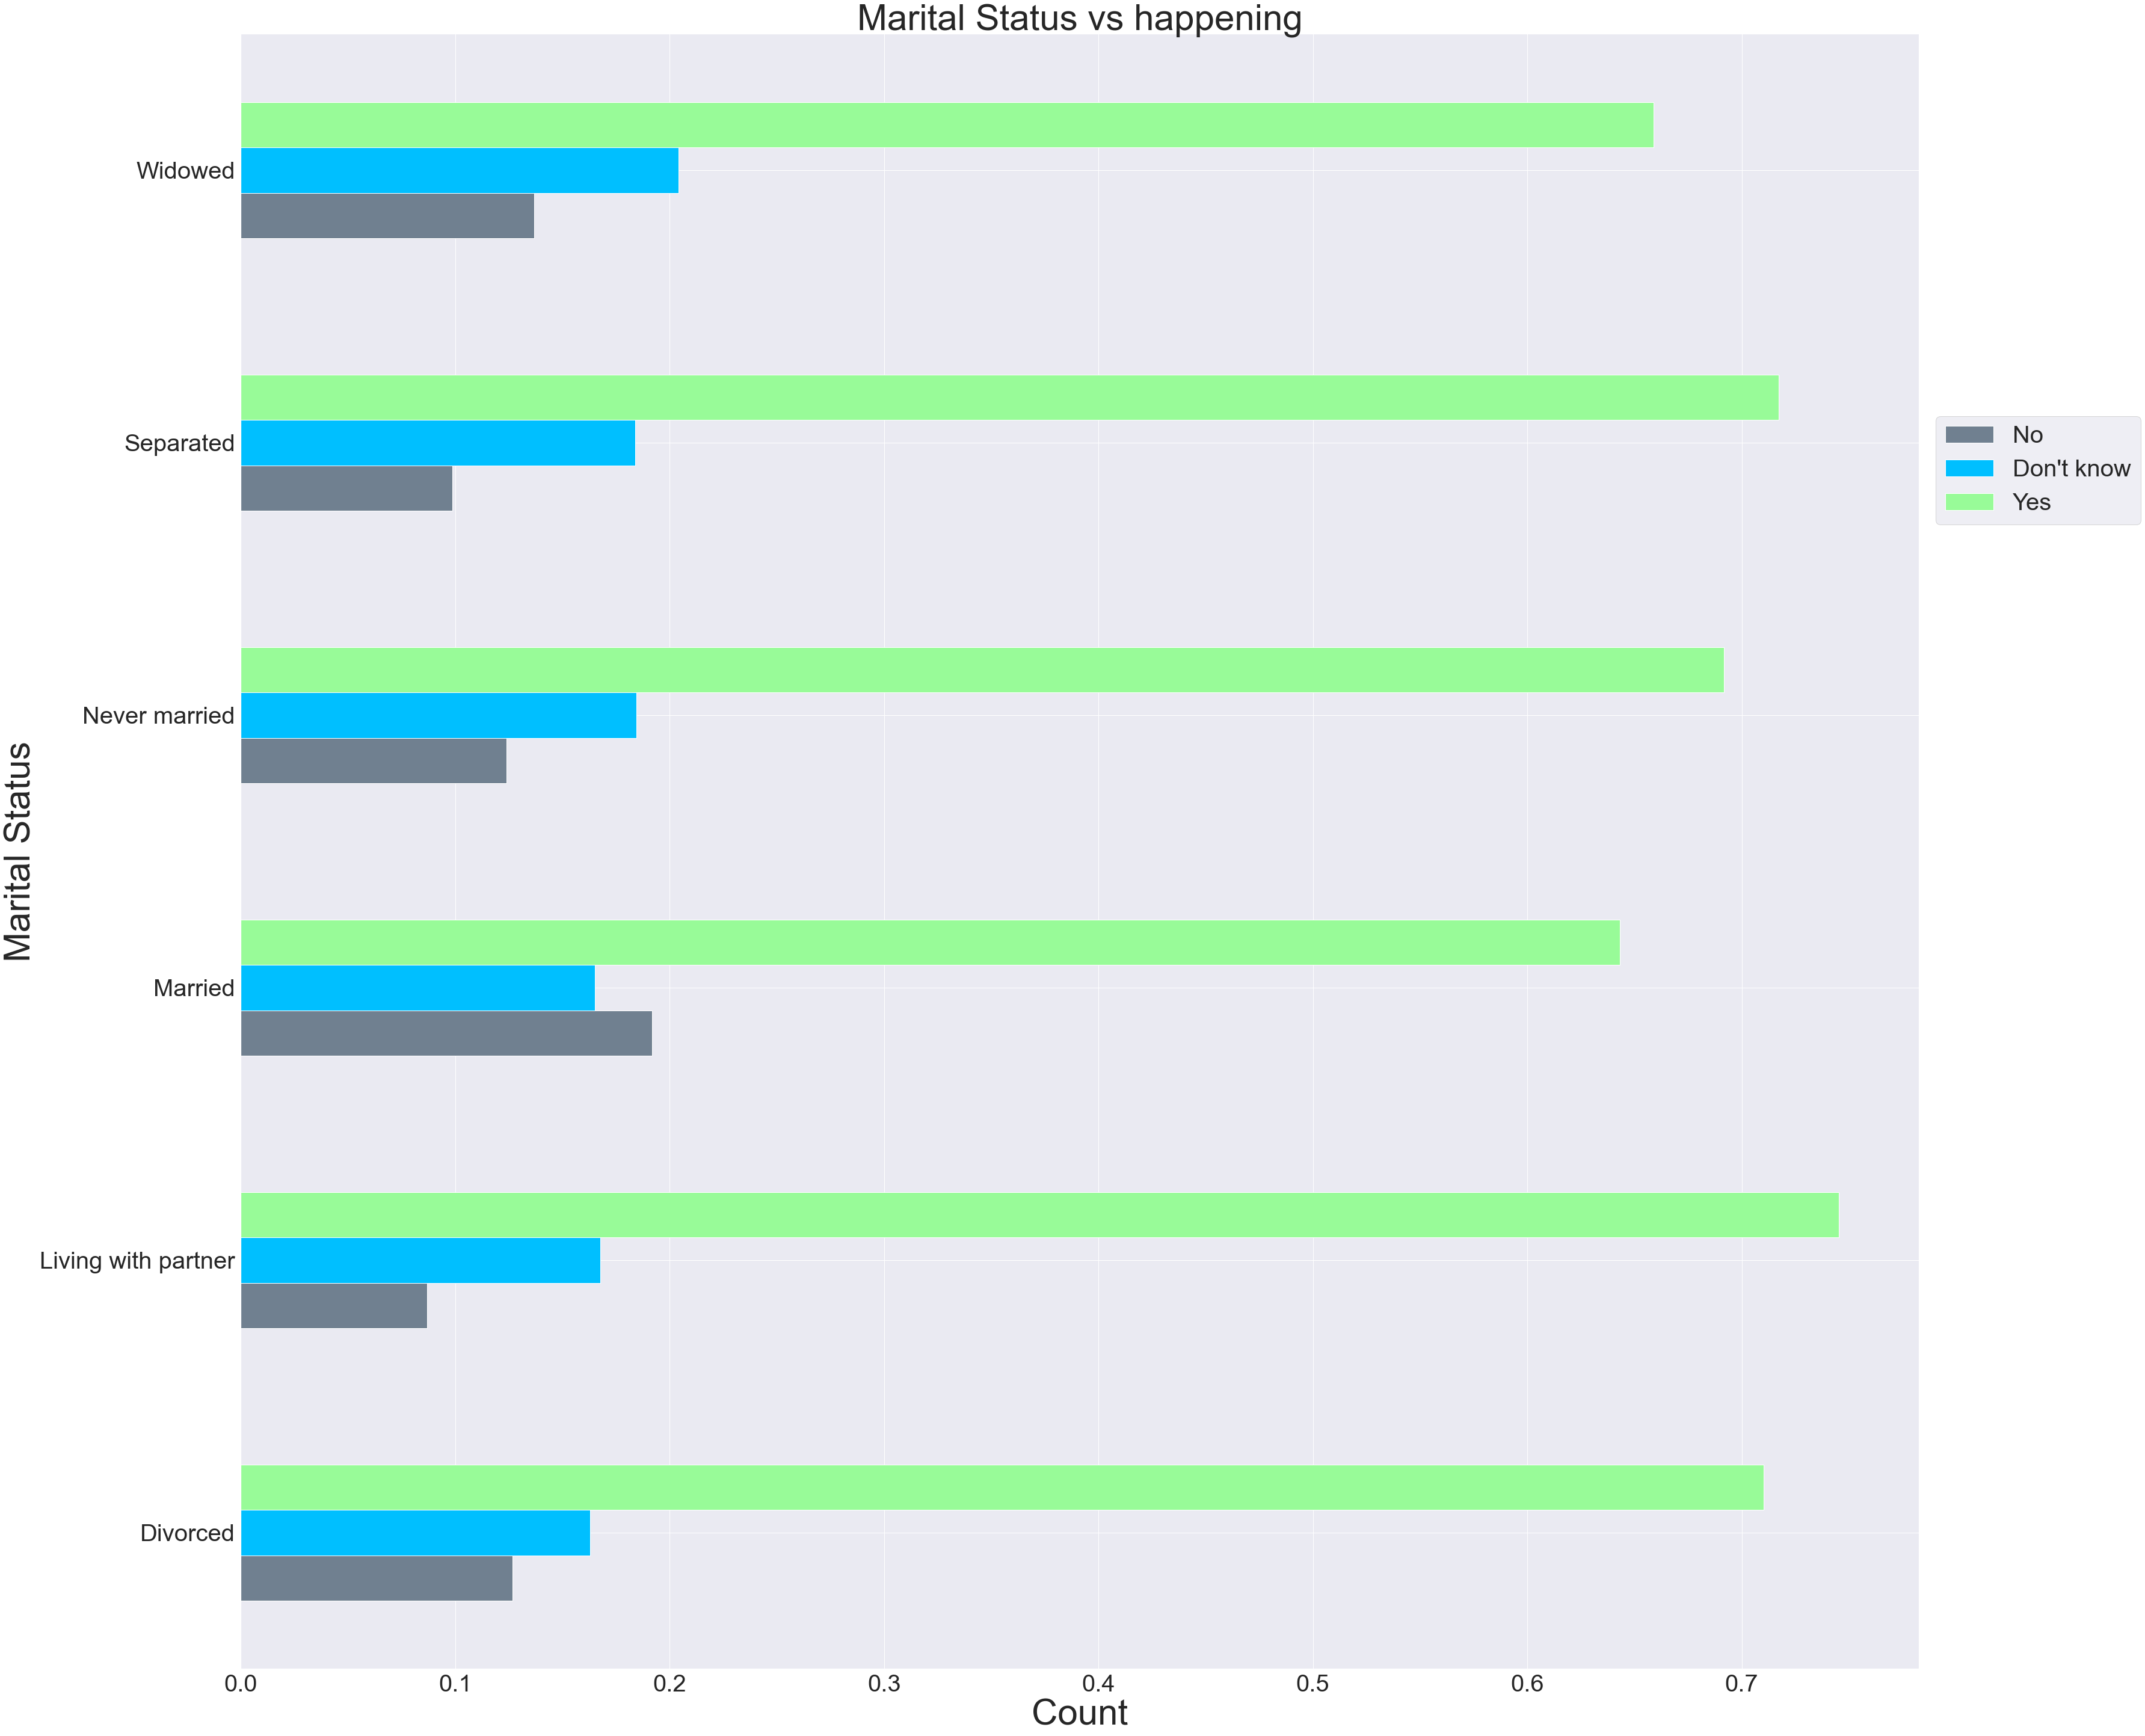

In [191]:
ax = df.groupby('marit_status')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various marital status.**

In [192]:
df.employment.value_counts(normalize=True)

Working - as a paid employee                    0.494294
Not working - retired                           0.227031
Working - self-employed                         0.075766
Not working - other                             0.072231
Not working - disabled                          0.065160
Not working - looking for work                  0.057642
Not working - on temporary layoff from a job    0.007876
Name: employment, dtype: float64

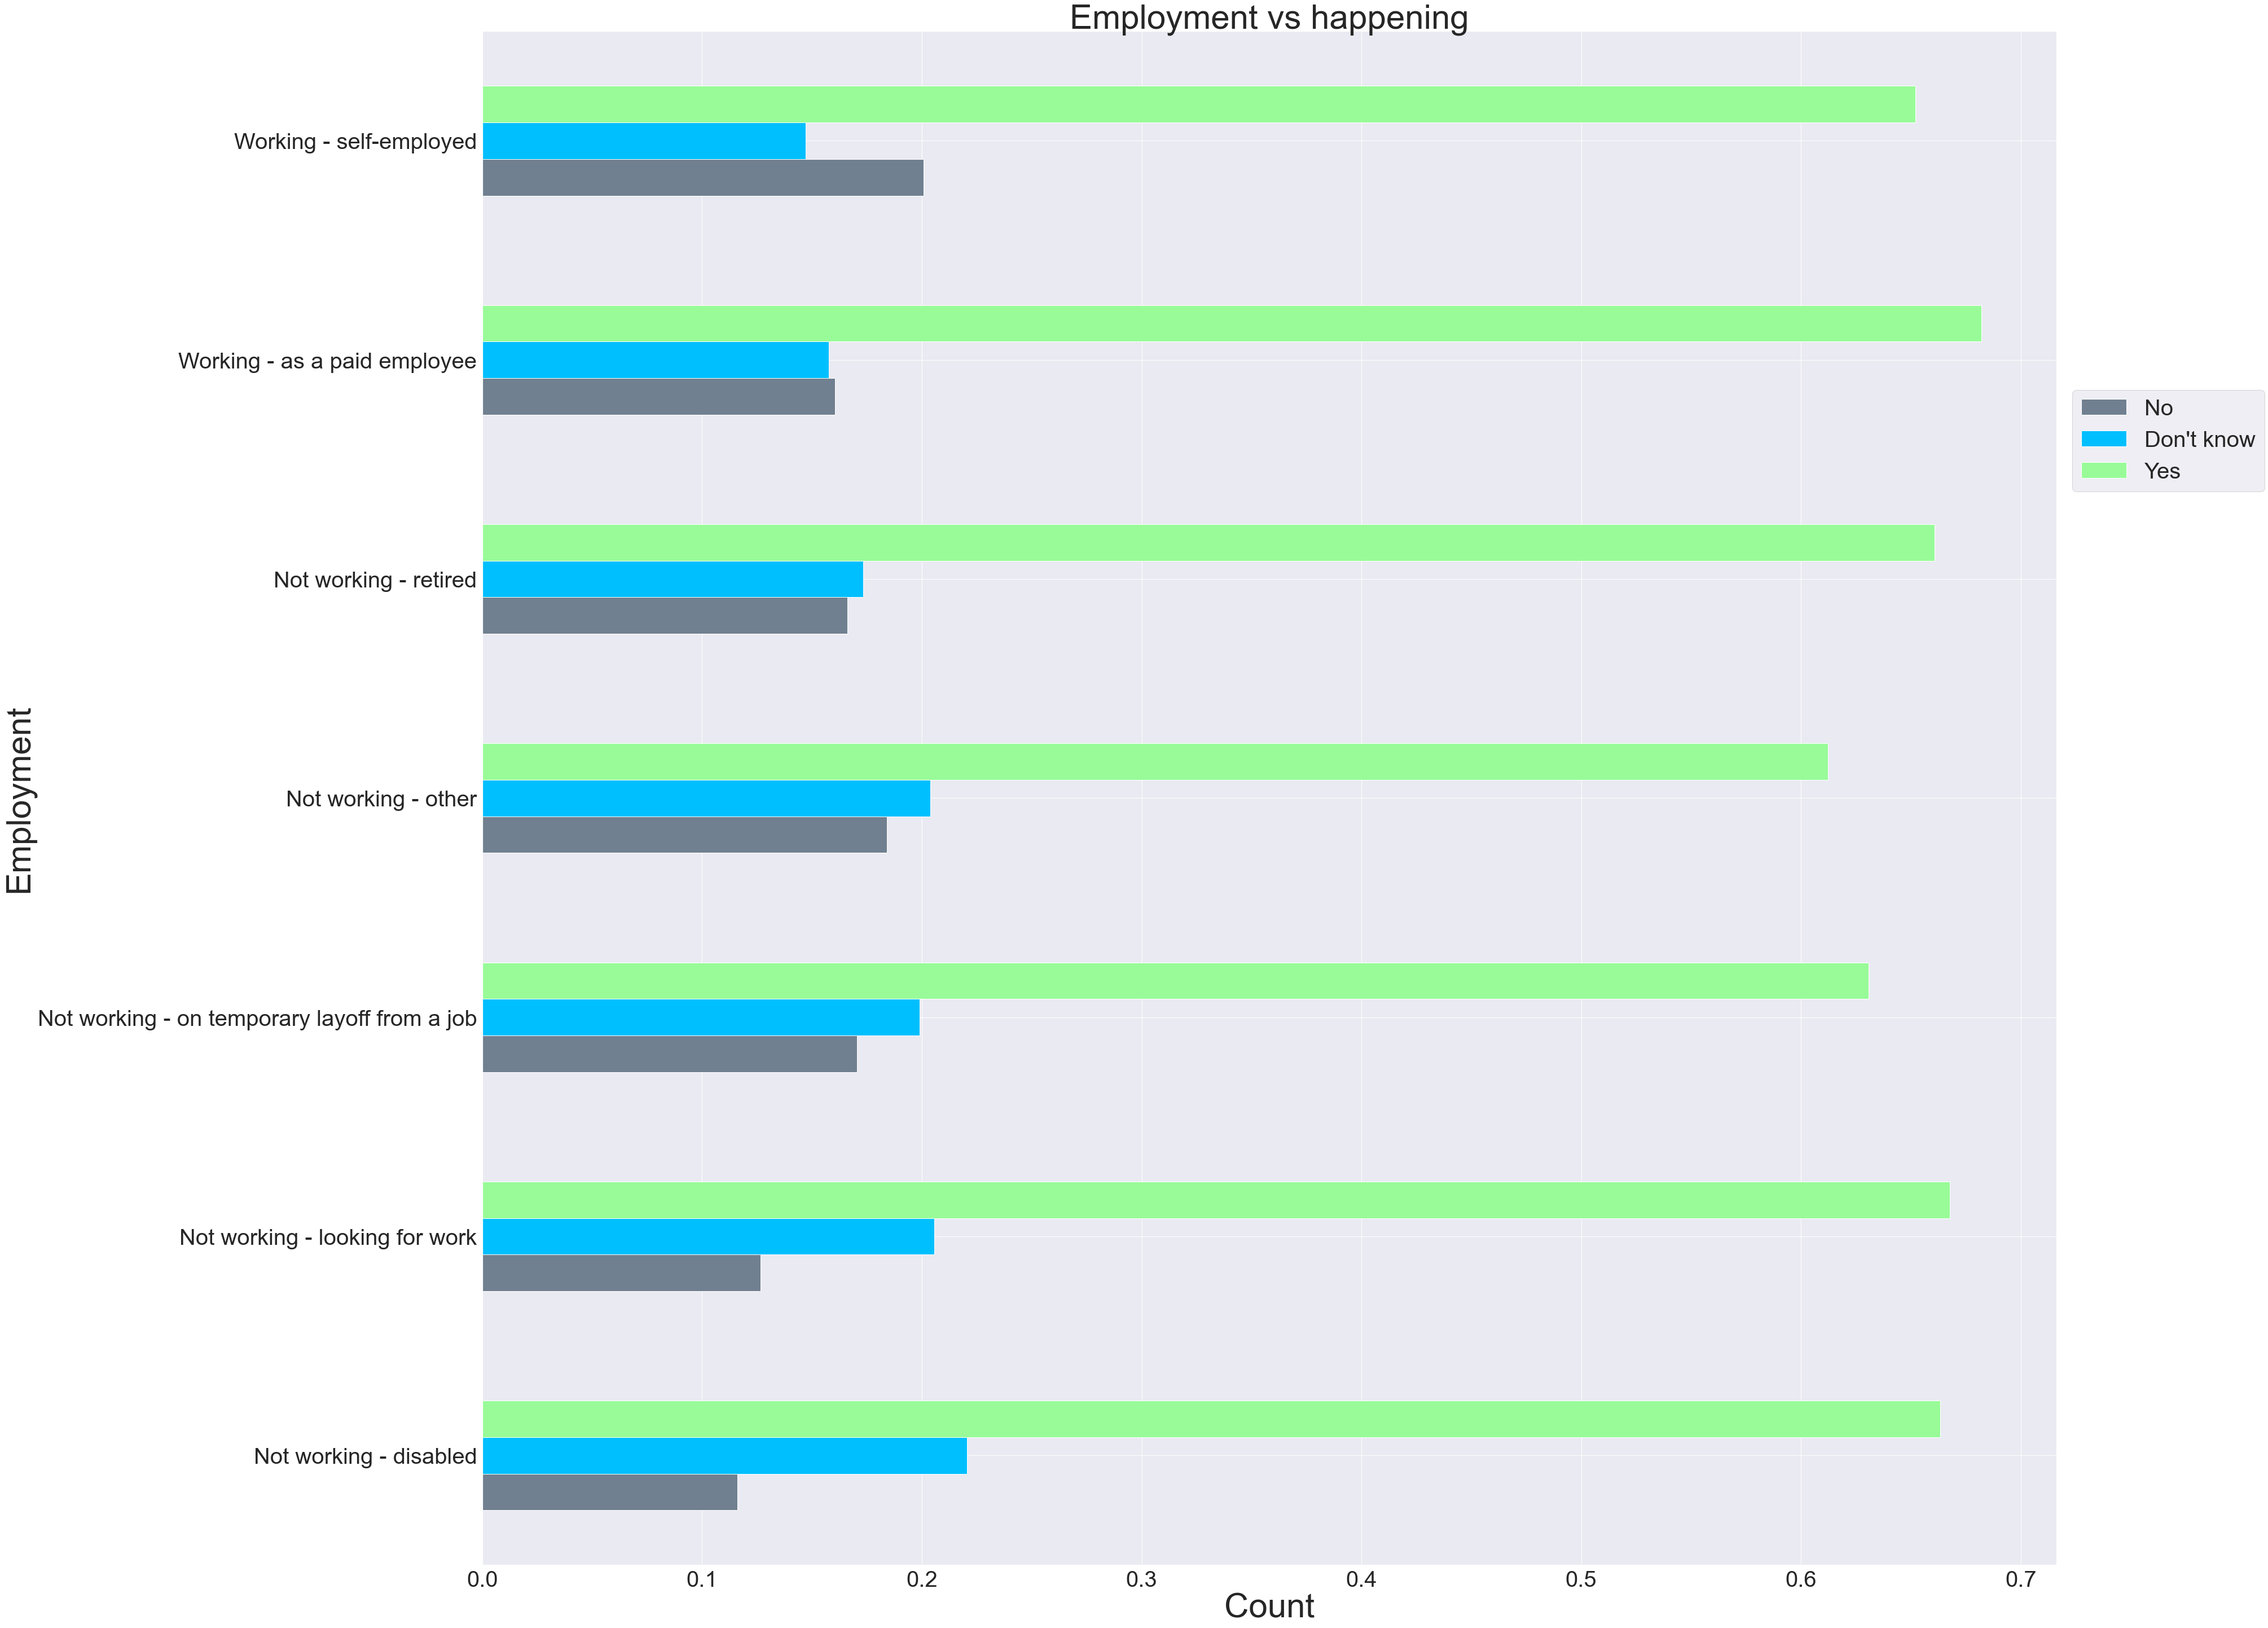

In [193]:
ax = df.groupby('employment')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Employment',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Employment vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various employments.Seems like Retired people have a higher proportion of people not accepting climate change**

In [194]:
df.house_head.value_counts(normalize=True)

Head of household        0.826359
Not head of household    0.173641
Name: house_head, dtype: float64

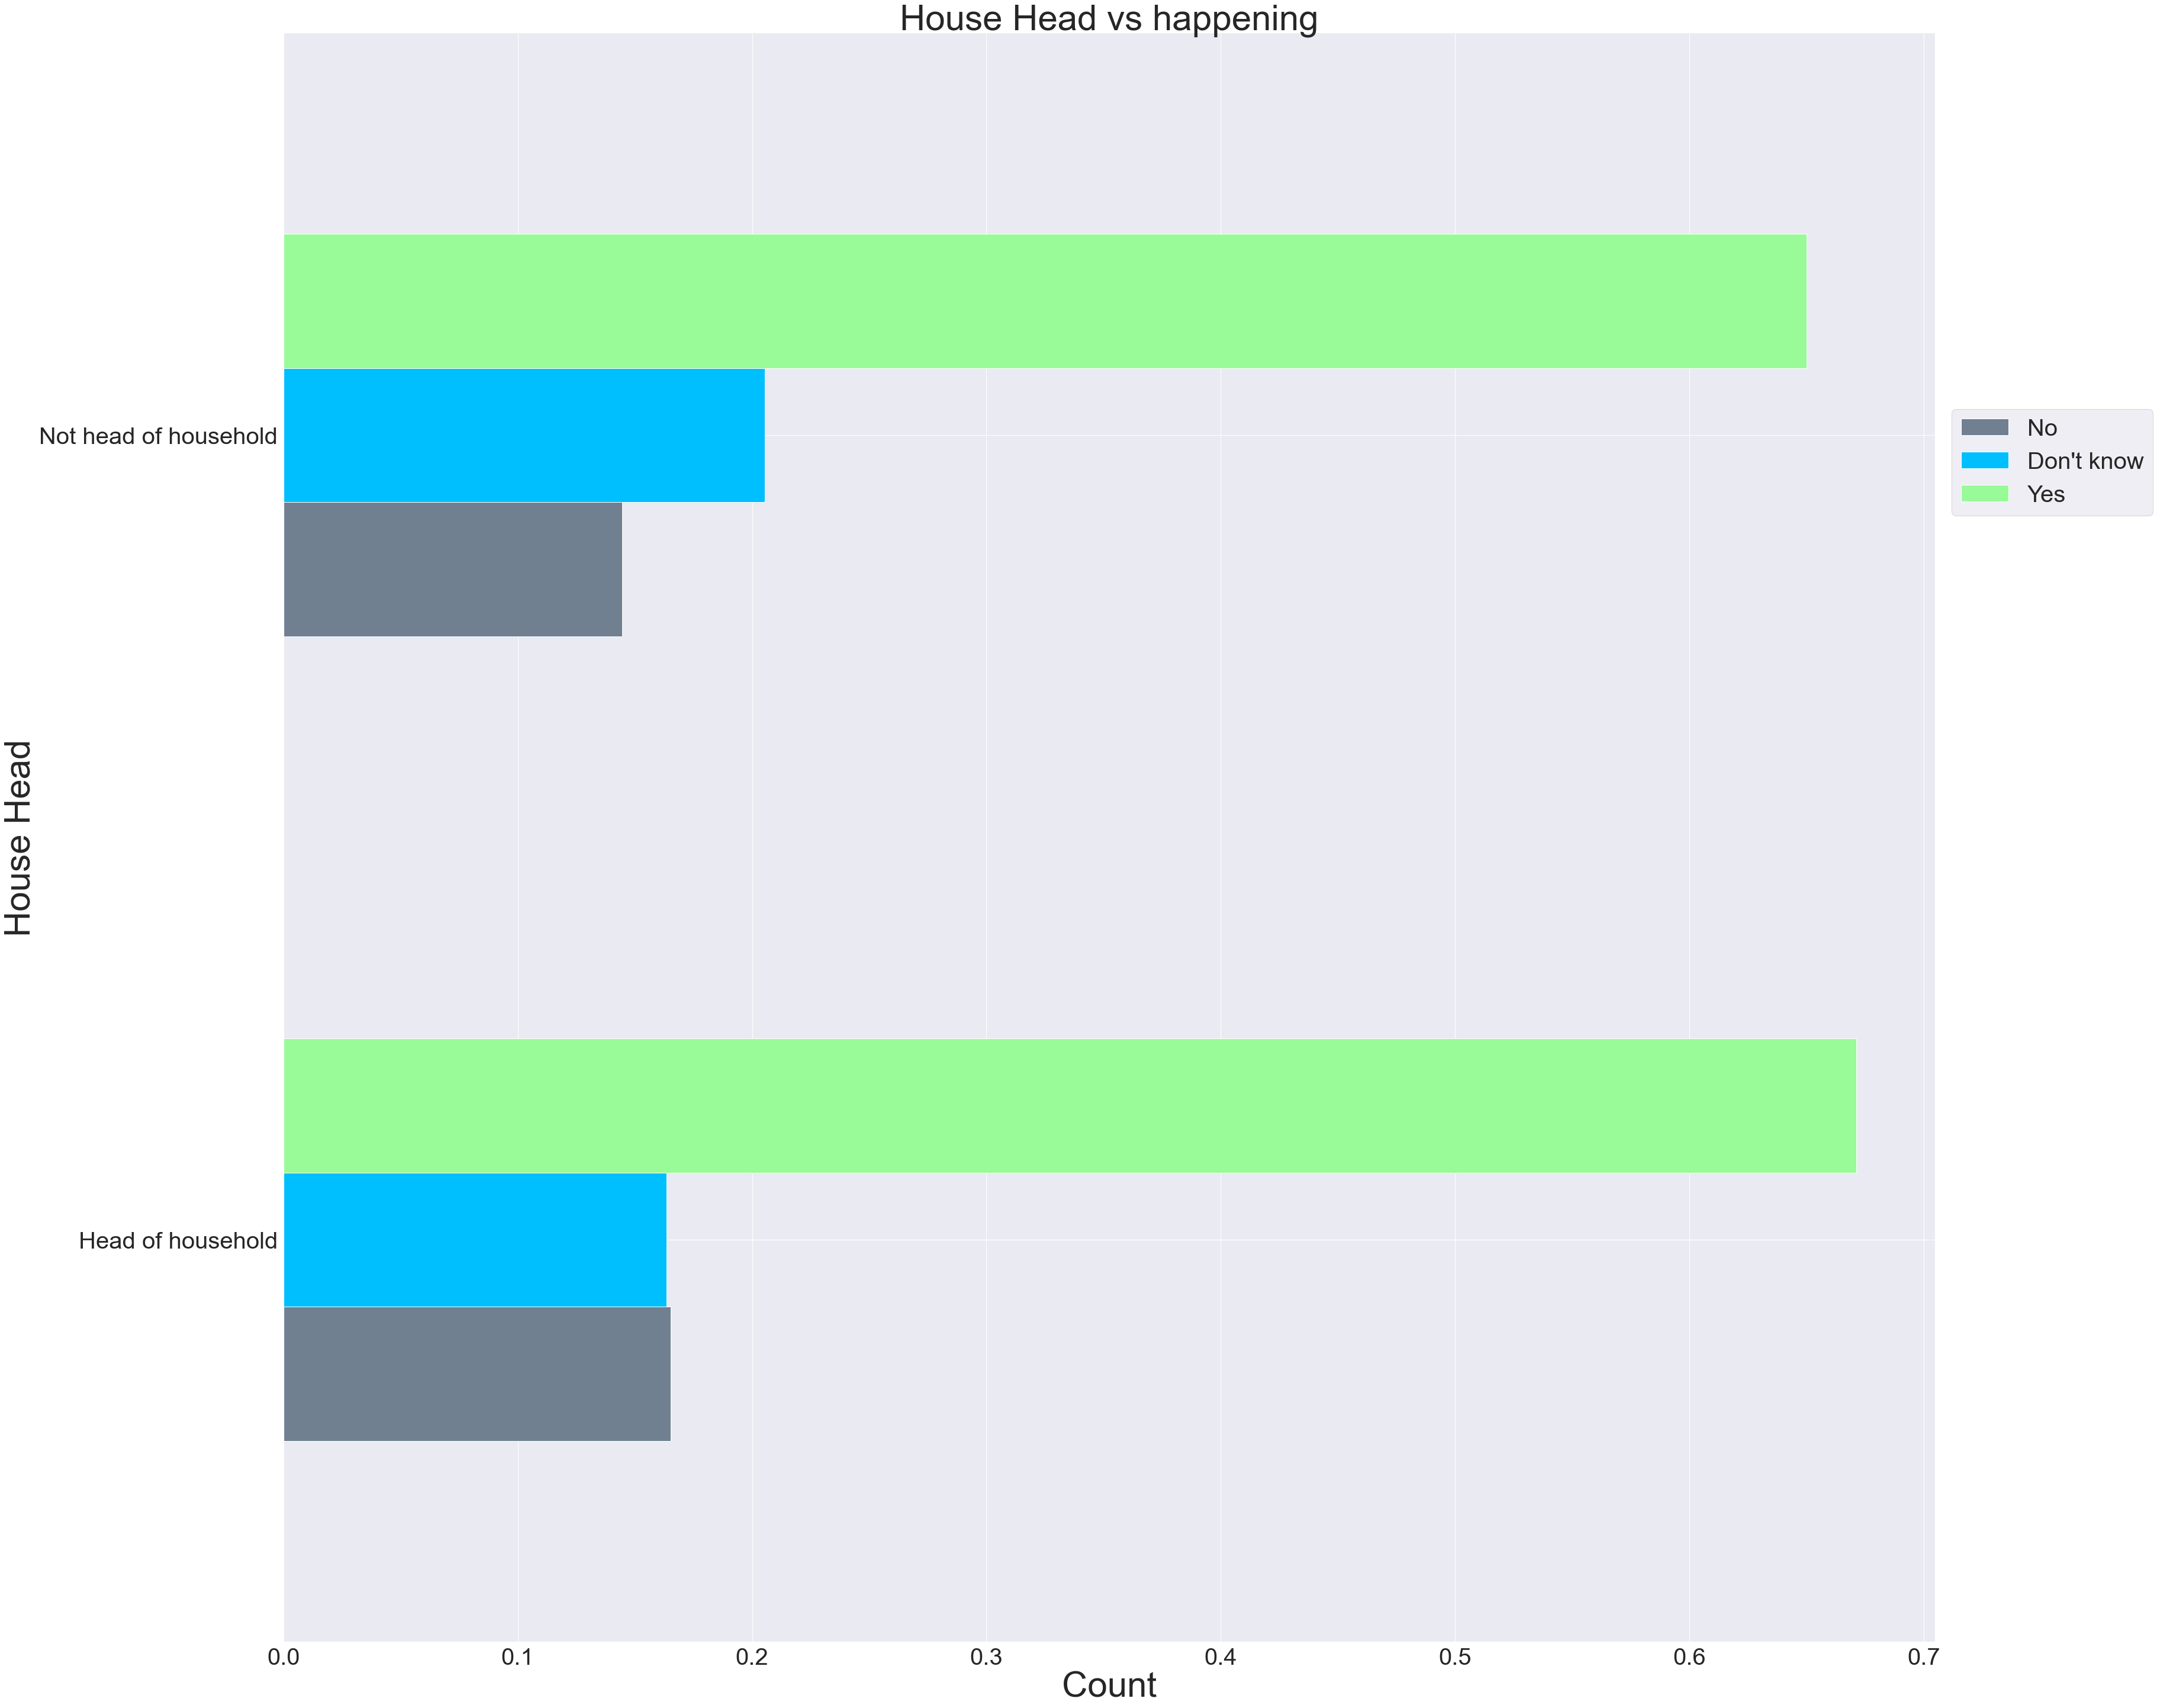

In [195]:
ax = df.groupby('house_head')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Head',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Head vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house heads status. Majority of those surveyed seem to own a household**

In [196]:
df.house_size.value_counts(normalize=True)

2.0     0.389841
1.0     0.191094
3.0     0.165809
4.0     0.142045
5.0     0.066592
6.0     0.026091
7.0     0.009622
8.0     0.004654
9.0     0.001790
10.0    0.001656
12.0    0.000627
15.0    0.000134
11.0    0.000045
Name: house_size, dtype: float64

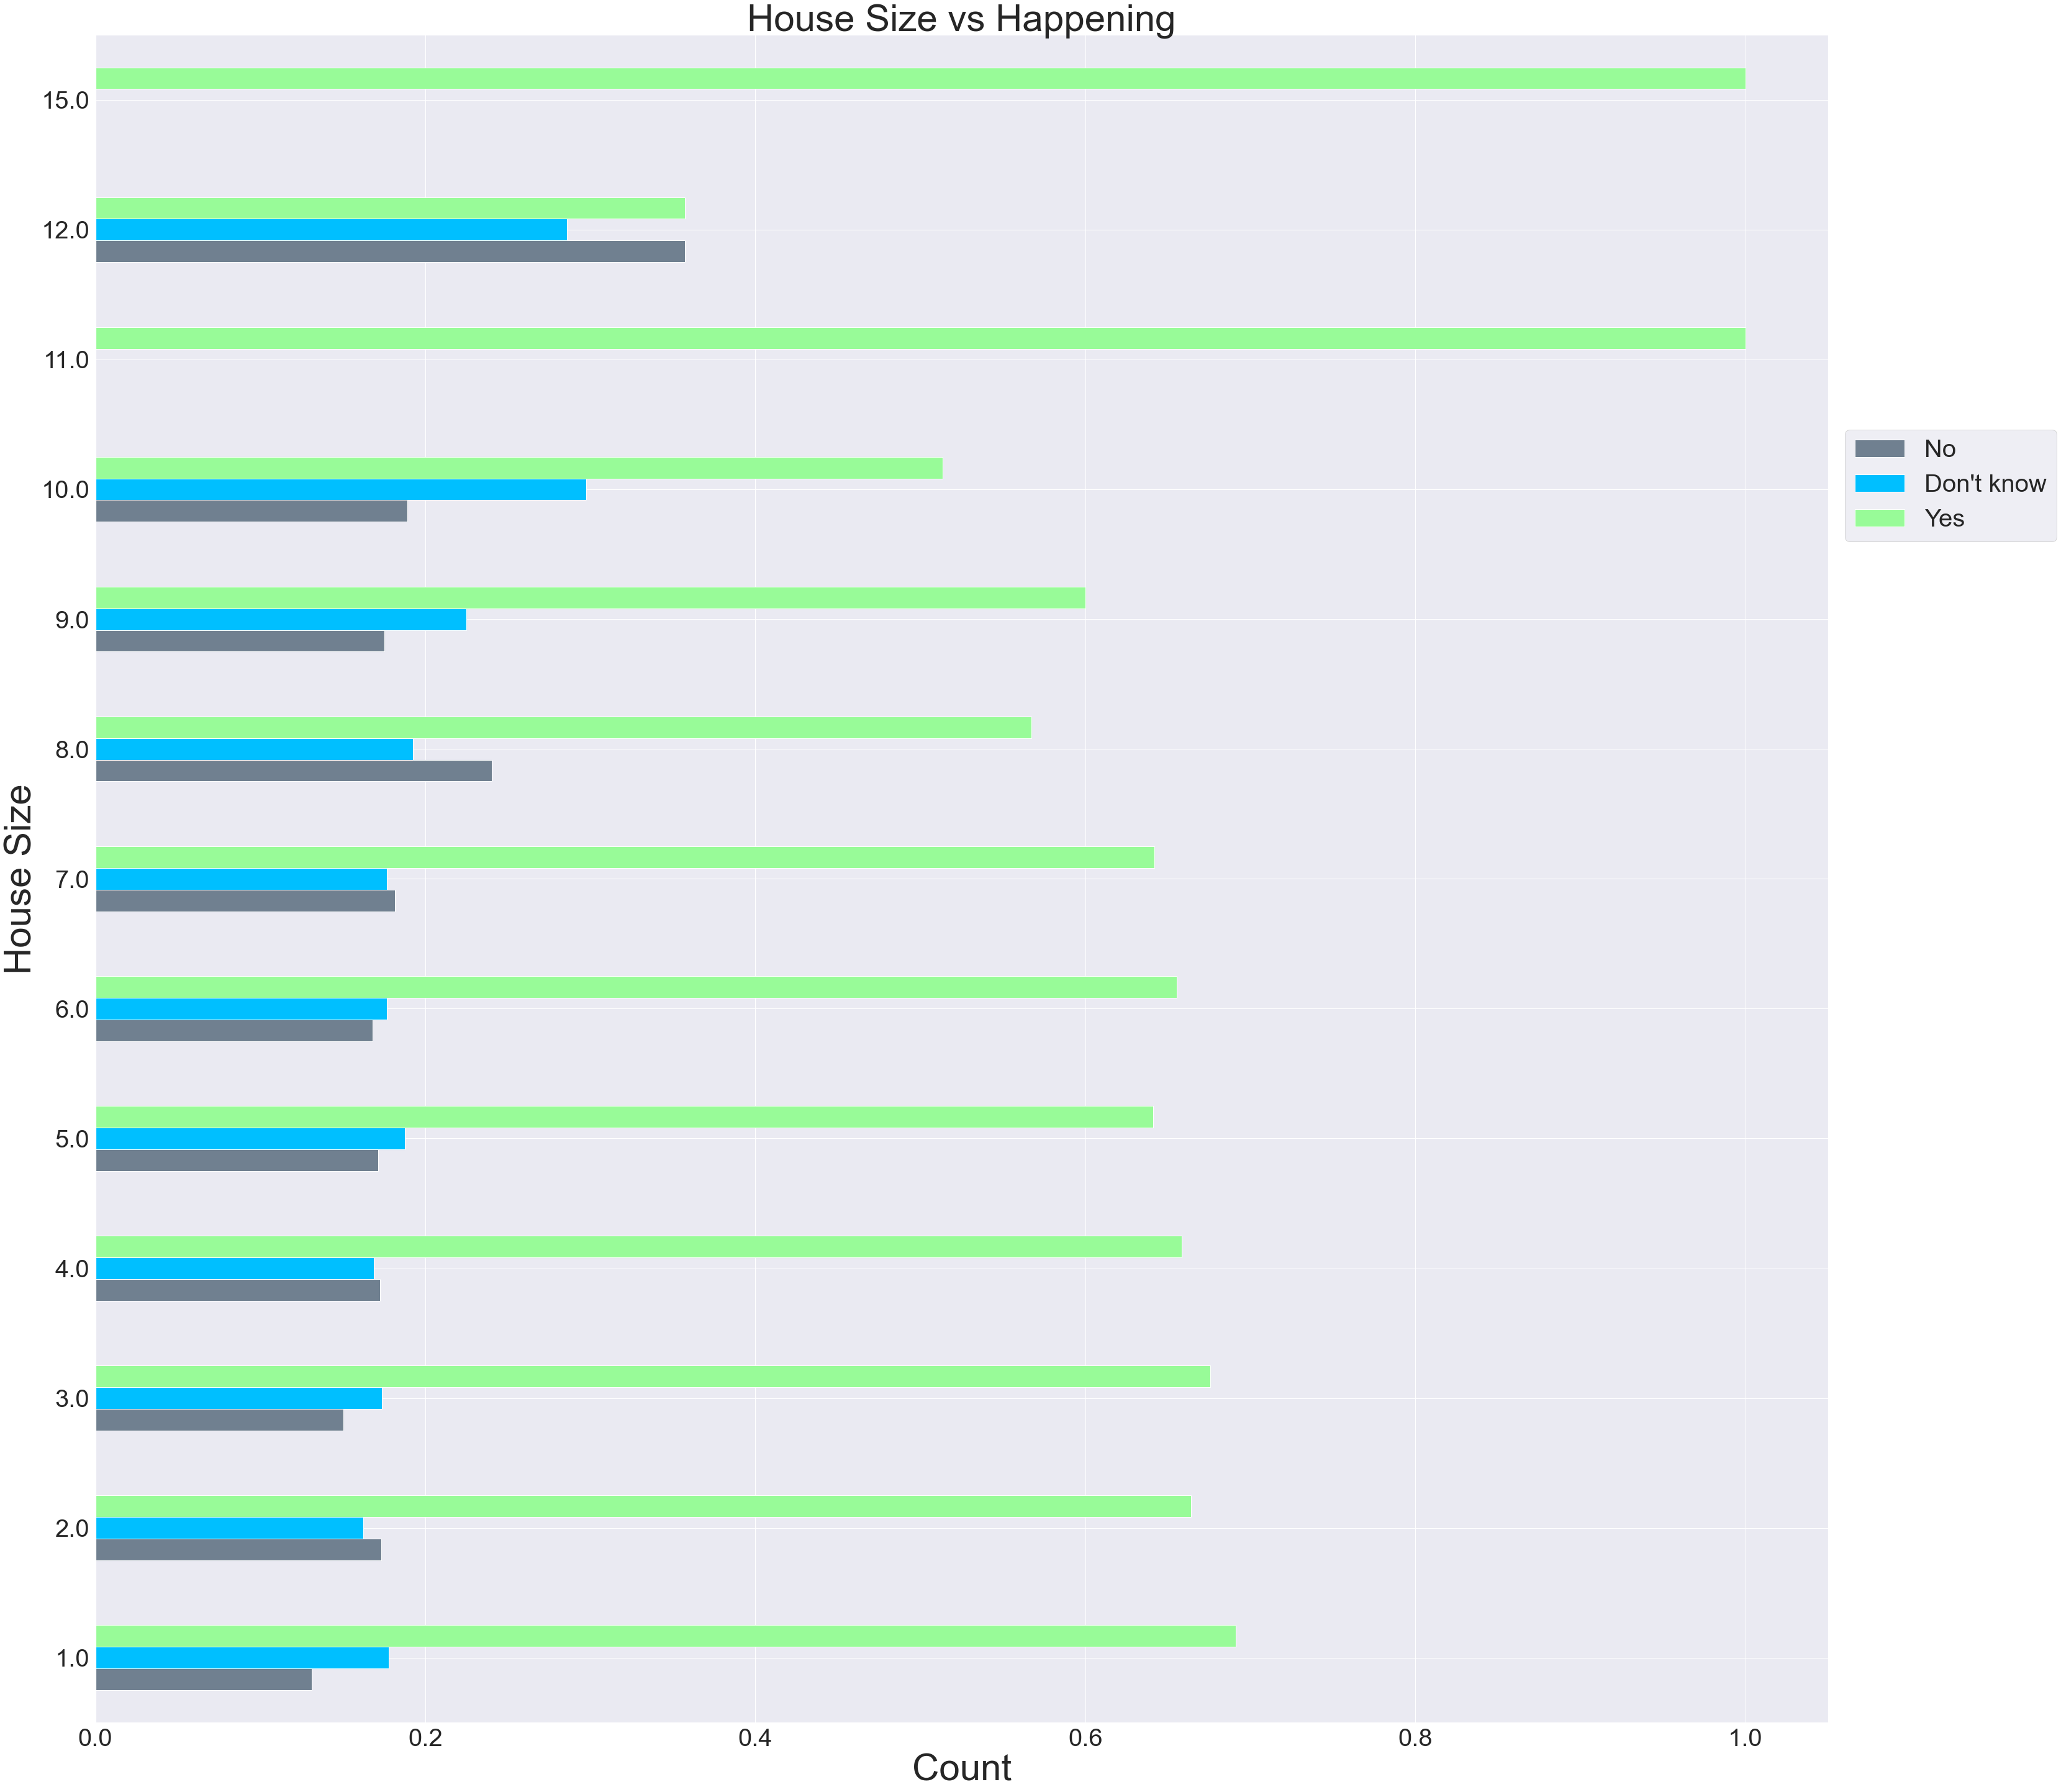

In [197]:
ax = df.groupby('house_size')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Size',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Size vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house size.** 

In [198]:
df.house_ages0to1.value_counts(normalize=True)

0.0    0.961378
1.0    0.035936
2.0    0.002103
3.0    0.000224
4.0    0.000224
6.0    0.000090
7.0    0.000045
Name: house_ages0to1, dtype: float64

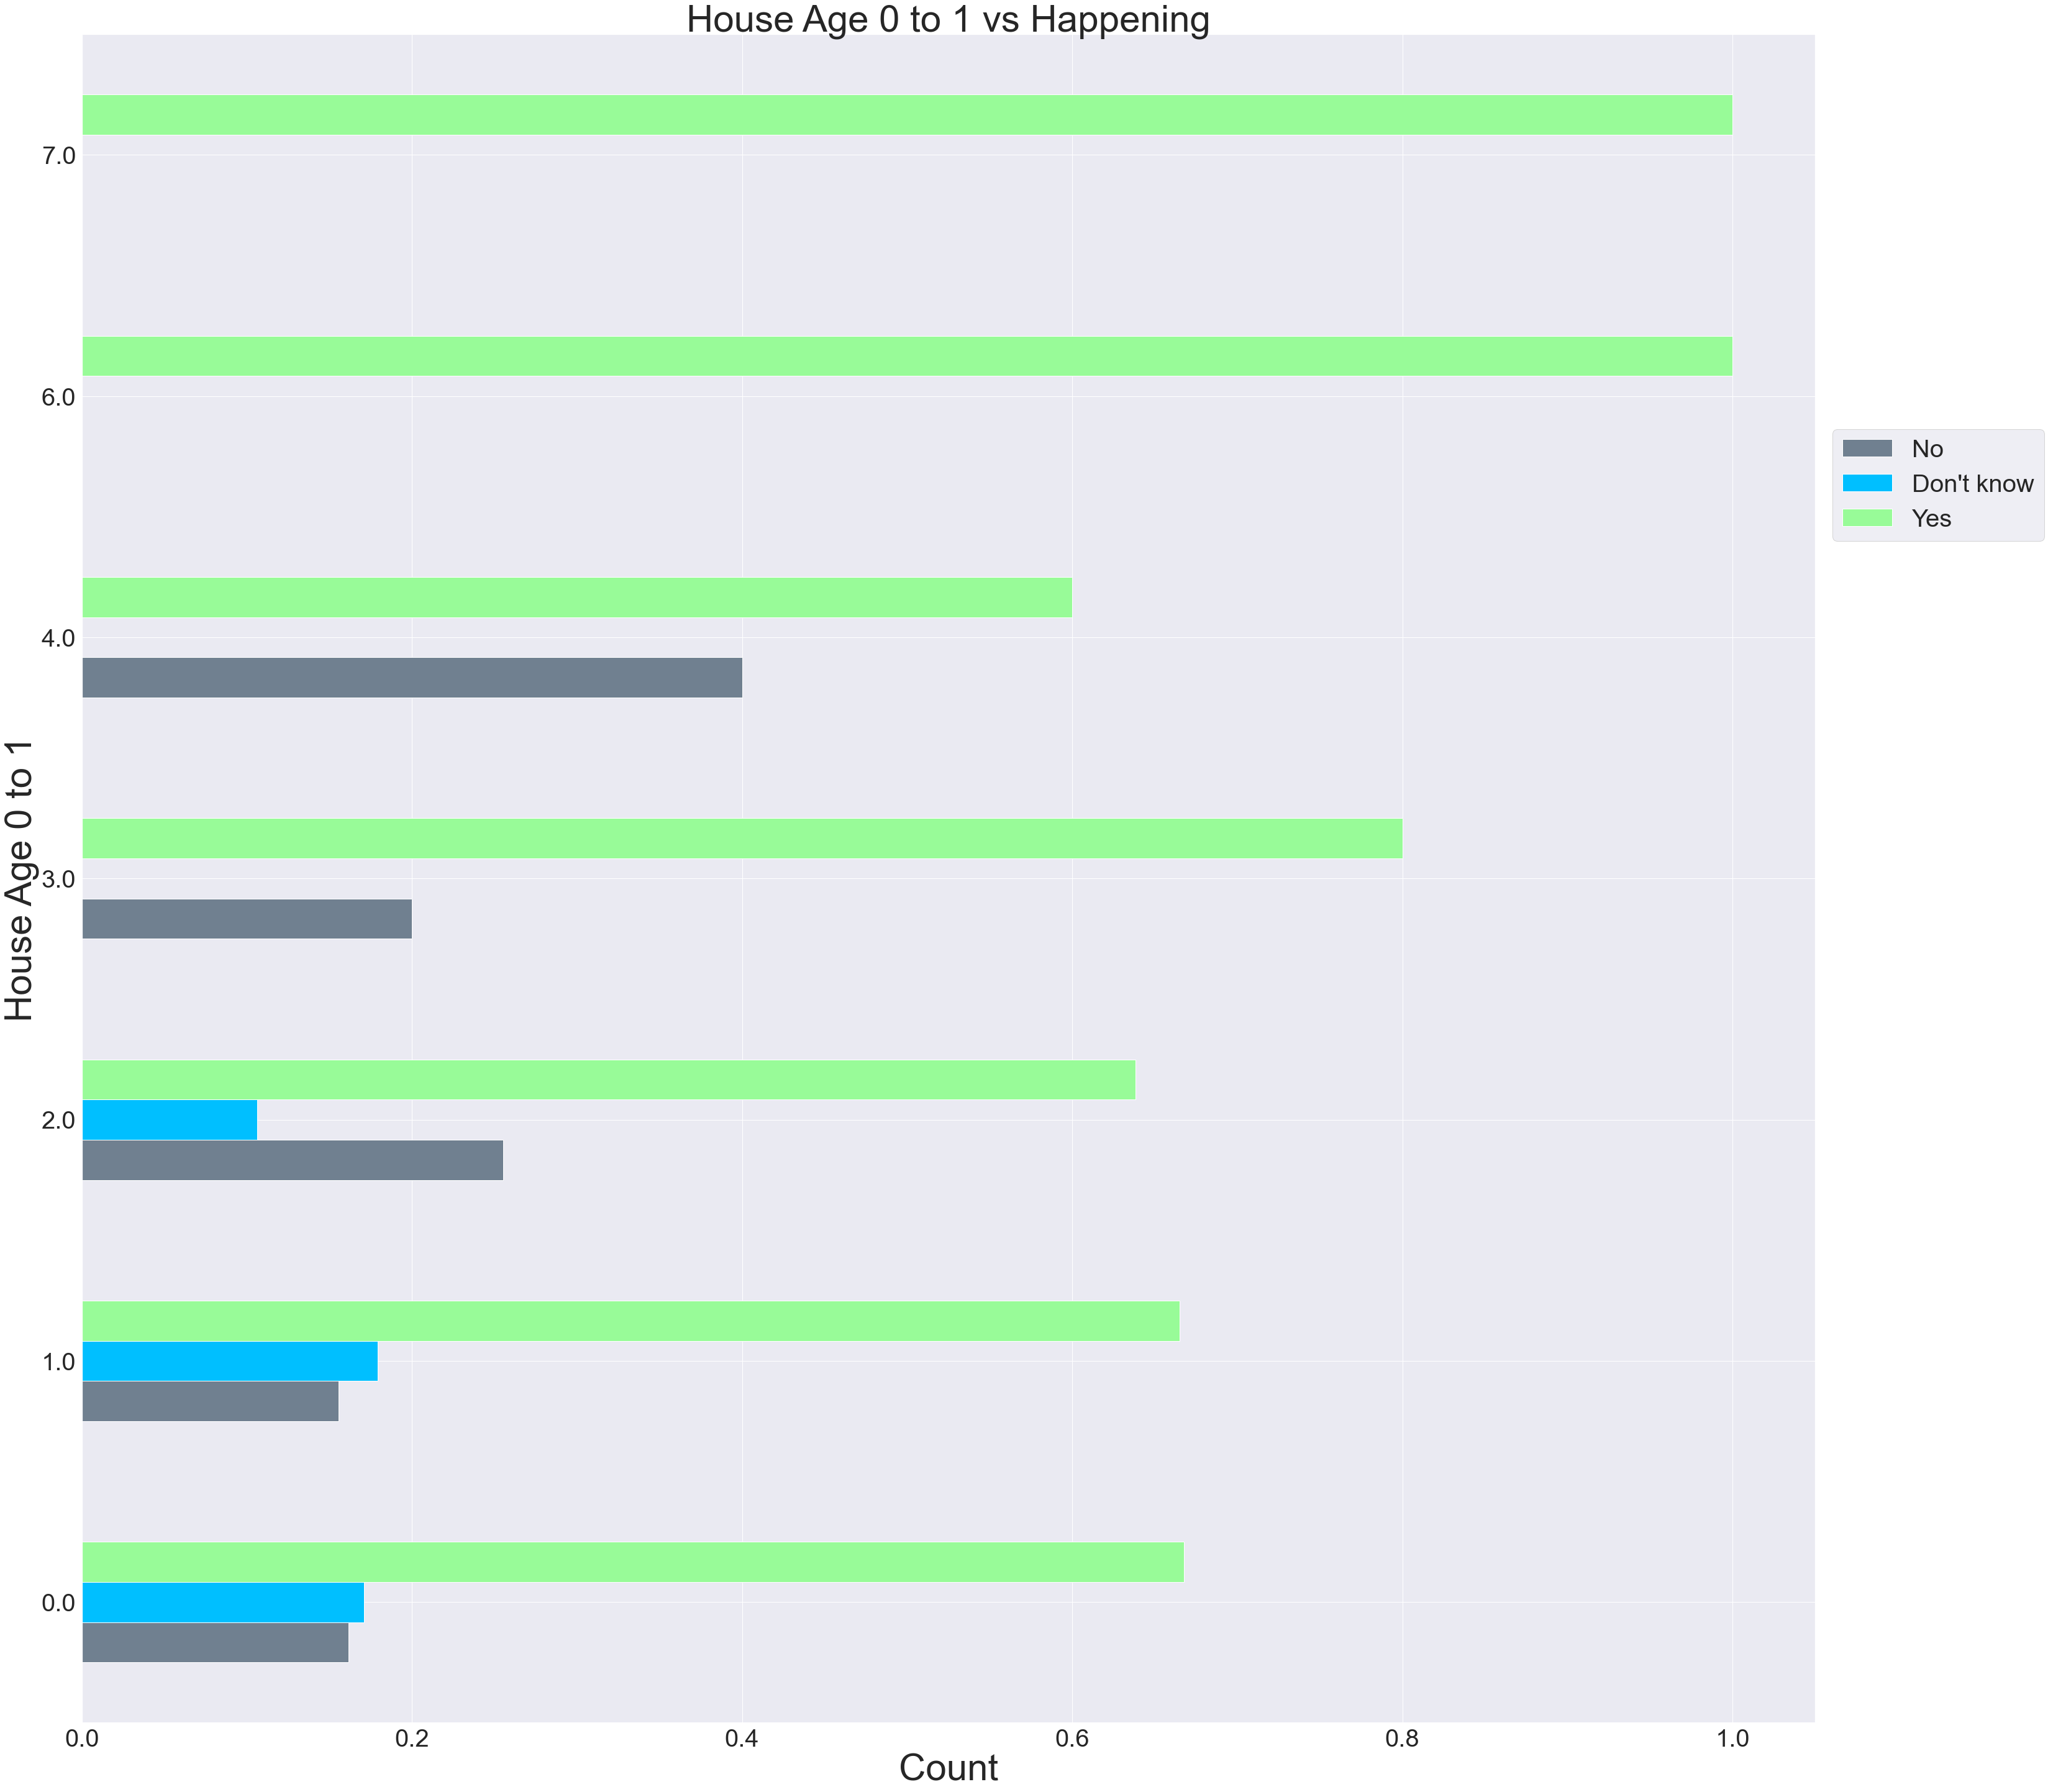

In [199]:
ax = df.groupby('house_ages0to1')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 0 to 1',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 0 to 1 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 0 to 1.**
- **0 is the dominant group** 

In [200]:
df.house_ages2to5.value_counts(normalize=True)

0.0    0.912687
1.0    0.069456
2.0    0.016603
3.0    0.001119
4.0    0.000134
Name: house_ages2to5, dtype: float64

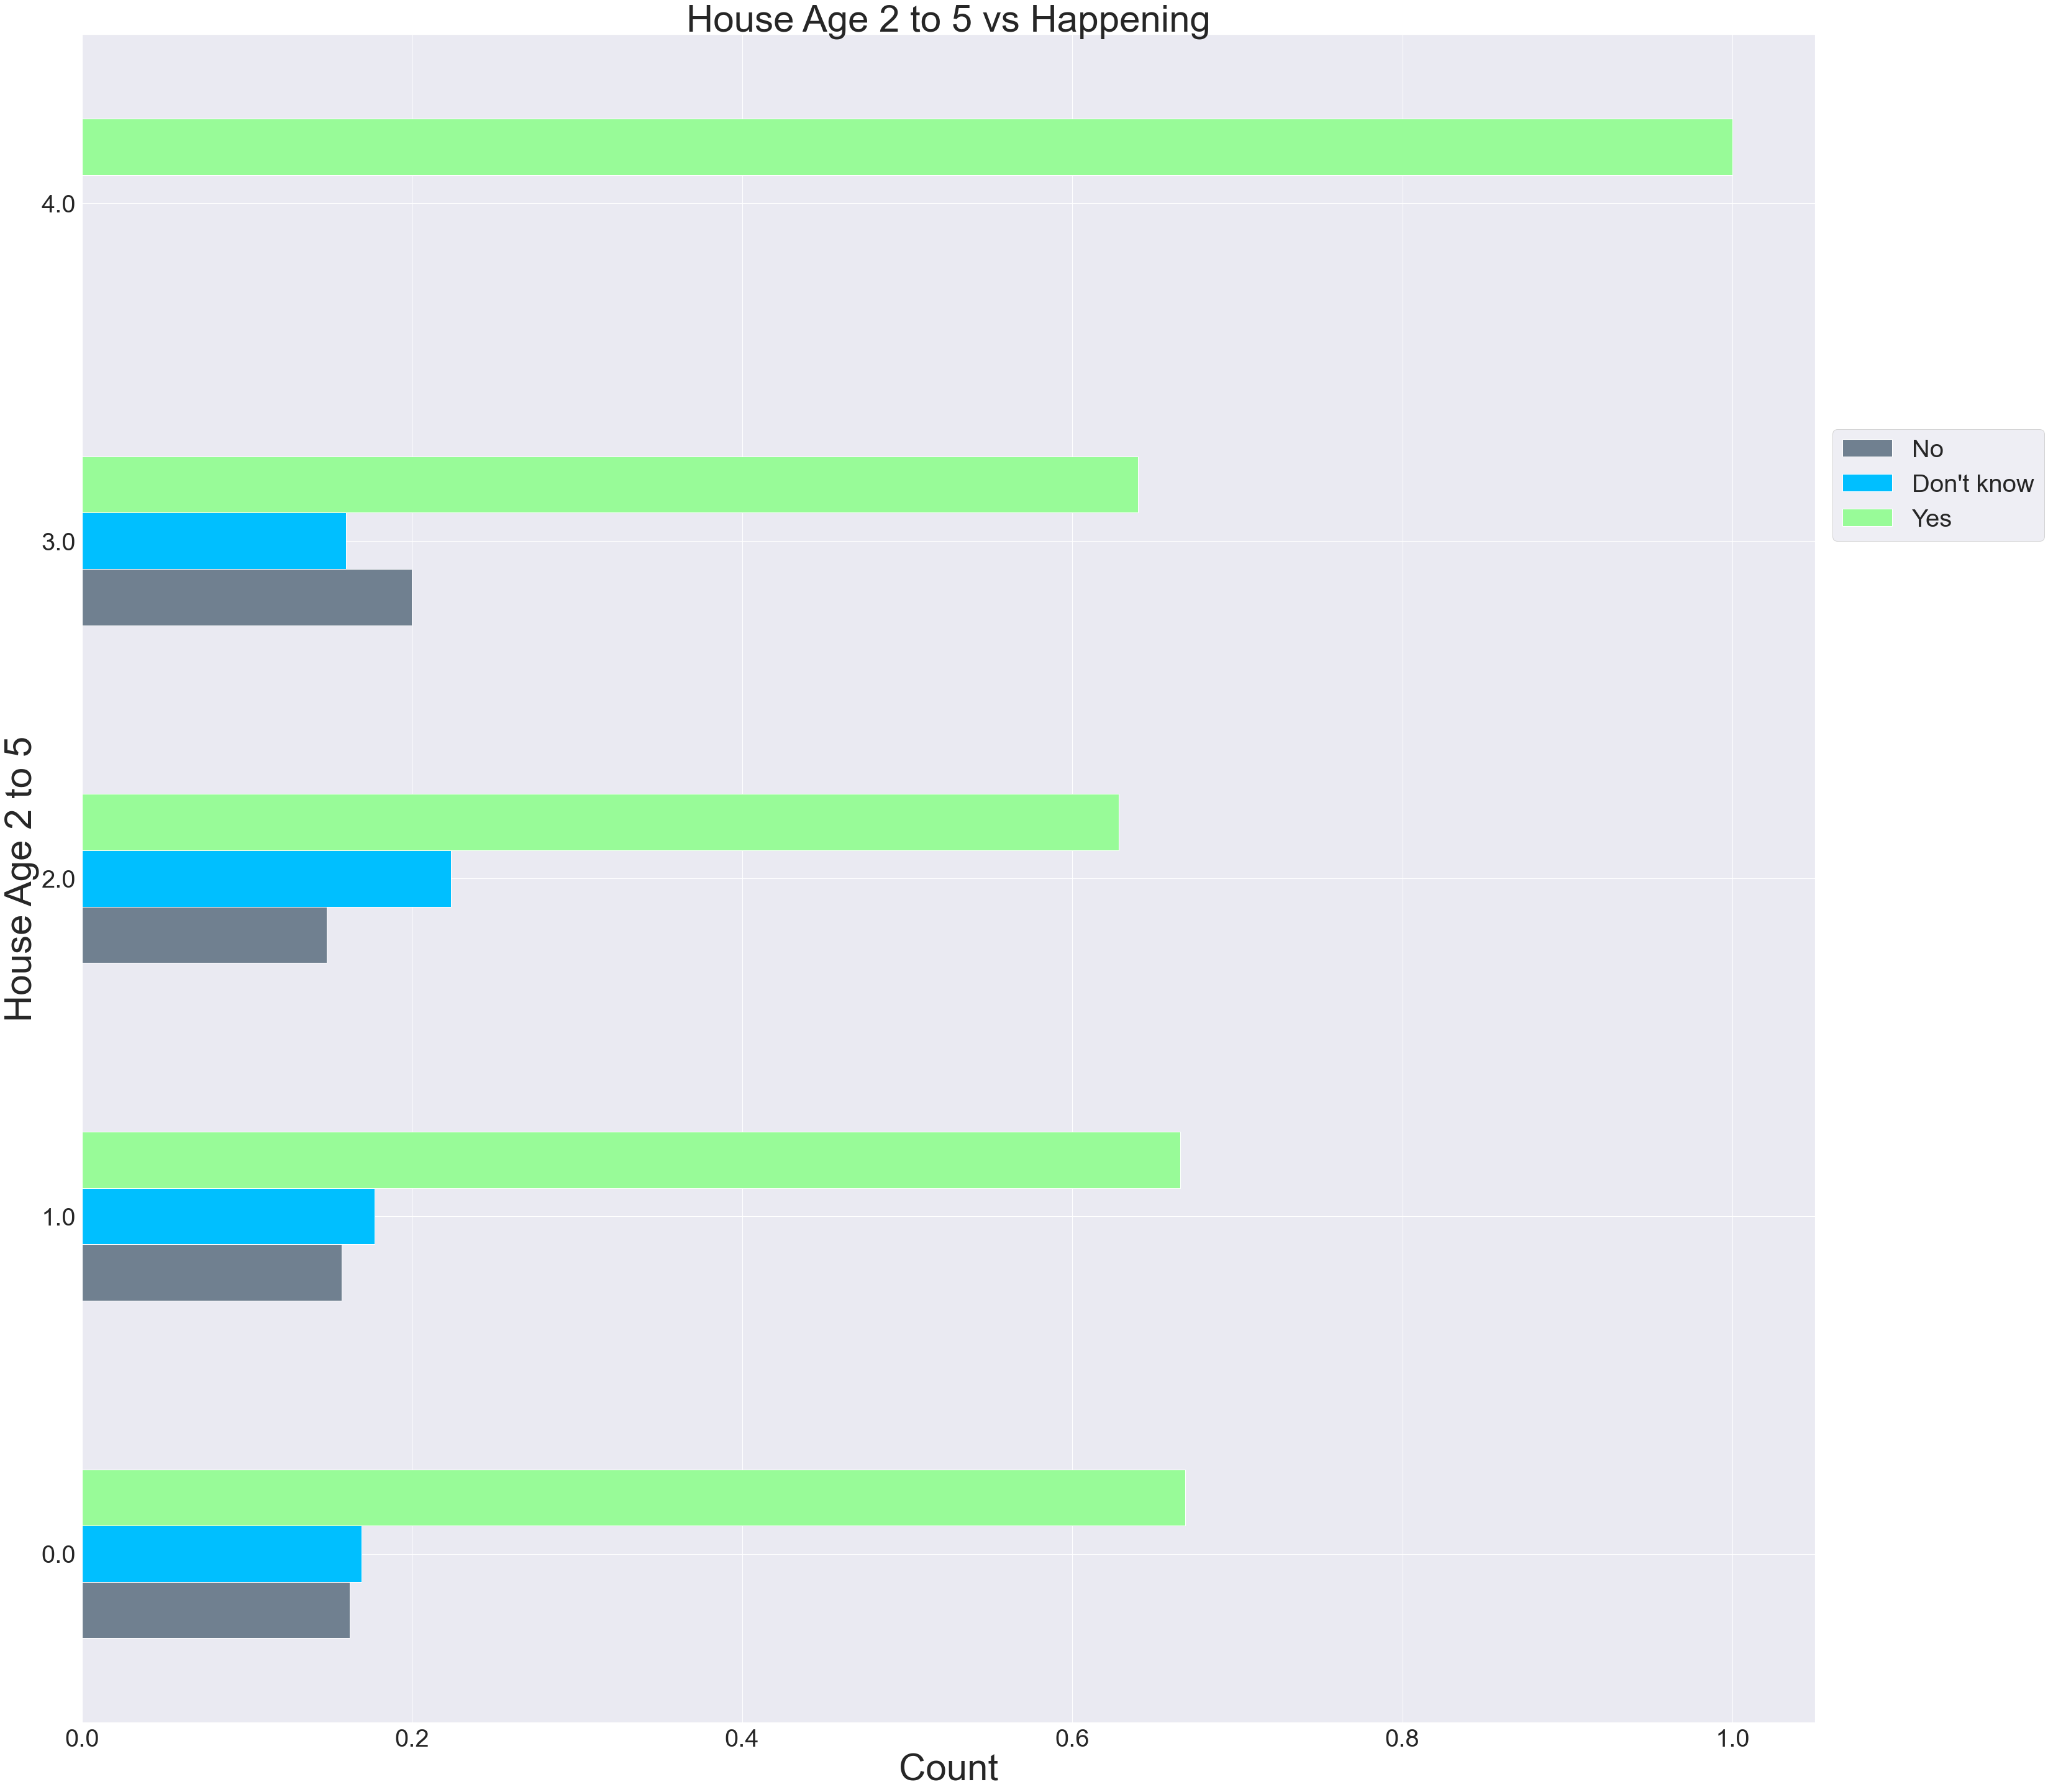

In [201]:
ax = df.groupby('house_ages2to5')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 2 to 5',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 2 to 5 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 2 to 5.**
- **0 is the dominant group** 

In [202]:
df.house_ages6to12.value_counts(normalize=True)

0.0    0.856746
1.0    0.093981
2.0    0.039651
3.0    0.008055
4.0    0.001387
5.0    0.000090
6.0    0.000090
Name: house_ages6to12, dtype: float64

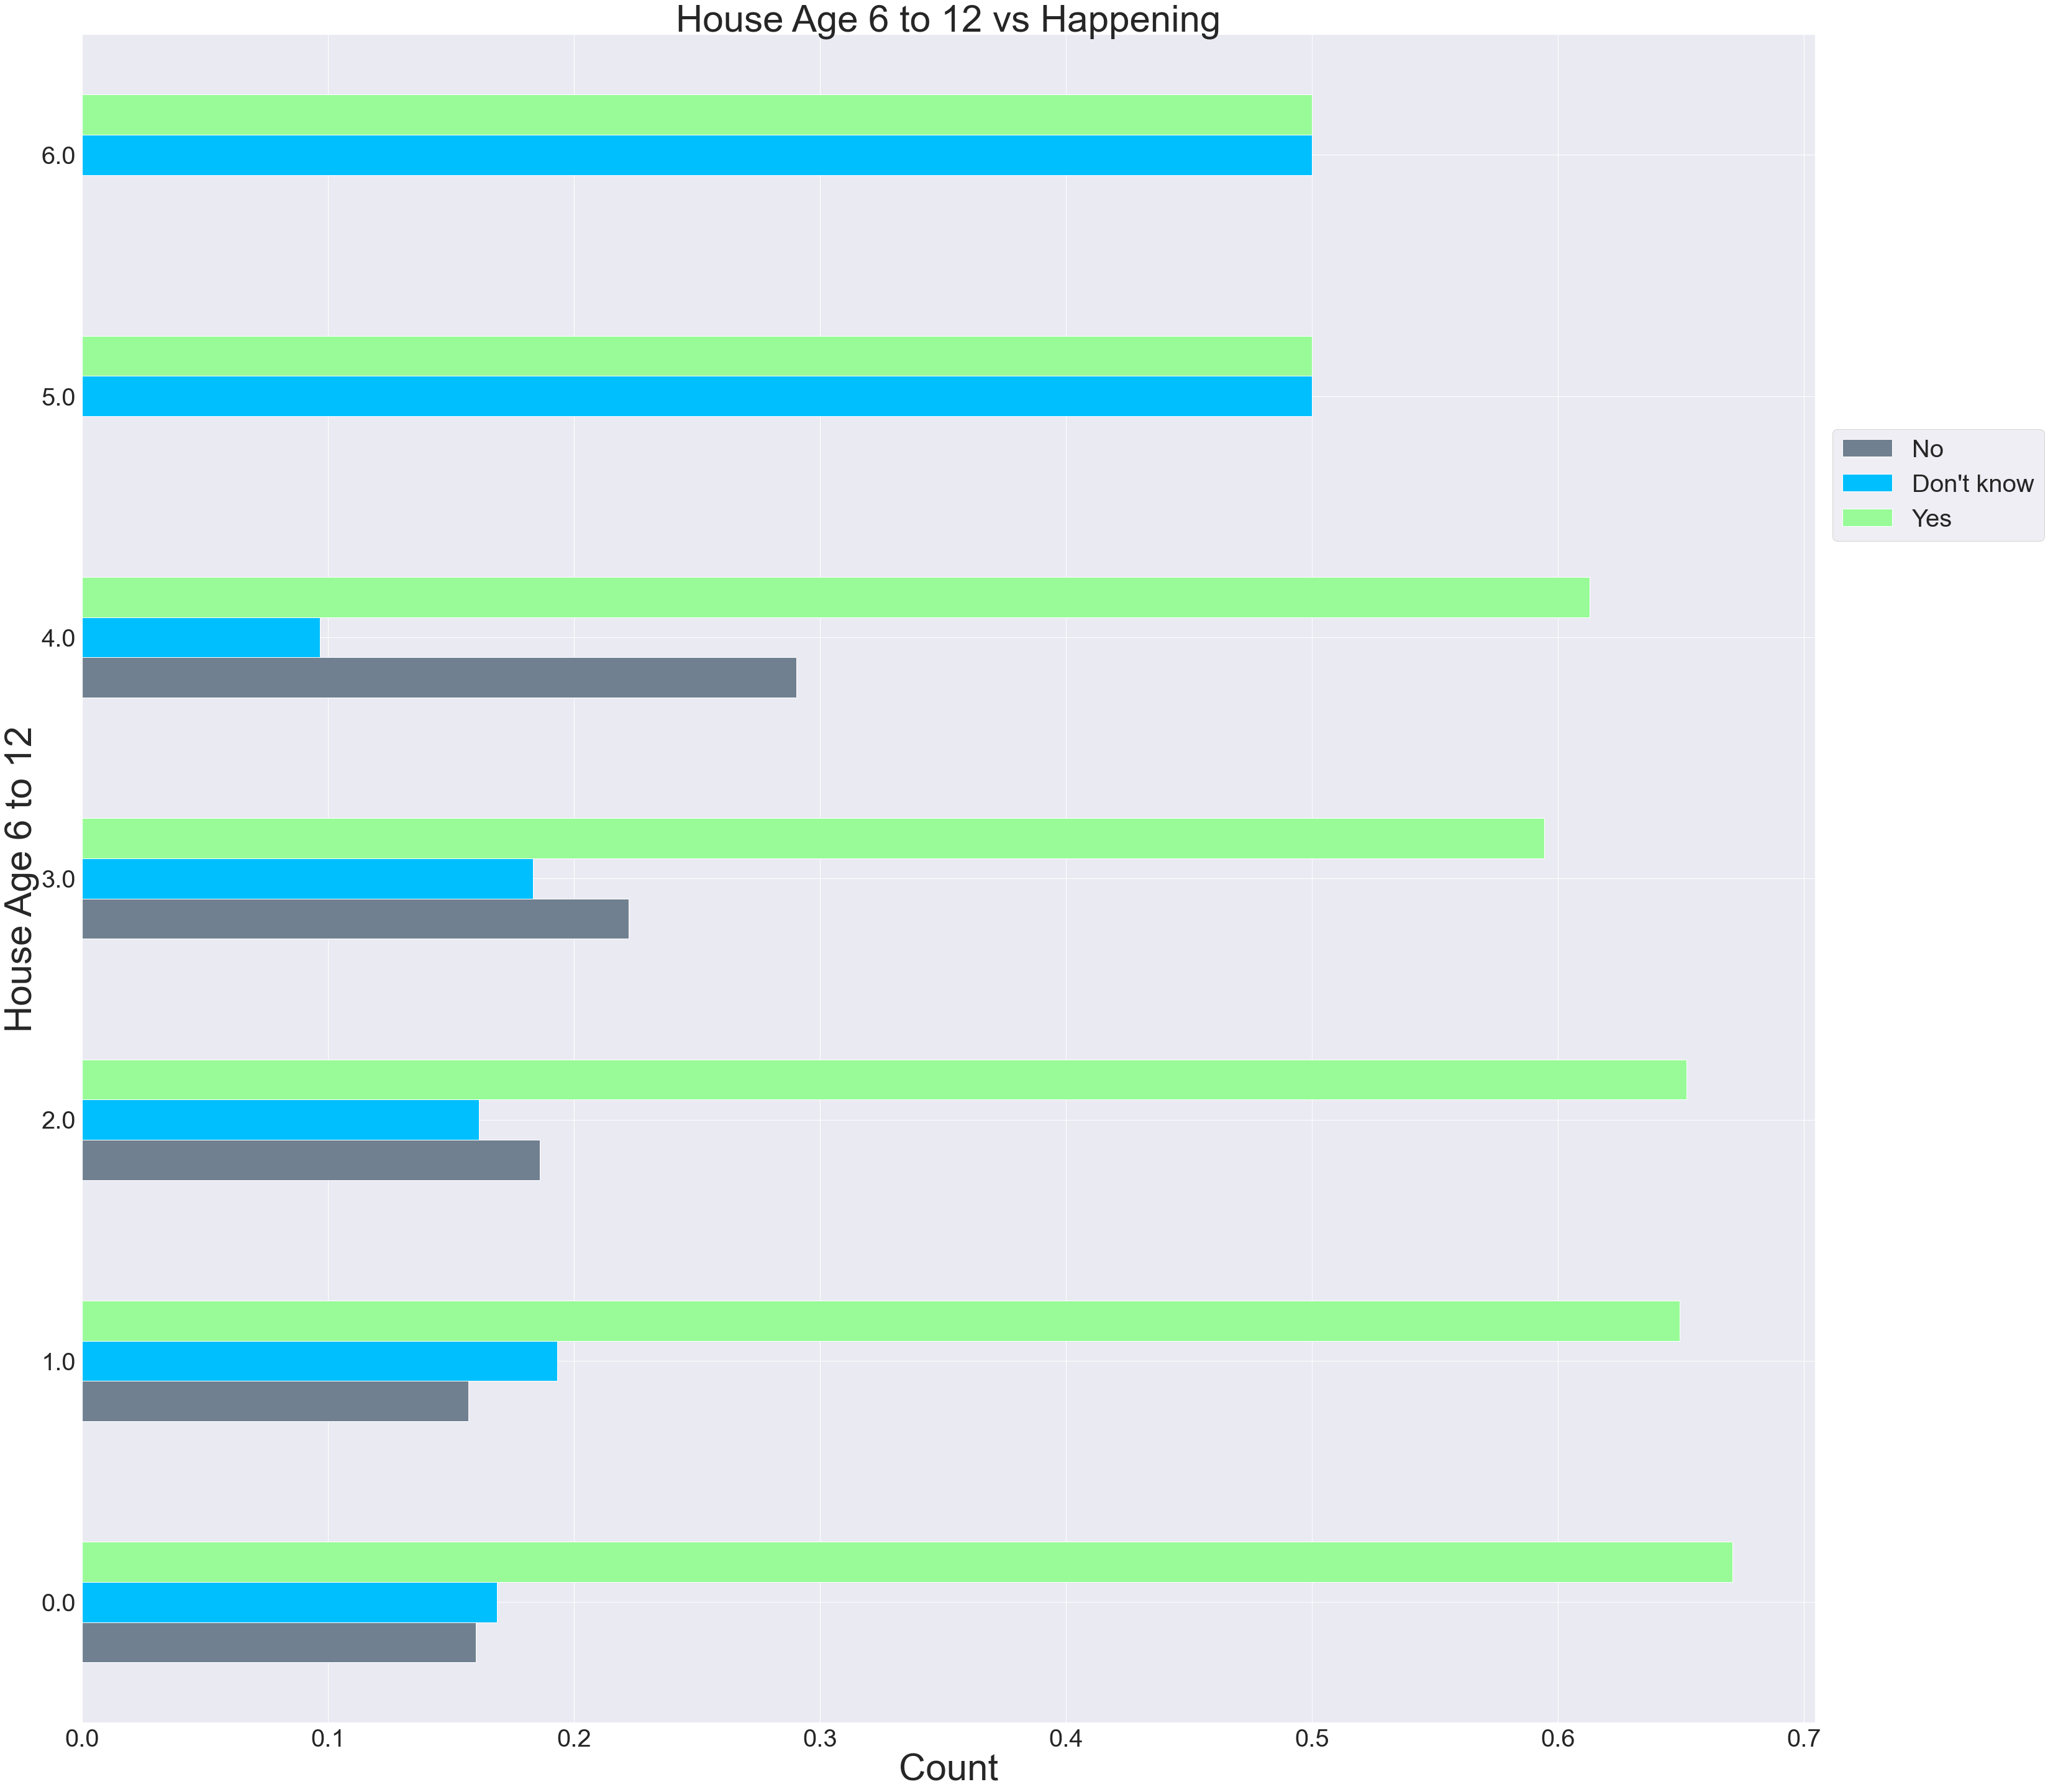

In [203]:
ax = df.groupby('house_ages6to12')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 6 to 12',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 6 to 12 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 6 to 12.** 
- **0 is the dominant group** 


In [204]:
df.house_ages13to17.value_counts(normalize=True)

0.0    0.853524
1.0    0.109868
2.0    0.031774
3.0    0.004162
4.0    0.000671
Name: house_ages13to17, dtype: float64

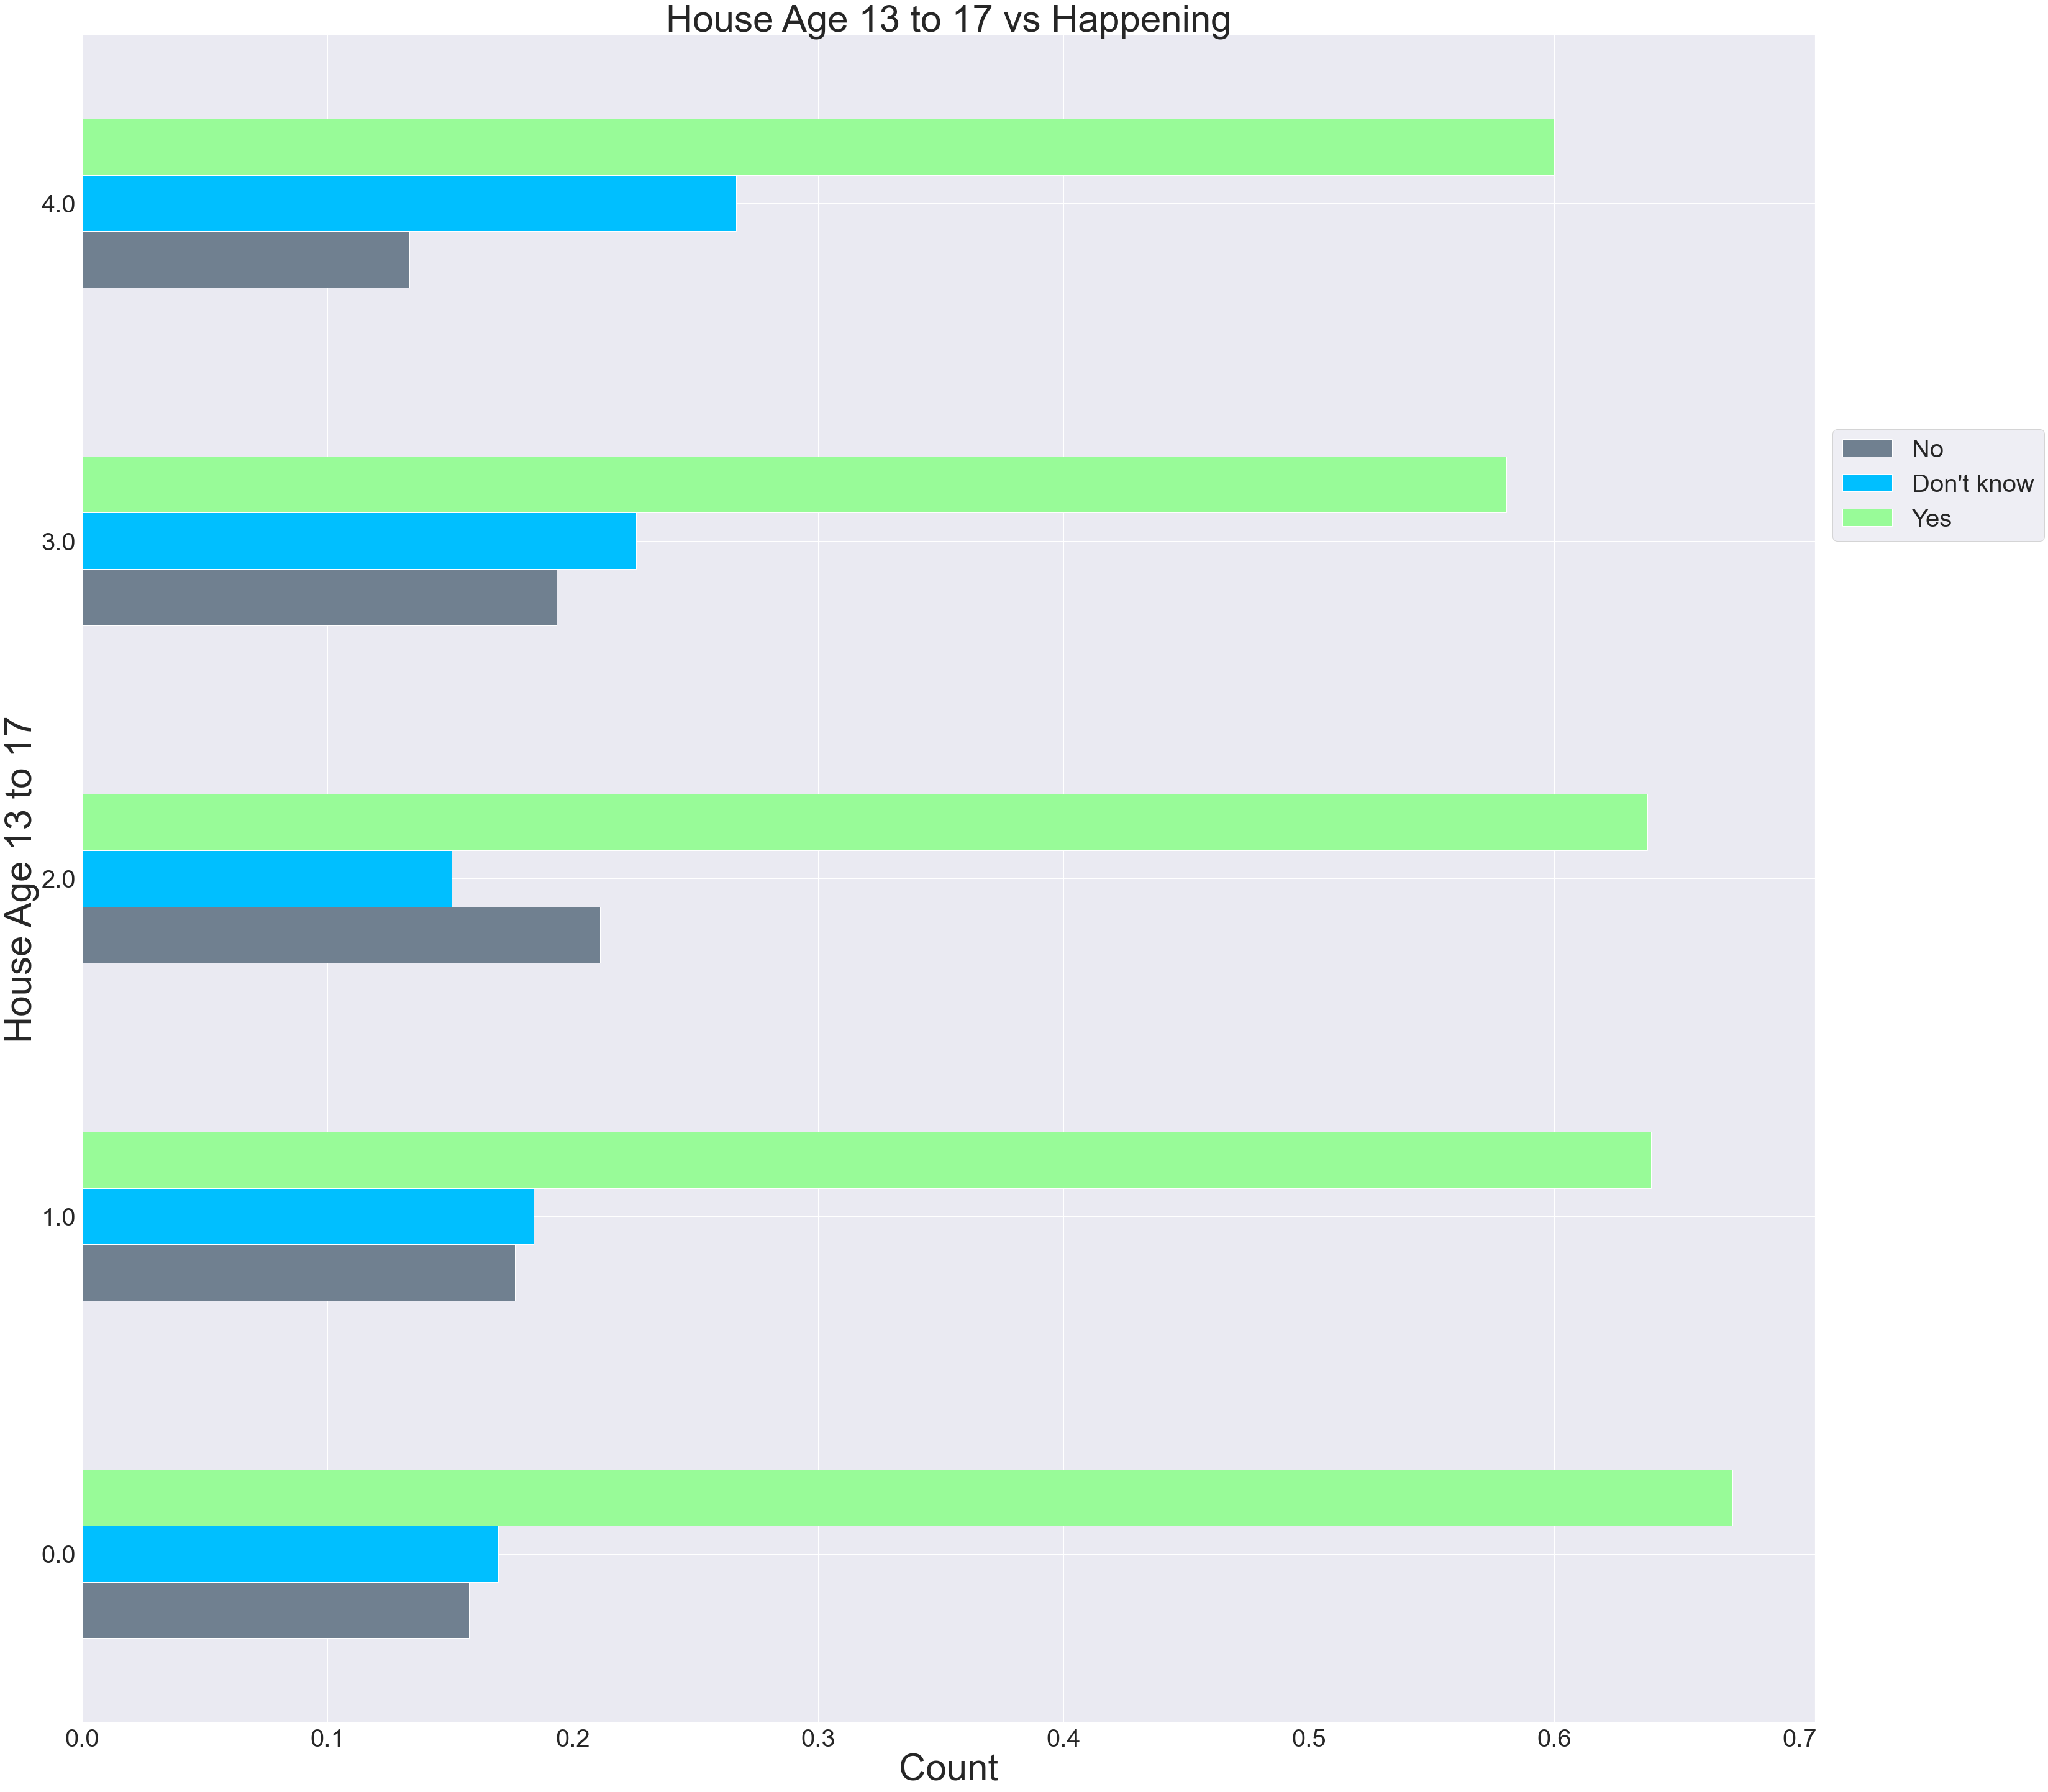

In [205]:
ax = df.groupby('house_ages13to17')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 13 to 17',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 13 to 17 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 13 to 17.** 
- **0 is the dominant group** 


In [206]:
df.house_ages18plus.value_counts(normalize=True)

2.0     0.554800
1.0     0.215887
3.0     0.147997
4.0     0.058089
5.0     0.015842
6.0     0.004162
7.0     0.002059
8.0     0.000582
12.0    0.000358
9.0     0.000134
10.0    0.000090
Name: house_ages18plus, dtype: float64

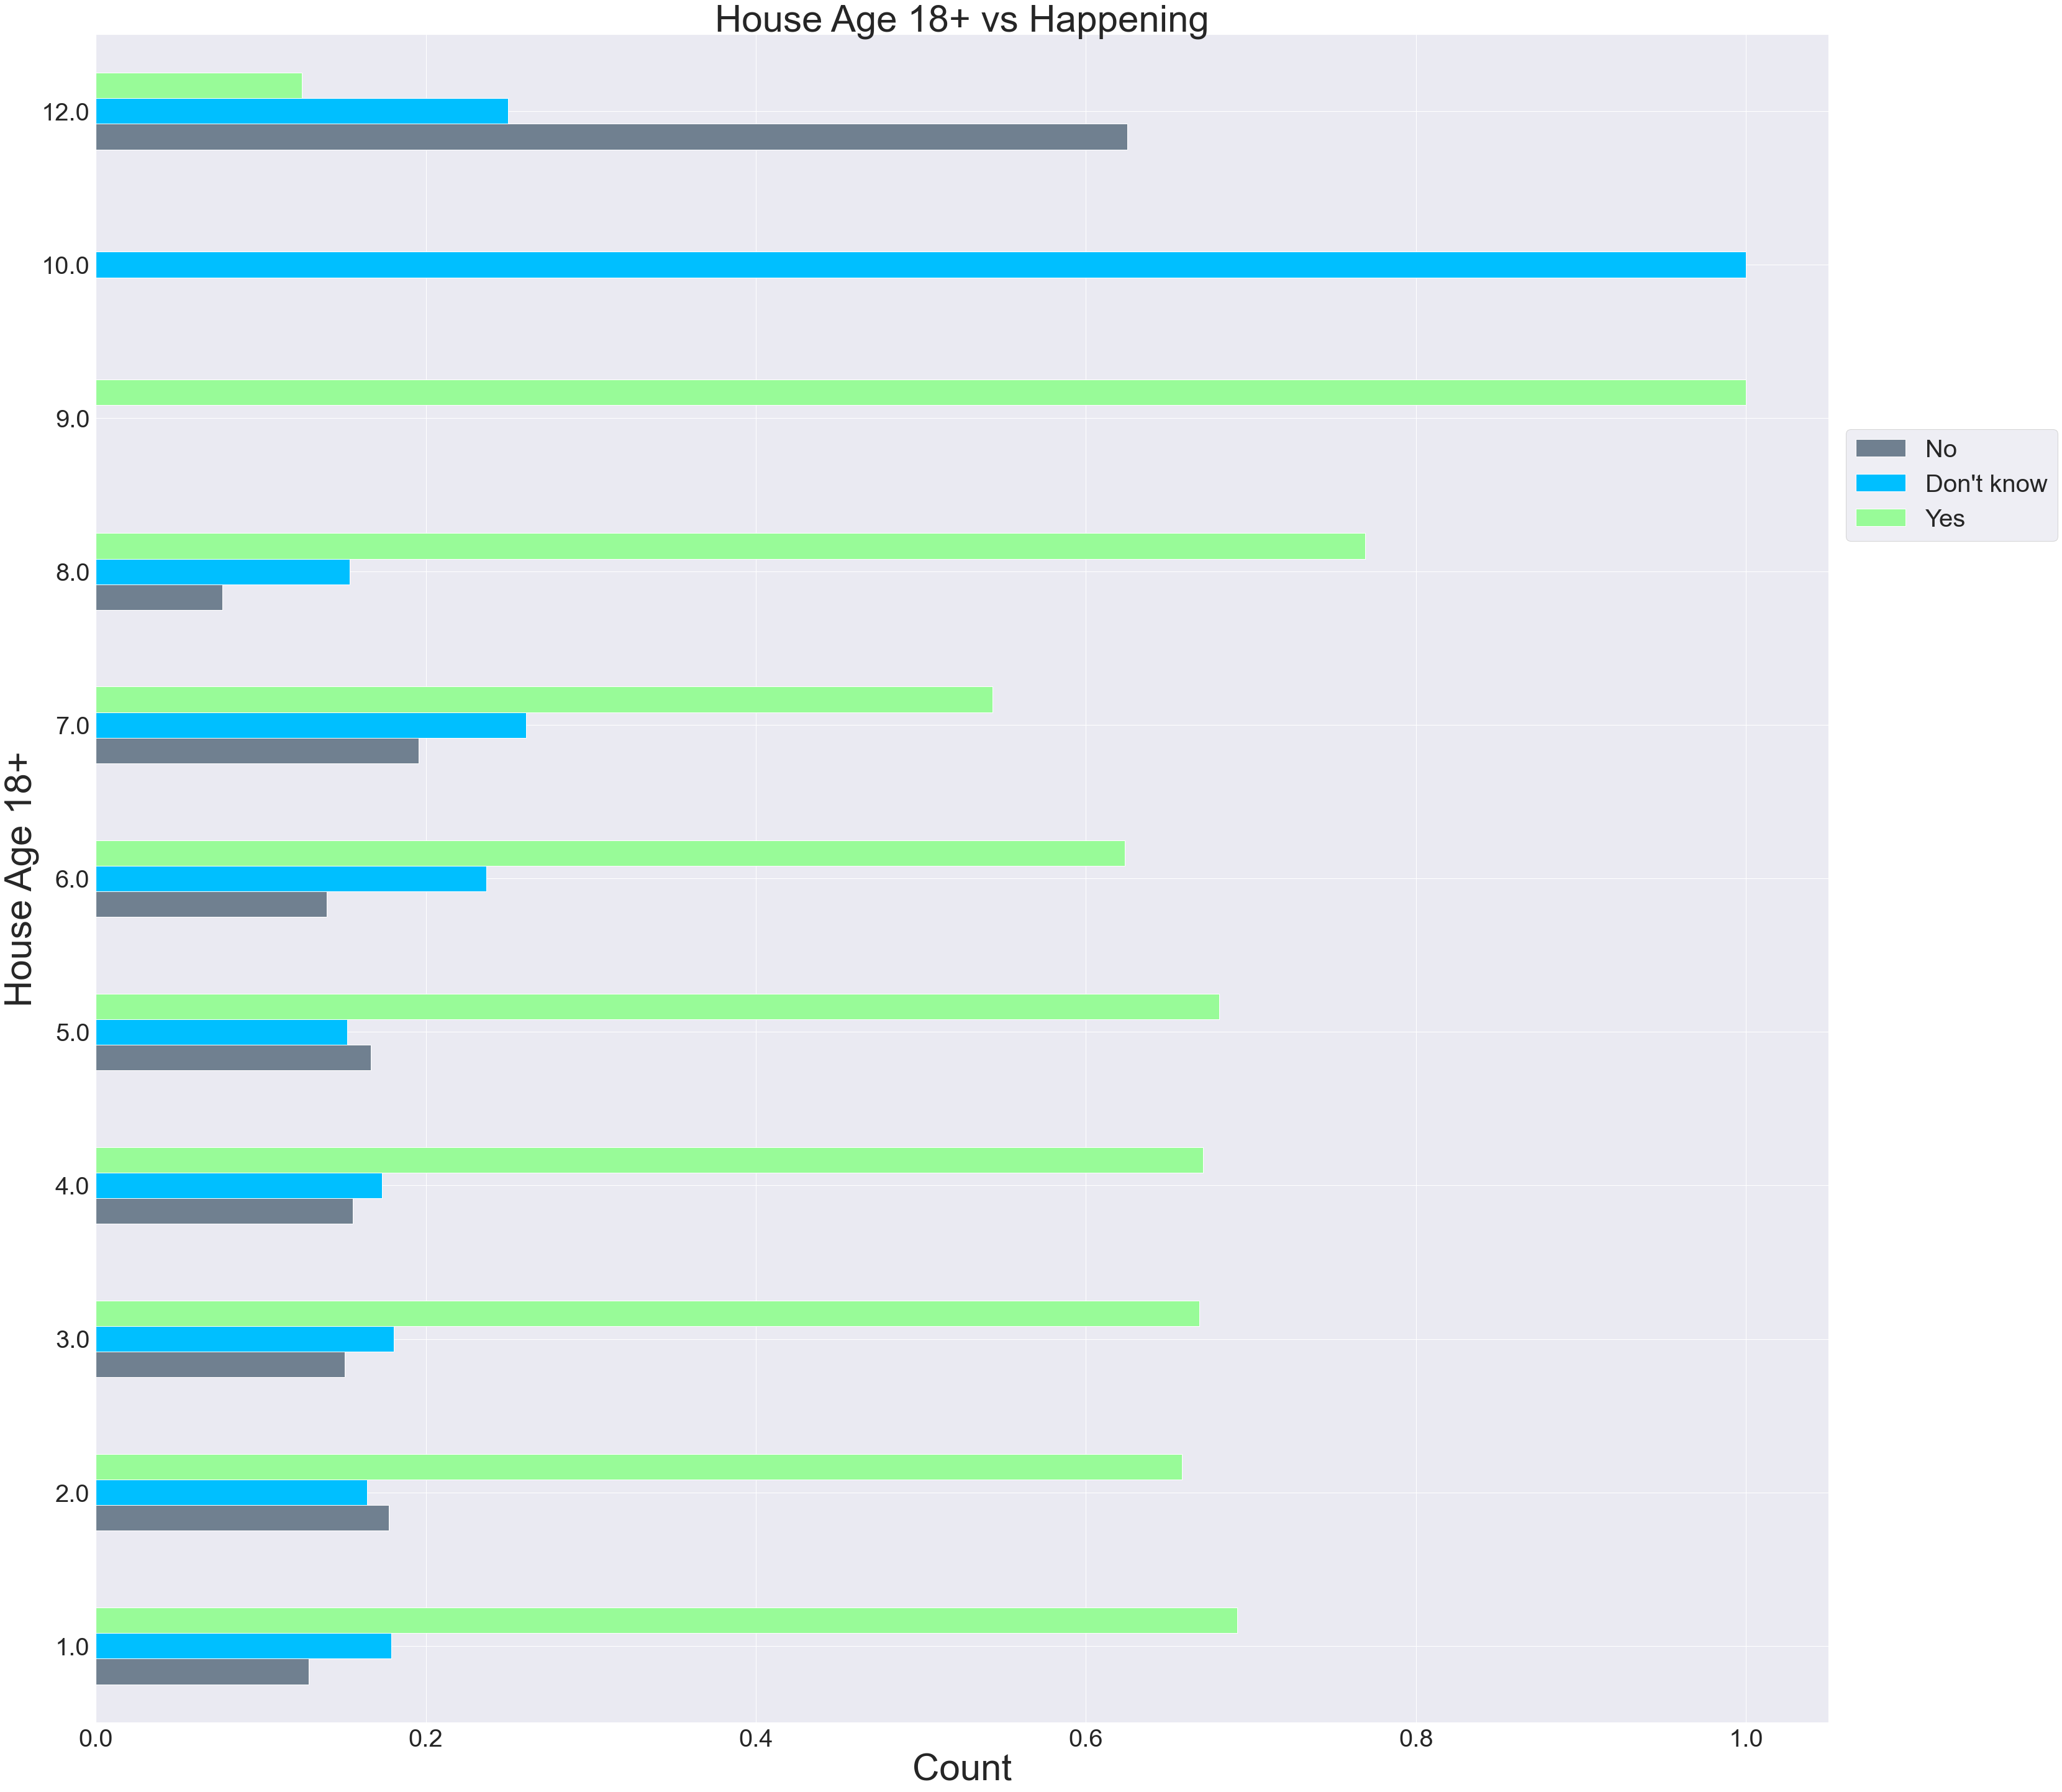

In [207]:
ax = df.groupby('house_ages18plus')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 18+',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 18+ vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 18+.** 
- **0 is the dominant group** 


In [208]:
df.house_type.value_counts(normalize=True)

One-family house detached from any other house                                    0.722309
Building with 2 or more apartments                                                0.155023
One-family house attached to one or more houses (such as a condo or townhouse)    0.075811
Mobile home                                                                       0.044350
Boat, RV, van, etc.                                                               0.002506
Name: house_type, dtype: float64

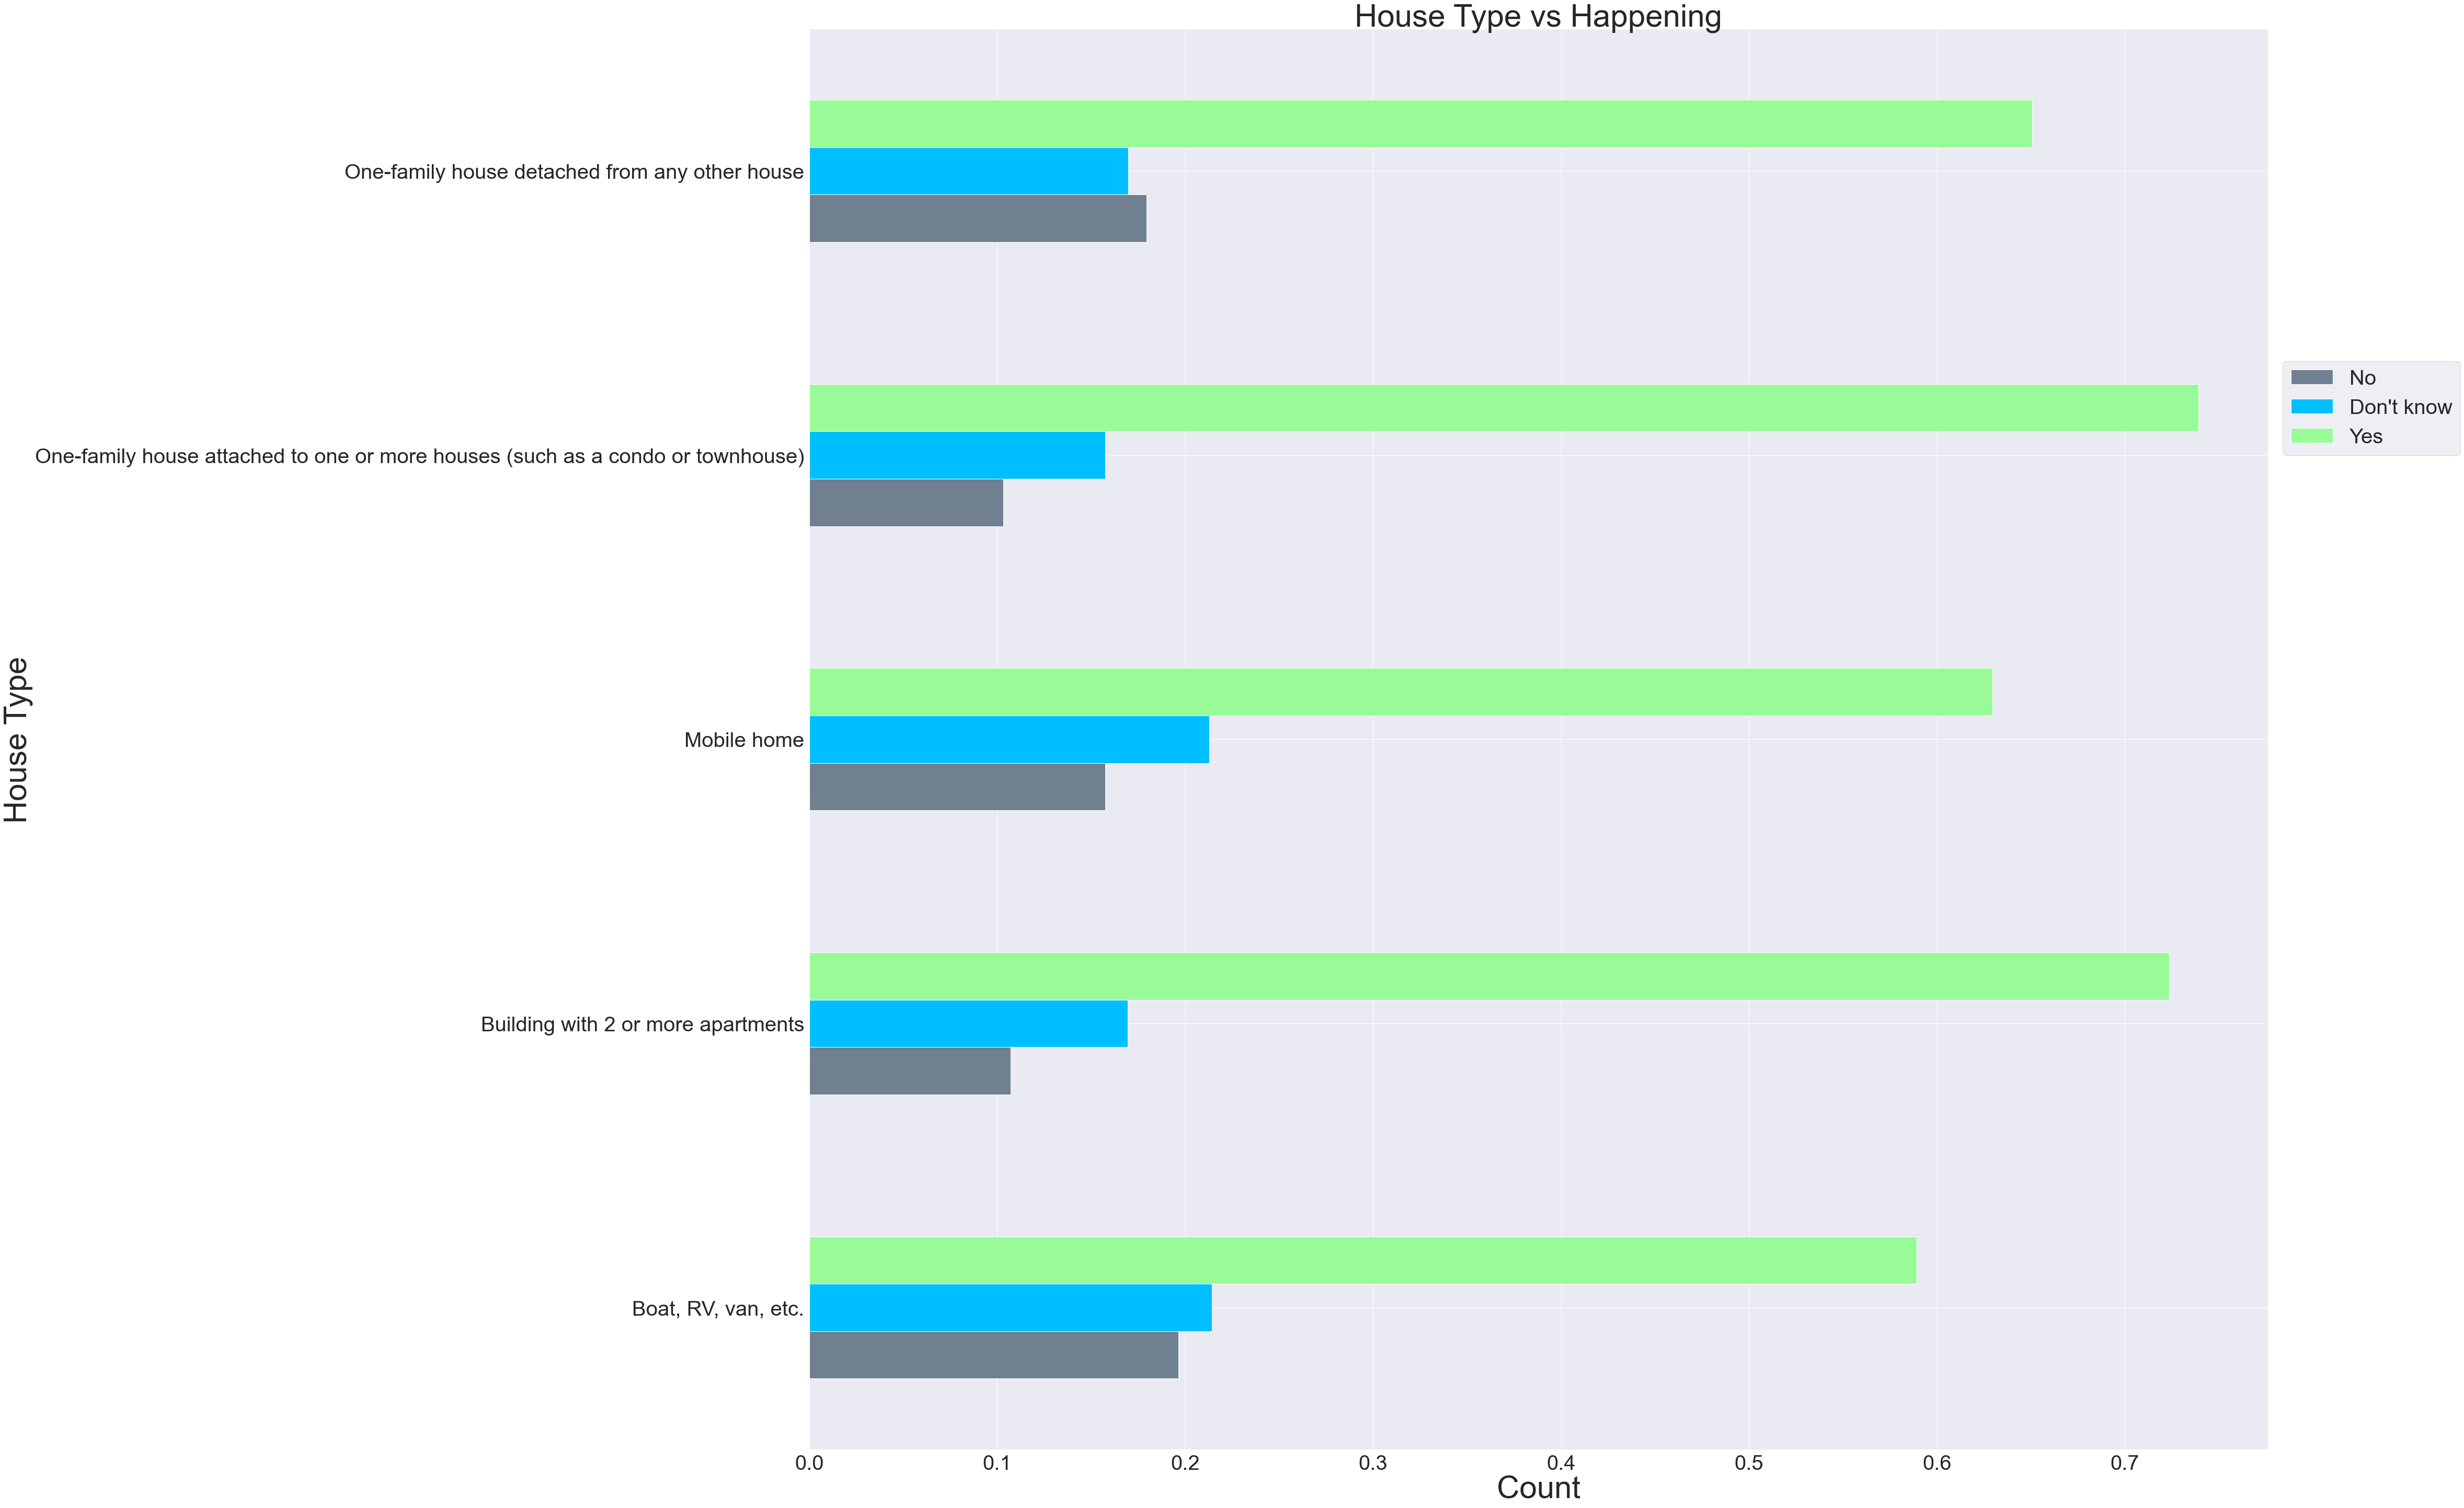

In [209]:
ax = df.groupby('house_type')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **One family house are pre-dominant.** 
- **People with mobile homes seem to have a higher proportion of non-believers of climate change** 


In [210]:
df.house_own.value_counts(normalize=True)

Owned by you or someone in your household    0.746565
Rented                                       0.229447
Occupied without payment of rent             0.023987
Name: house_own, dtype: float64

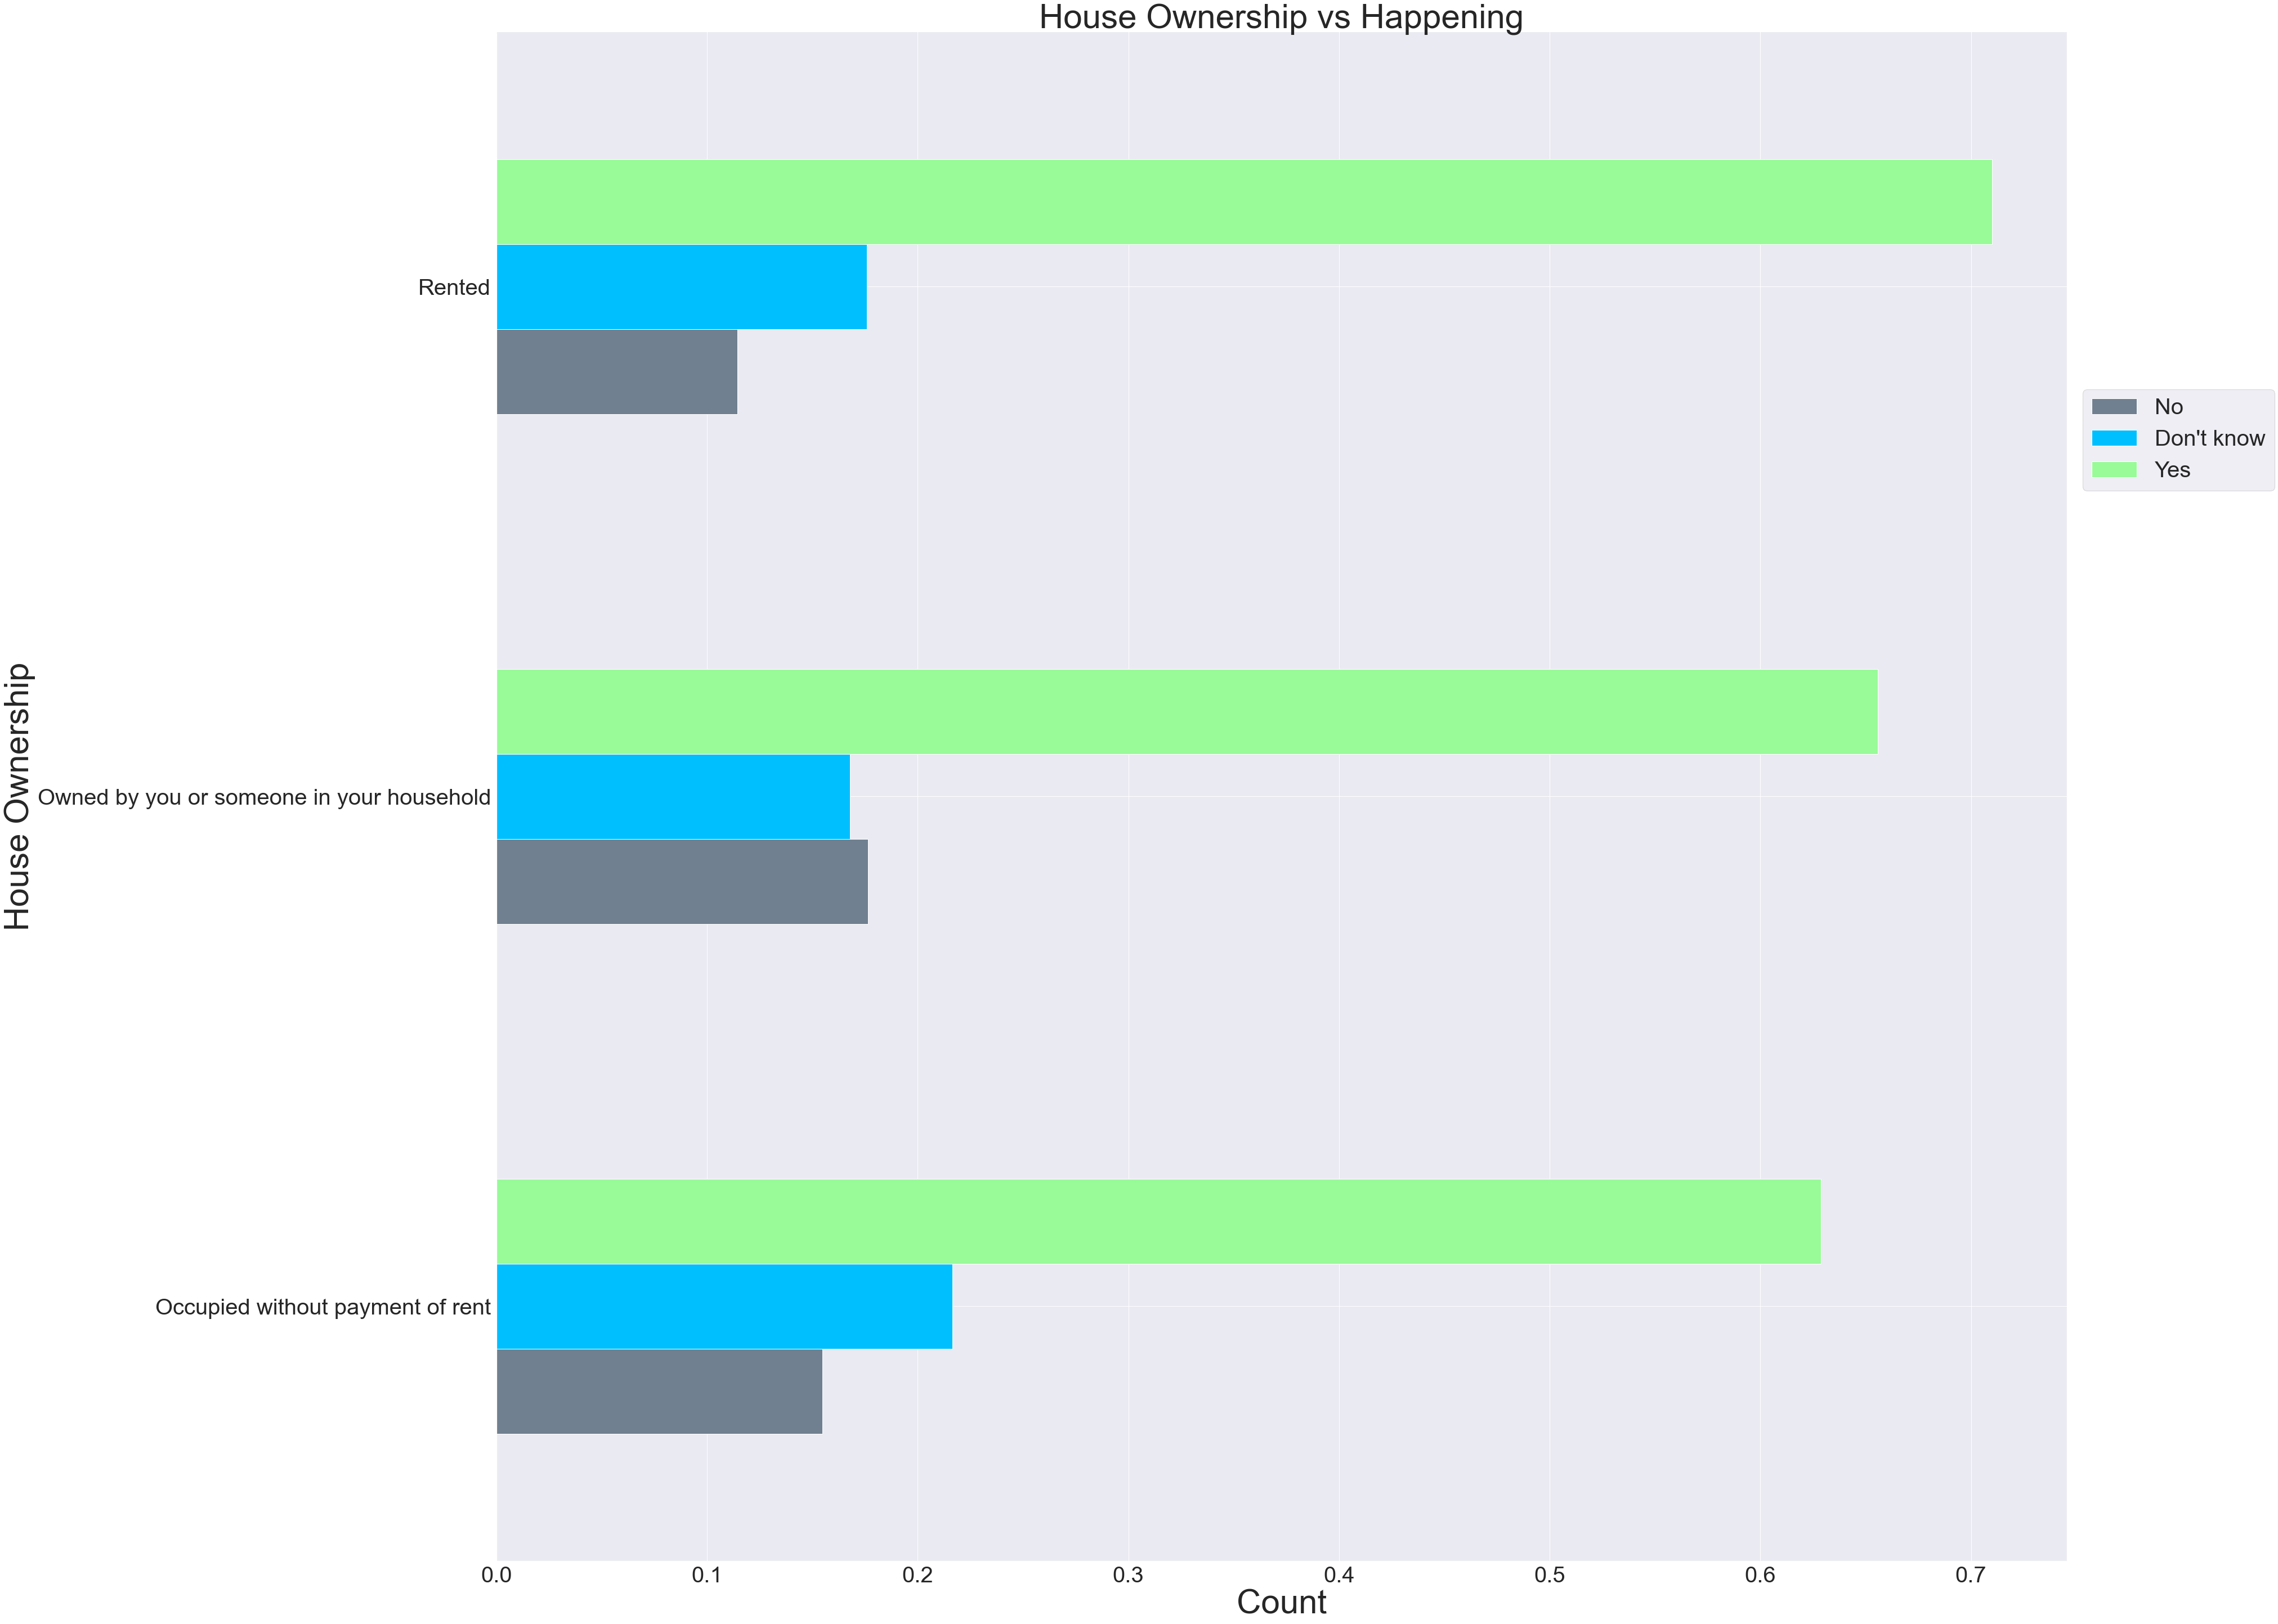

In [211]:
ax = df.groupby('house_own')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Ownership',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Ownership vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **houses owned by an individual or a family member are pre-dominant.** 


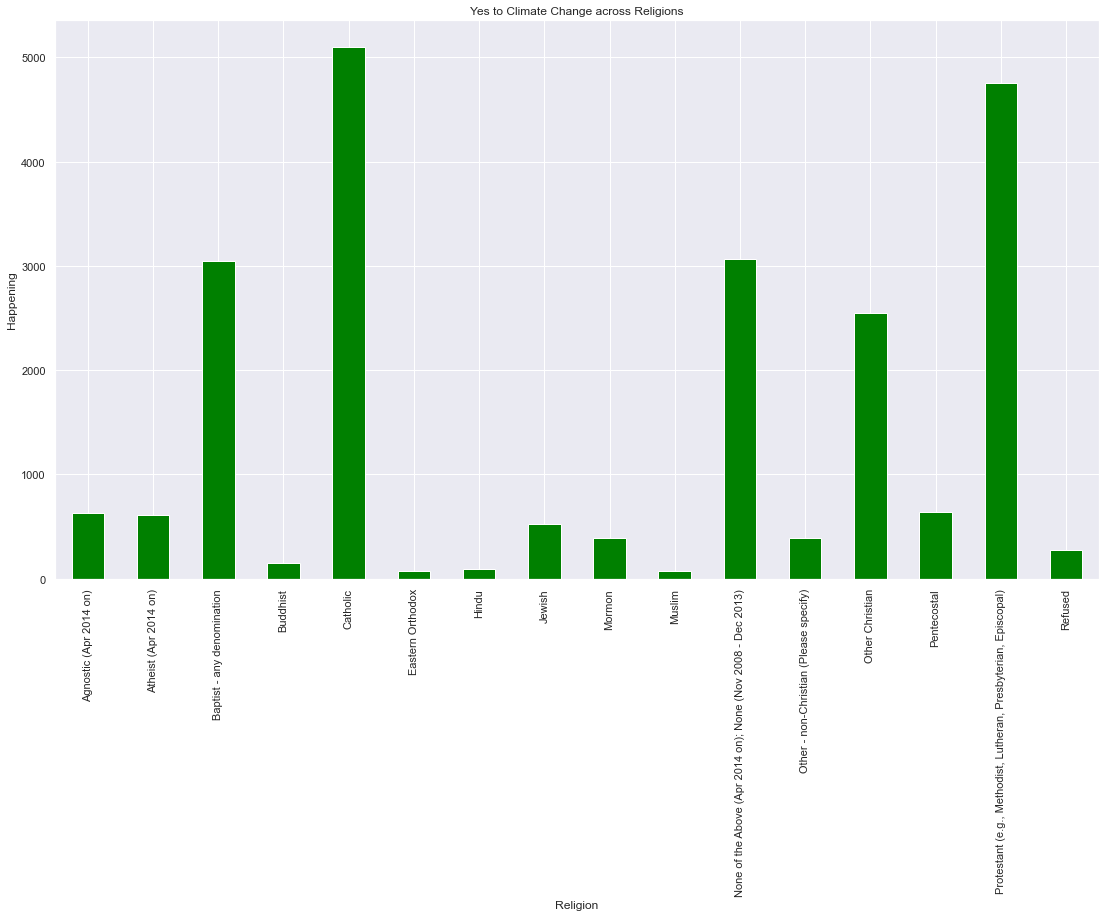

In [212]:
ax = df.groupby(['religion'])['happening'].count().plot(kind='bar',stacked = True, color='green')
ax.set_xlabel('Religion')
ax.set_ylabel('Happening')
ax.set_title('Yes to Climate Change across Religions');




- **This graph represents the believers in climate change across religions.** 
- **The numbers vary due to different population of respective religion people** 
- **As expected for American society Catholic and Protestant have highest number of counts followed by Atheists and Baptists**

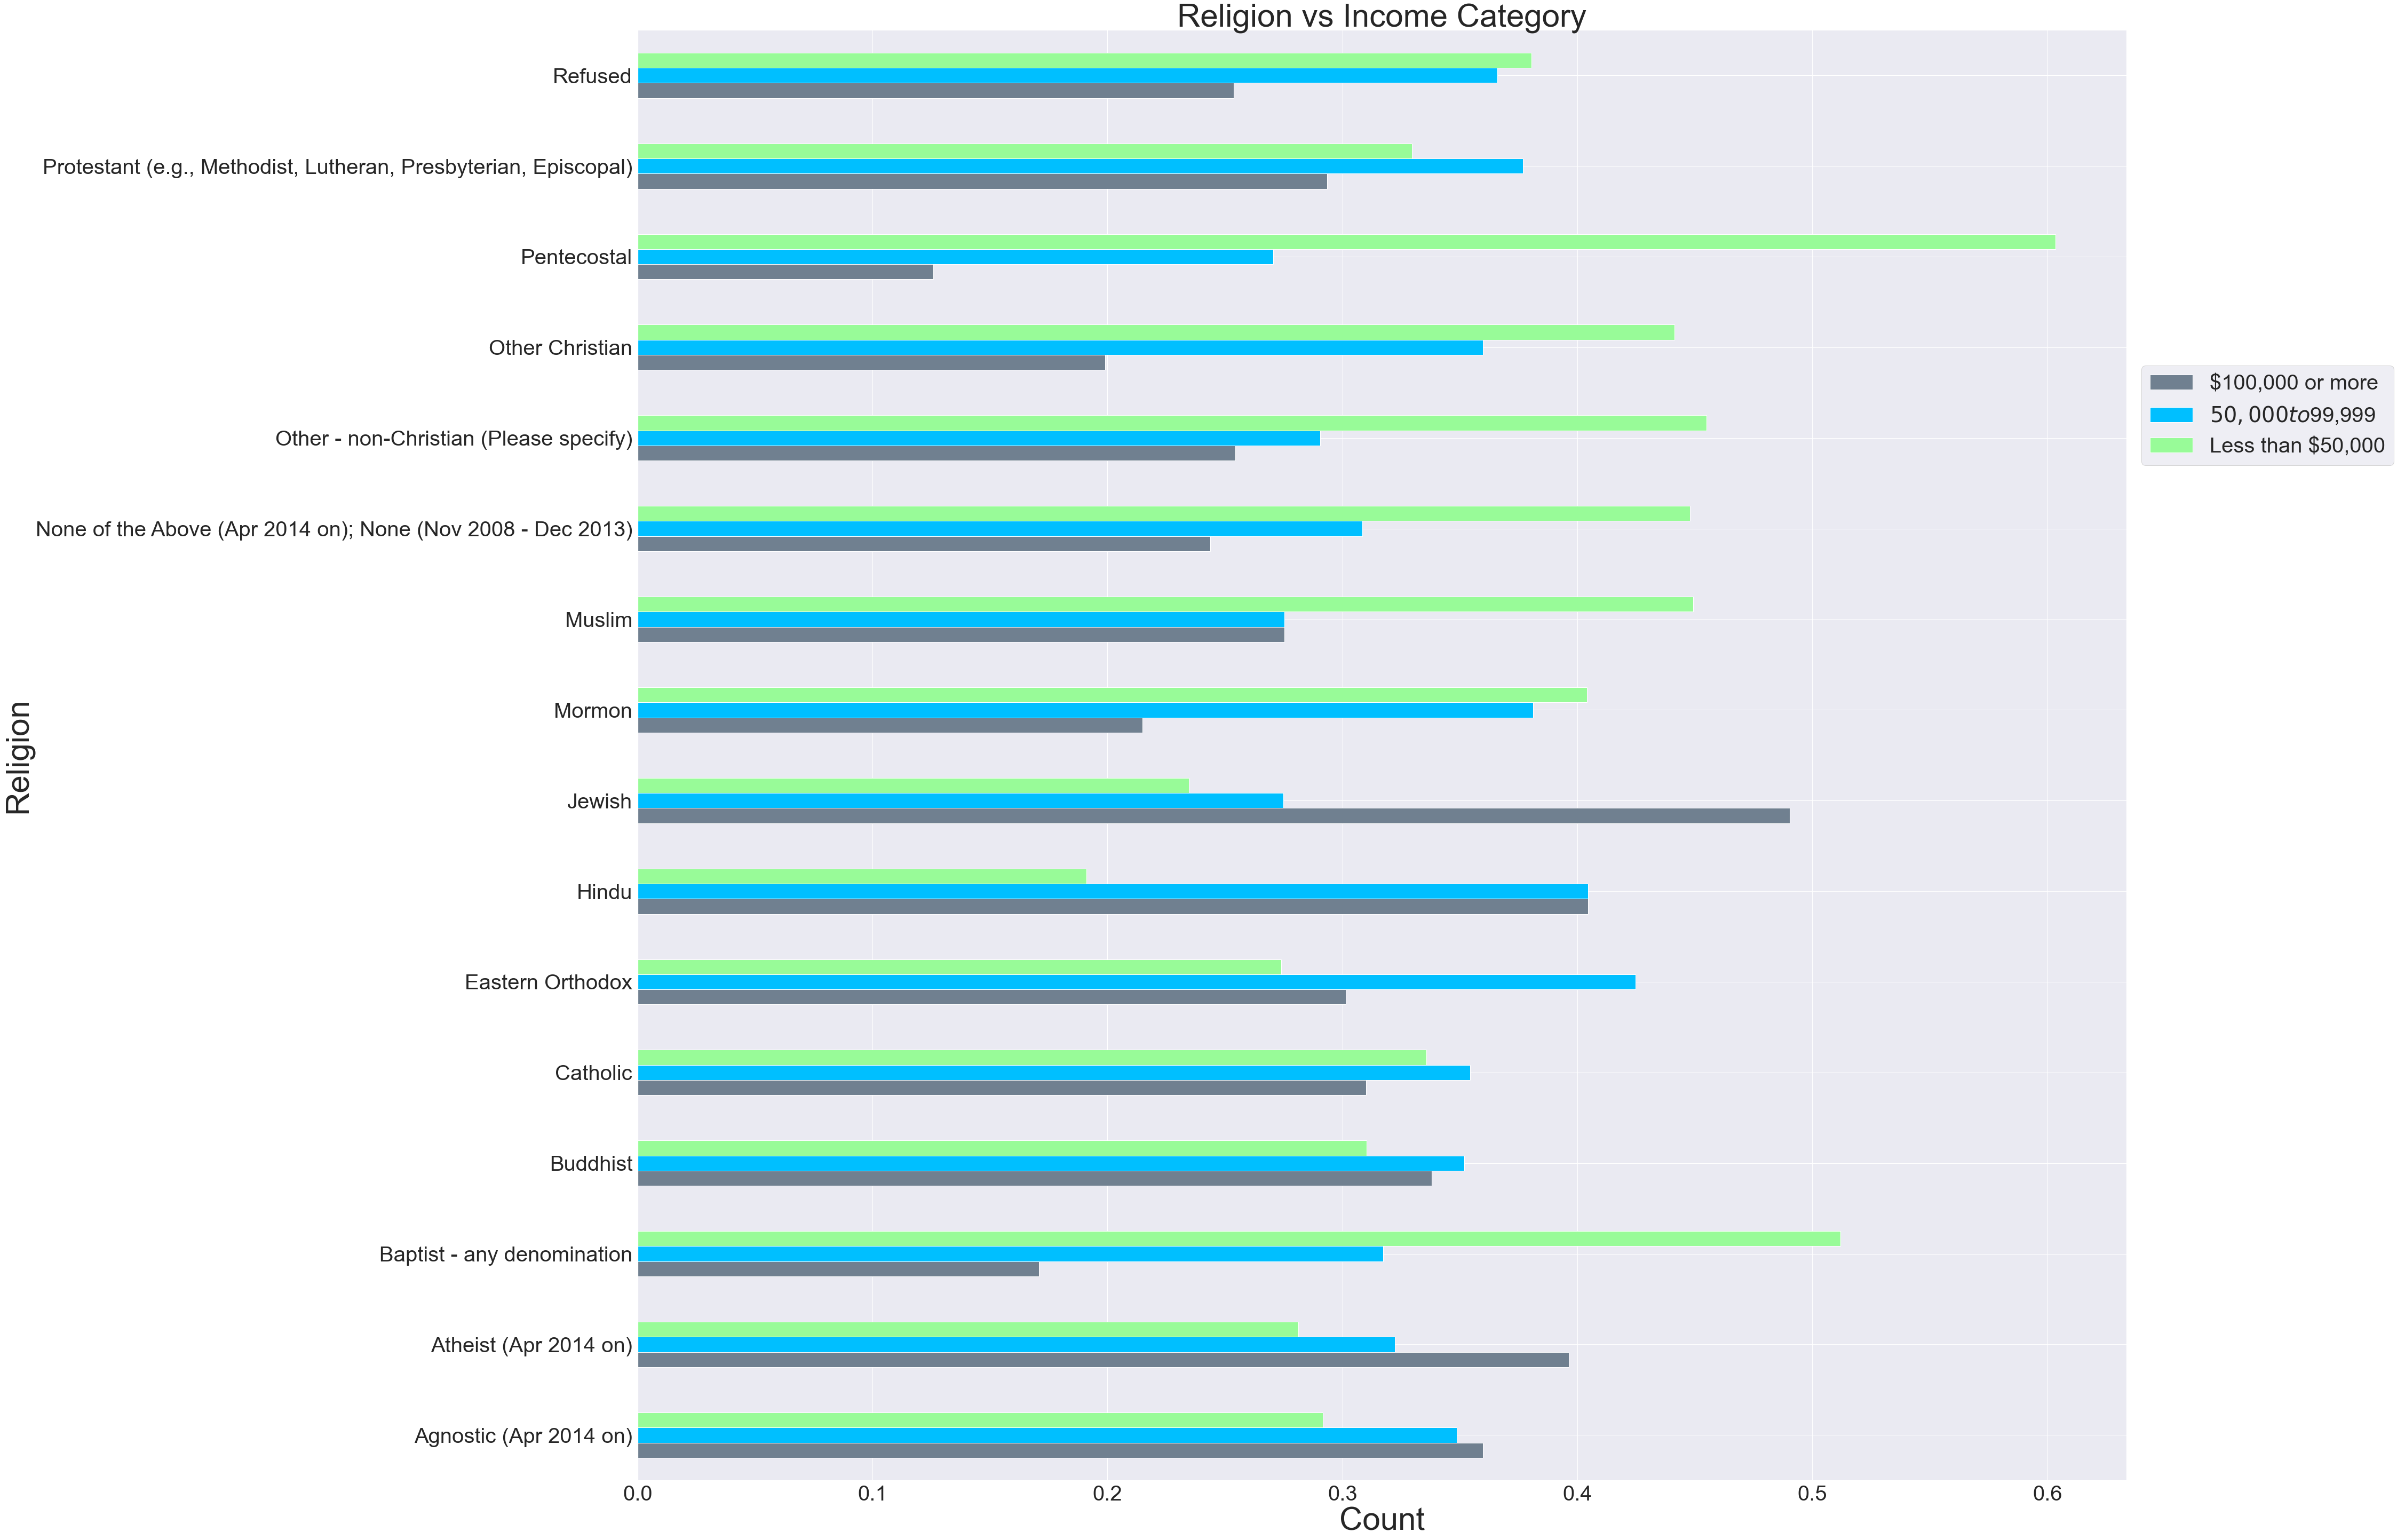

In [213]:
ax = df.groupby(['religion'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


- **High income category is prominent in Jewish, Atheist and Agnostic**
- **Middle income category is prominent in Protestant, Catholic, Eastern Orthodox**
- **Low Income category is predominant in all other religions**


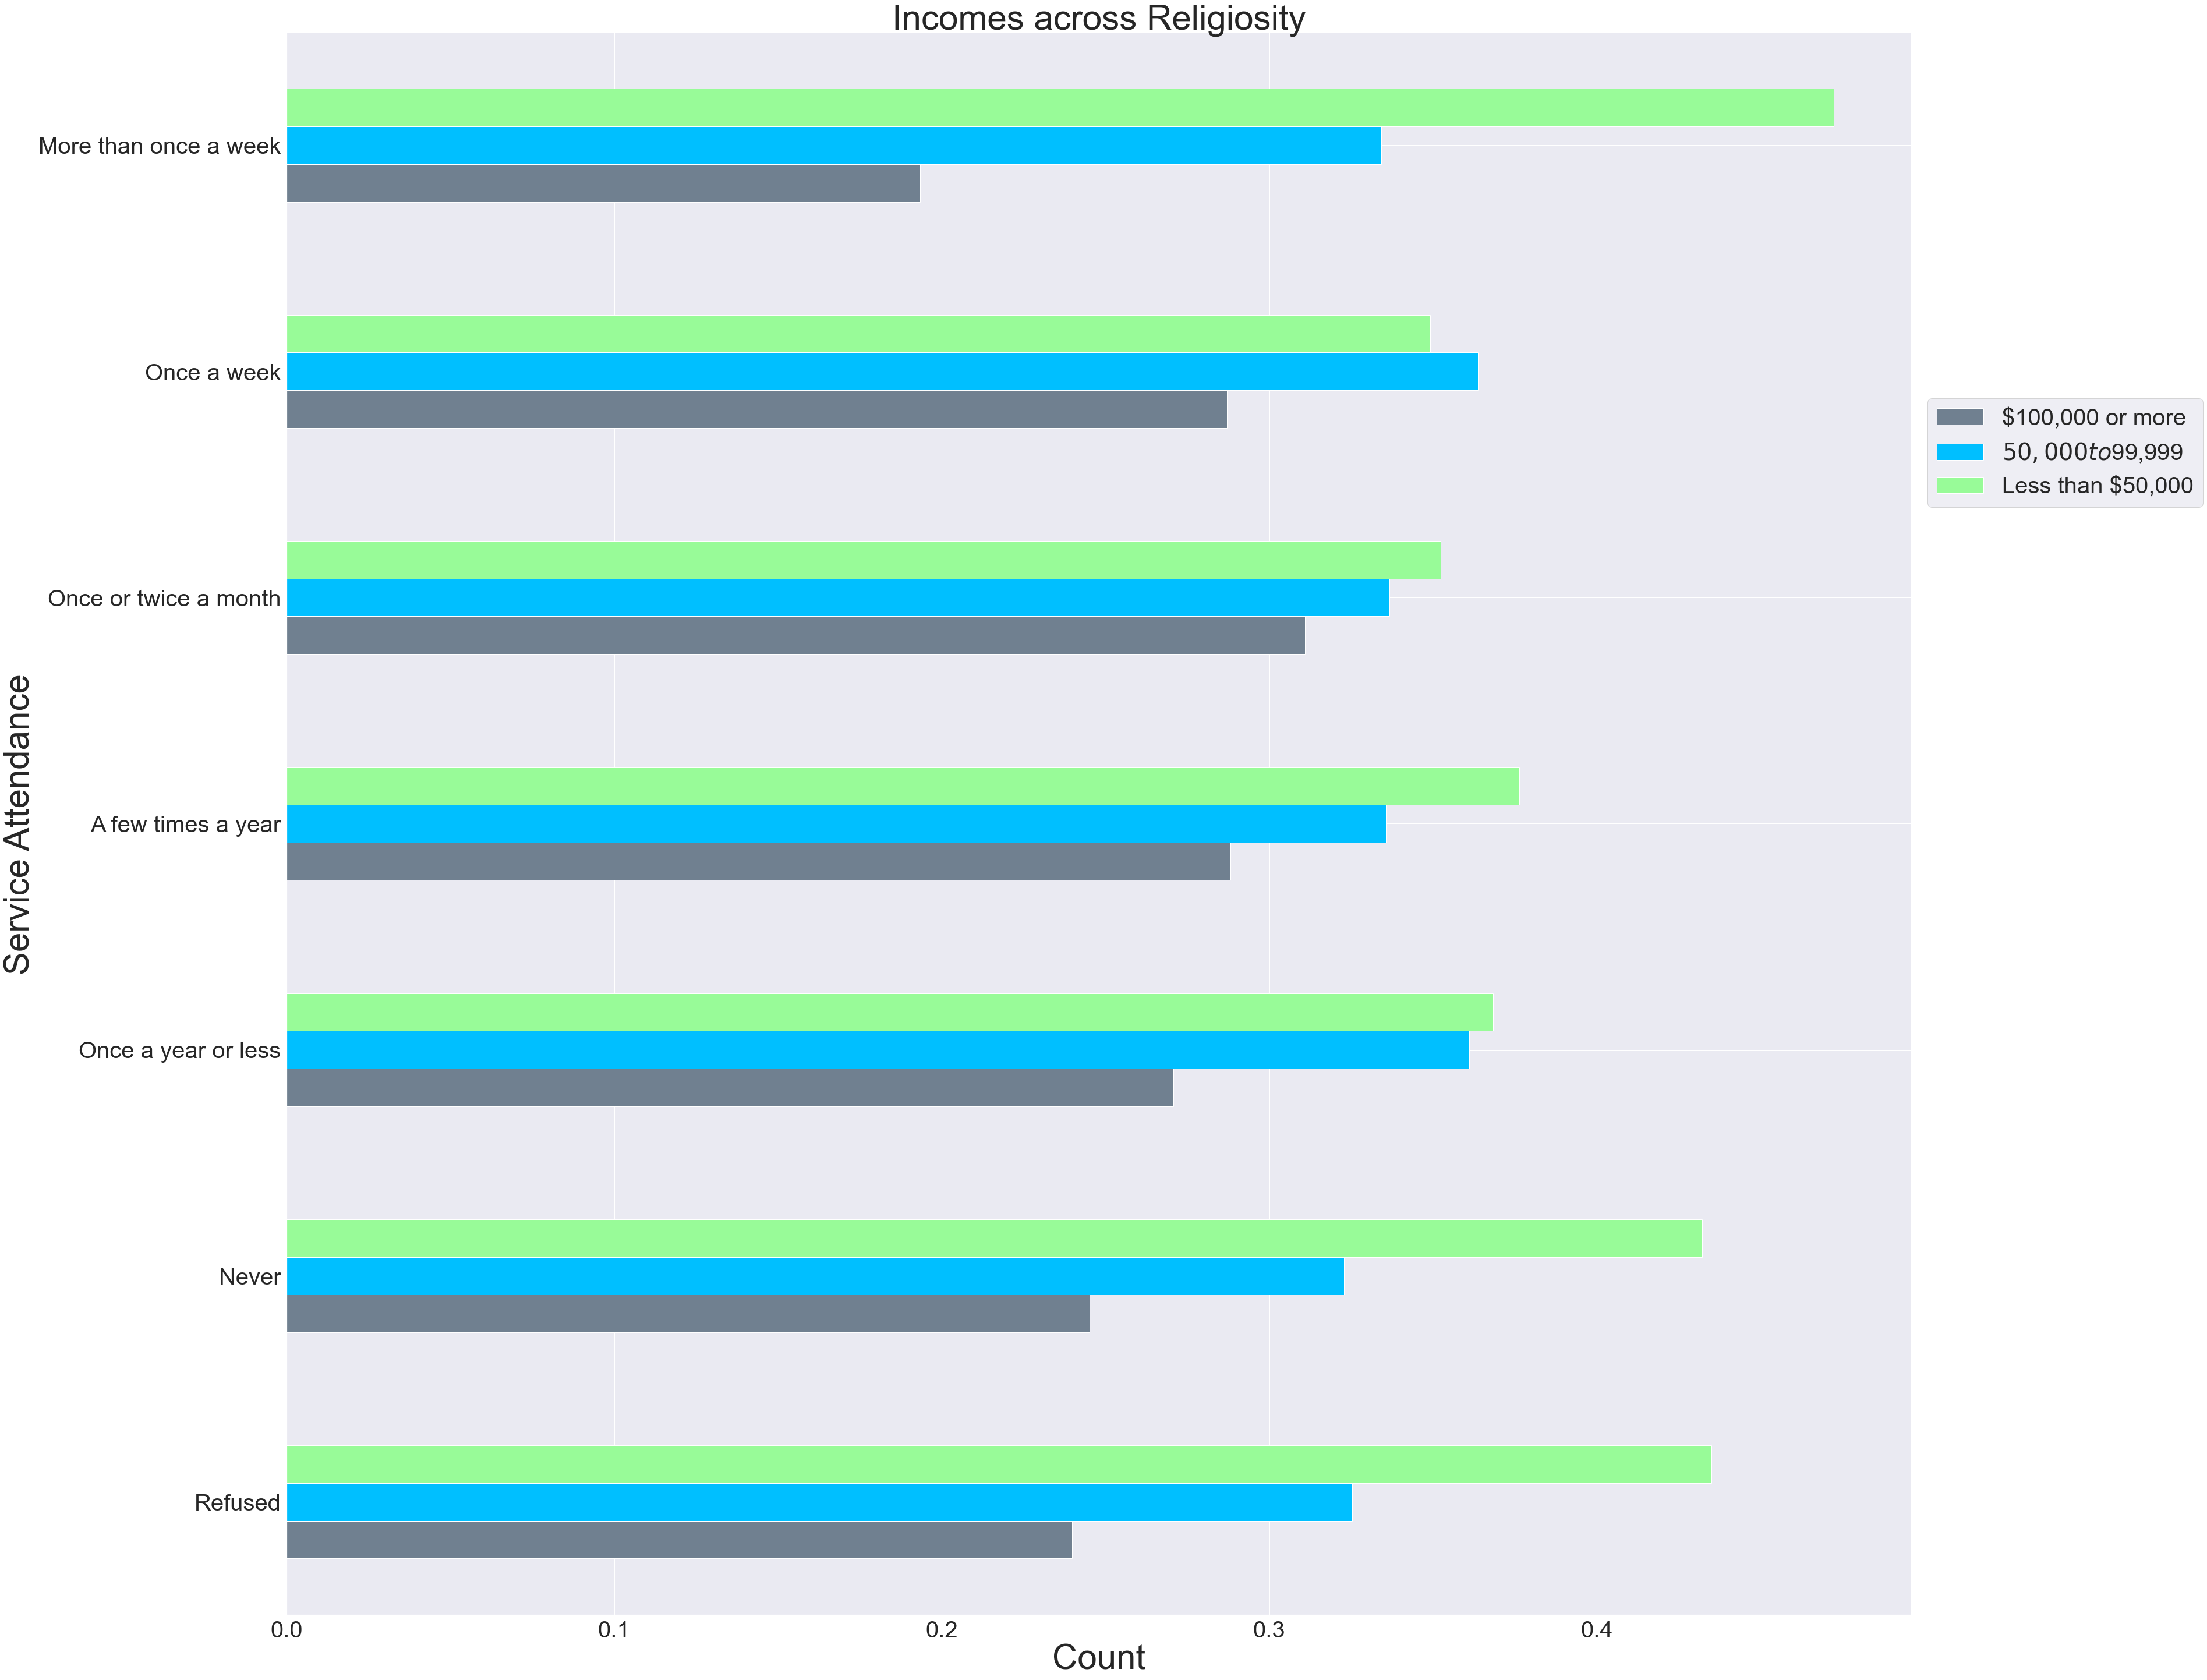

In [214]:
ax = df.groupby(['service_attendance'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
                color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Incomes across Religiosity',fontsize=60)
plt.setp(ax.get_xticklabels(), fontsize=40)
ax.set_yticklabels(['Refused','Never','Once a year or less','A few times a year','Once or twice a month','Once a week','More than once a week'],fontsize=40);
#-1. Refused
# 1. Never
# 2. Once a year or less
# 3. A few times a year
# 4. Once or twice a month
# 5. Once a week
# 6. More than once a week


- **To my surprise people who never go for service attendance(marked 1) have the most people in low income category**
- **Low income category is most represented across various groups**


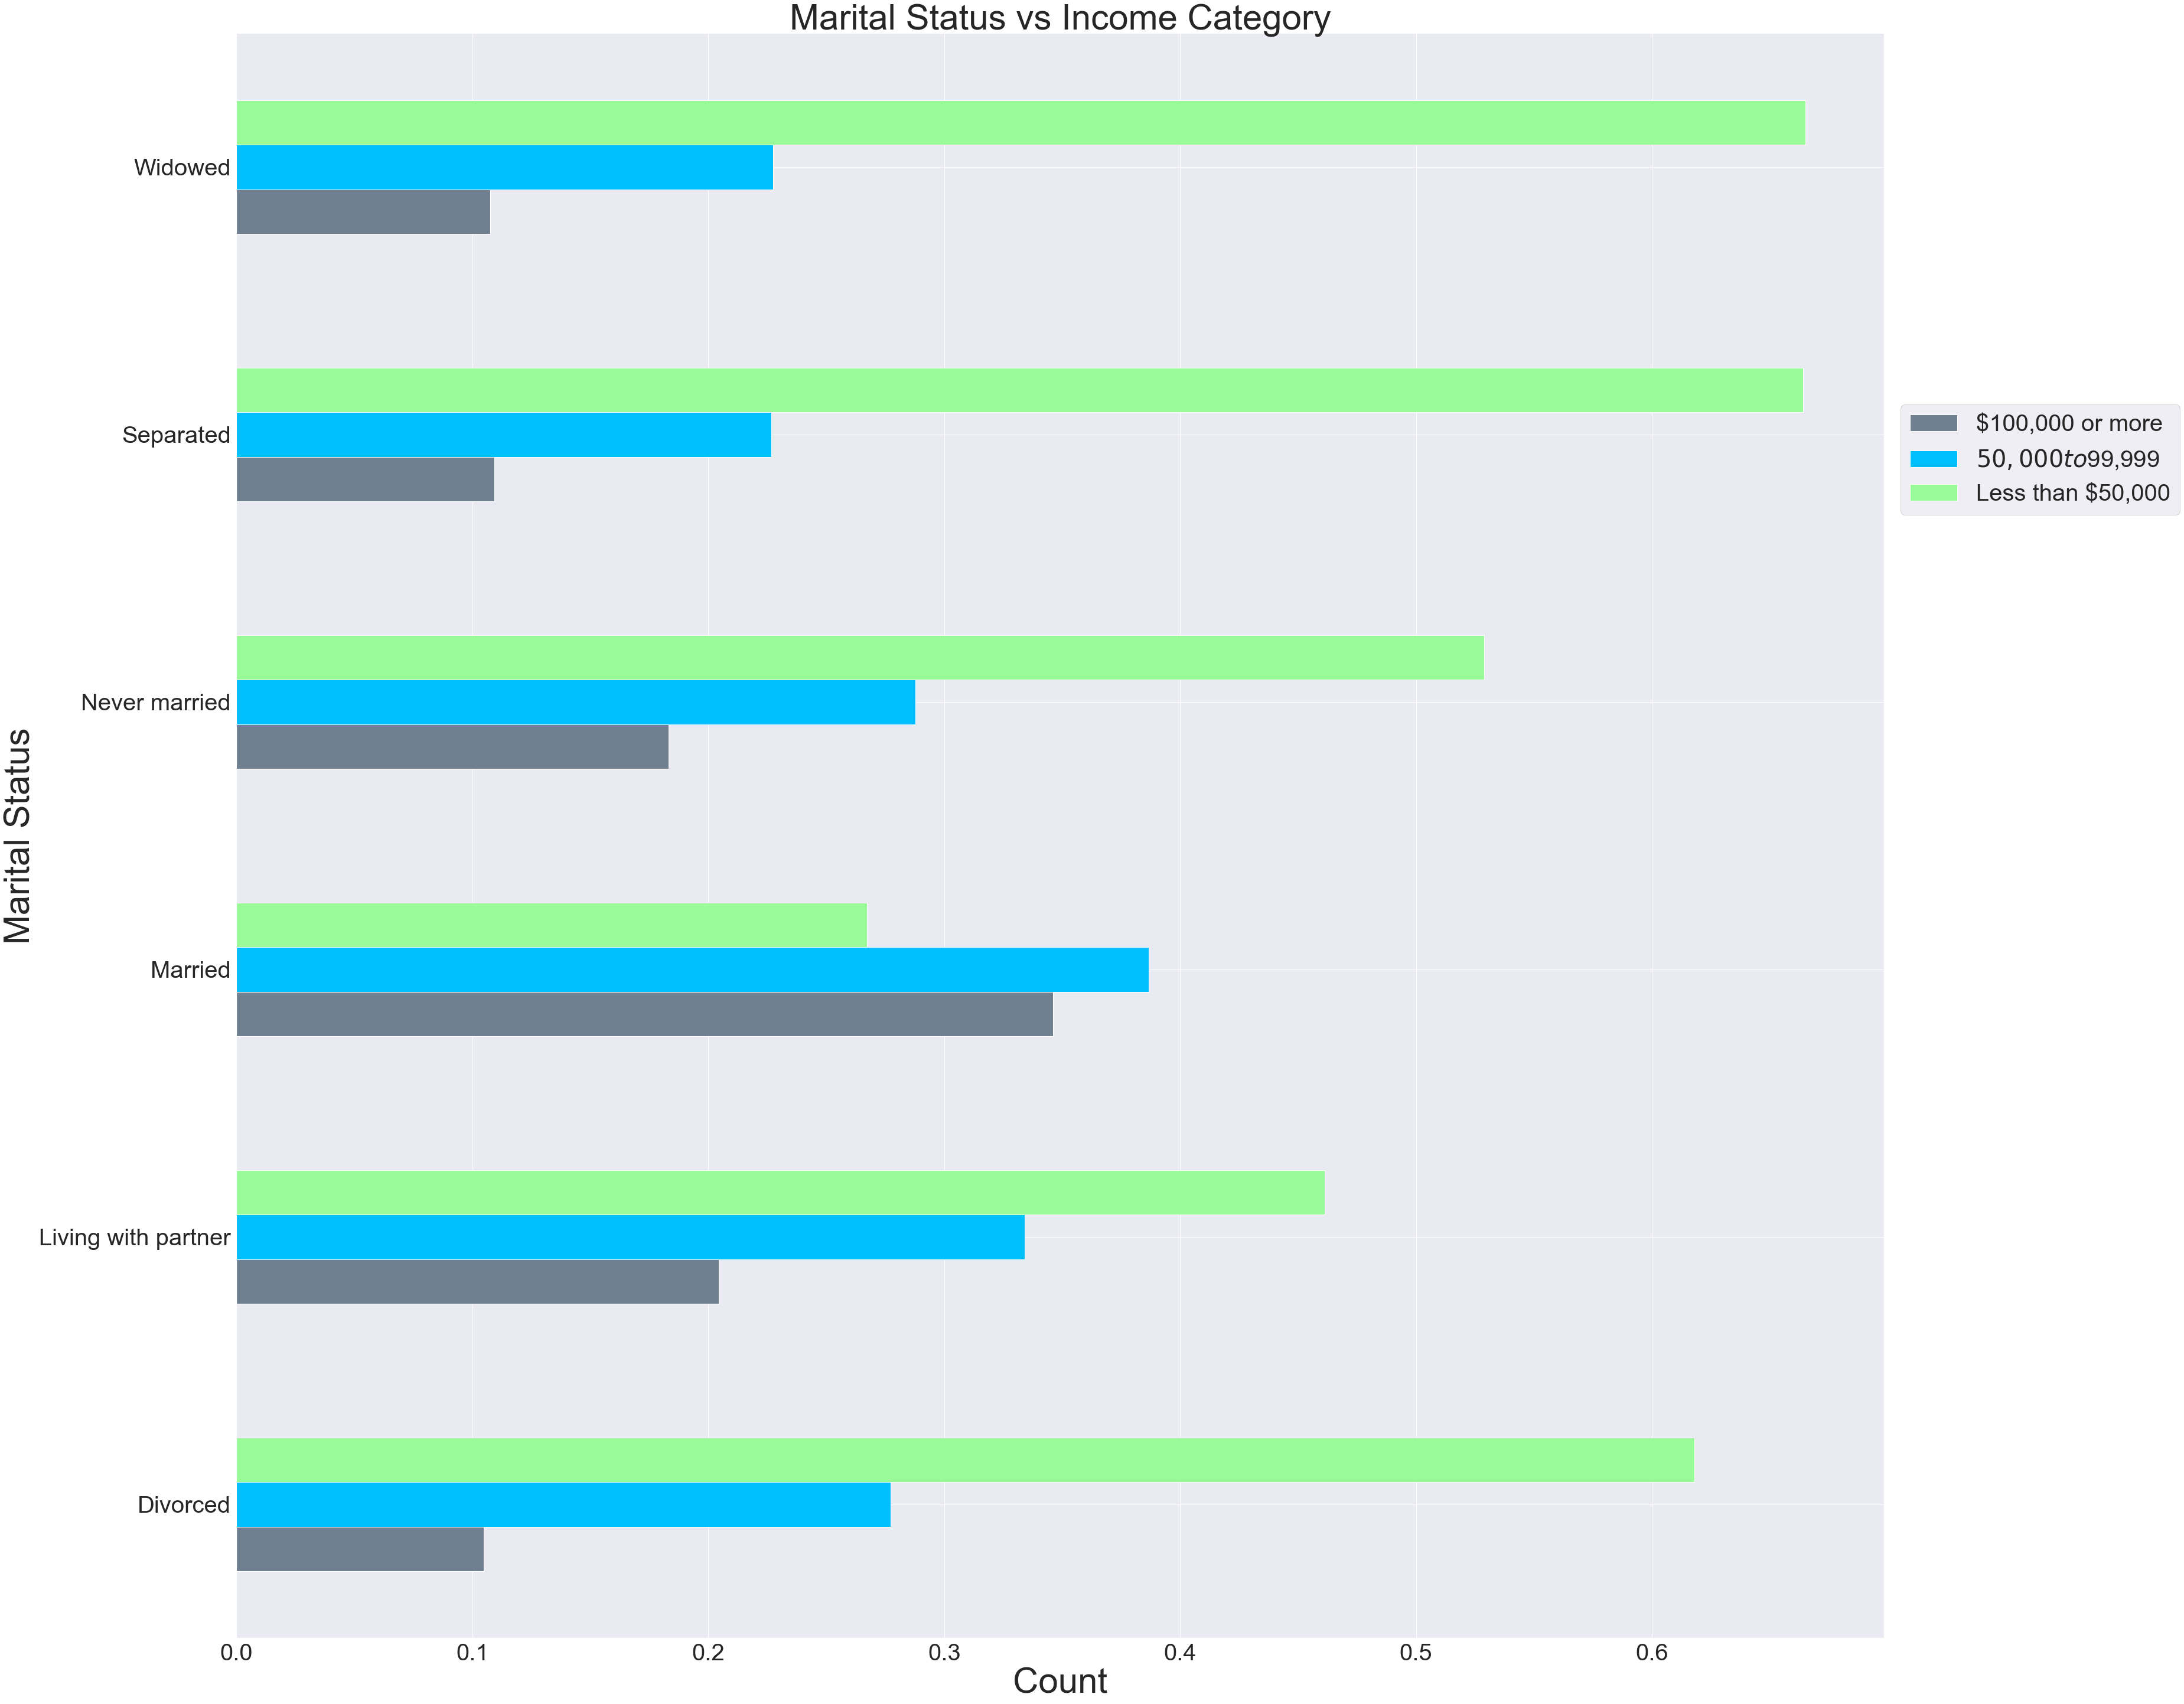

In [215]:
ax = df.groupby(['marit_status'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **Low Income category has most people lying in it except for the Married group where Middle Income is predominant**
- **Married people are likely to have more income than the rest**


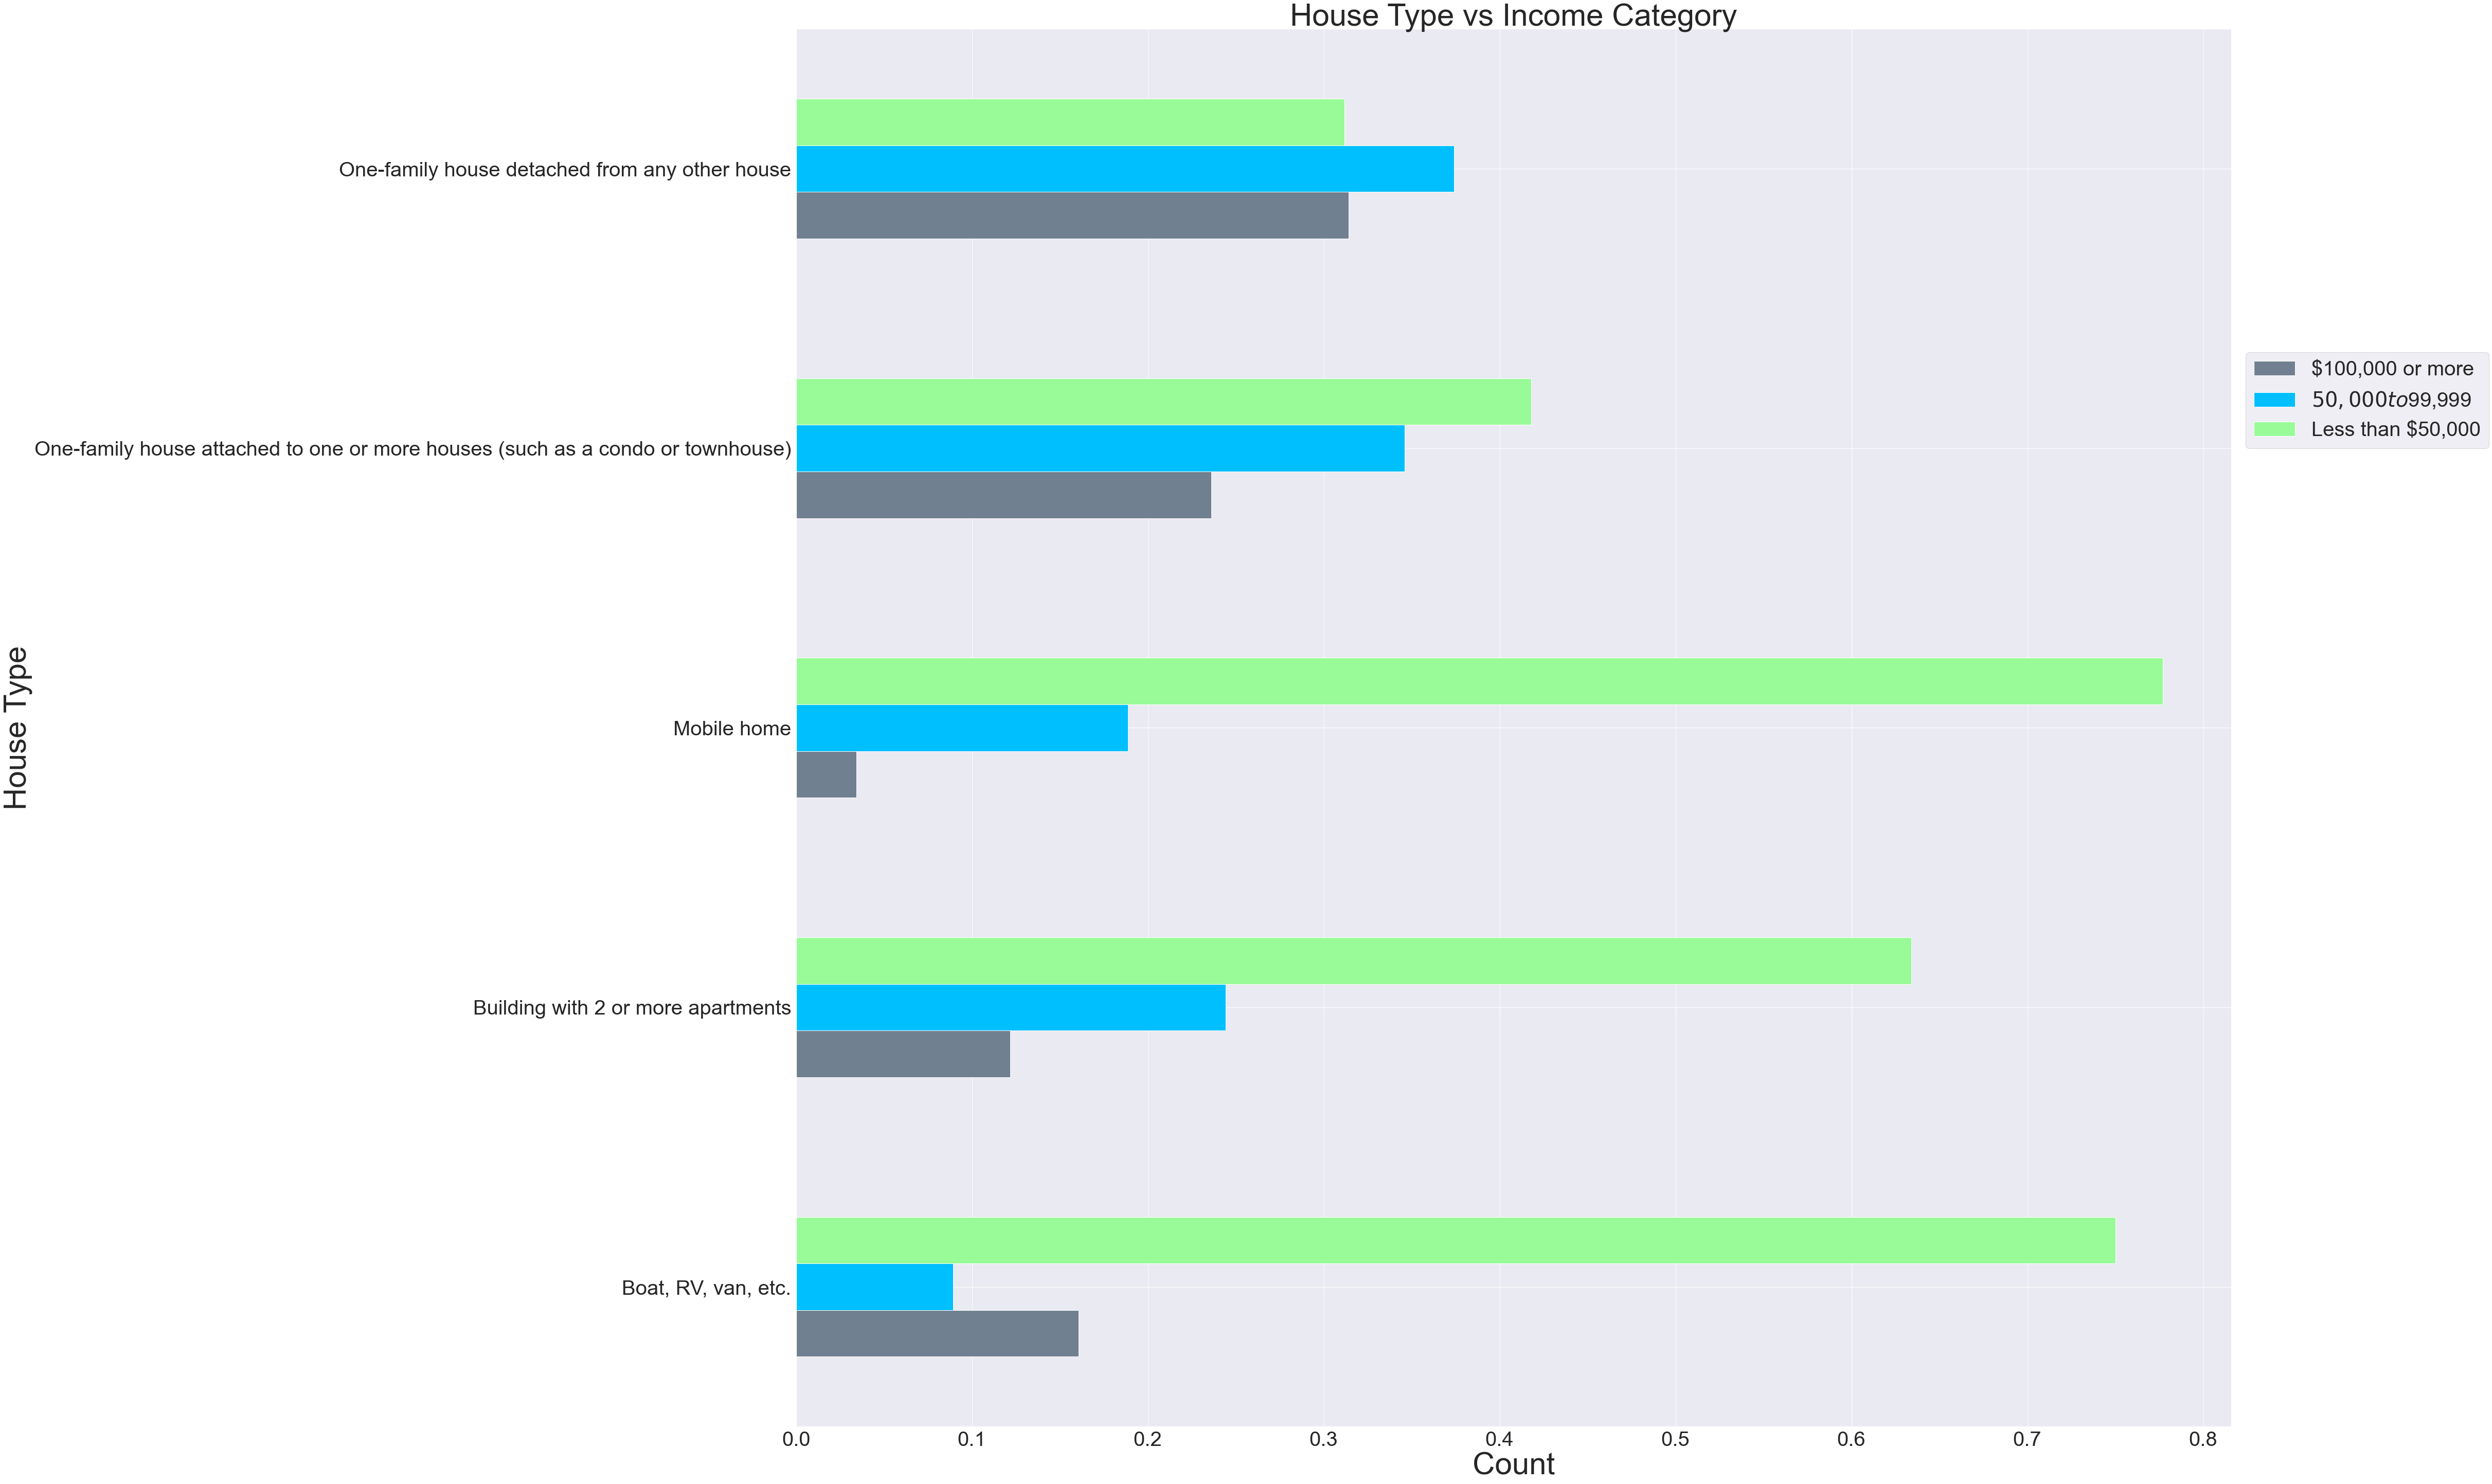

In [216]:
ax = df.groupby(['house_type'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

**- Middle income people are more likely to own a One-Family house**

In [217]:
my_columns=['religion','religion_other_nonchristian', 'evangelical', 'service_attendance',
       'marit_status', 'employment', 'house_head', 'house_size',
       'house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus', 'house_type', 'house_own']

In [218]:
df[my_columns].dtypes

religion                        object
religion_other_nonchristian     object
evangelical                     object
service_attendance               int64
marit_status                    object
employment                      object
house_head                      object
house_size                     float64
house_ages0to1                 float64
house_ages2to5                 float64
house_ages6to12                float64
house_ages13to17               float64
house_ages18plus               float64
house_type                      object
house_own                       object
dtype: object

In [219]:
df['service_attendance']=df['service_attendance'].astype(np.int64)
df['house_size']=df['house_size'].astype(np.int64)
df['house_ages0to1']=df['house_ages0to1'].astype(np.int64)
df['house_ages2to5']=df['house_ages2to5'].astype(np.int64)
df['house_ages6to12']=df['house_ages6to12'].astype(np.int64)
df['house_ages13to17']=df['house_ages13to17'].astype(np.int64)
df['house_ages18plus']=df['house_ages18plus'].astype(np.int64)

In [220]:
df[my_columns].corr()

service_attendance  house_size  house_ages0to1  \
service_attendance            1.000000    0.075543        0.018848   
house_size                    0.075543    1.000000        0.246650   
house_ages0to1                0.018848    0.246650        1.000000   
house_ages2to5                0.030745    0.413113        0.194386   
house_ages6to12               0.065009    0.558449        0.061373   
house_ages13to17              0.061403    0.509398       -0.014844   
house_ages18plus              0.030270    0.734844        0.035700   

                    house_ages2to5  house_ages6to12  house_ages13to17  \
service_attendance        0.030745         0.065009          0.061403   
house_size                0.413113         0.558449          0.509398   
house_ages0to1            0.194386         0.061373         -0.014844   
house_ages2to5            1.000000         0.235270          0.020827   
house_ages6to12           0.235270         1.000000          0.212531   
house_ages13to17          0.020827         0.212531          1.000000   
house_ages18plus          0.056111         0.062175          0.135971   

                    house_ages18plus  
service_attendance          0.030270  
house_size                  0.734844  
house_ages0to1              0.035700  
house_ages2to5              0.056111  
house_ages6to12             0.062175  
house_ages13to17            0.135971  
house_ages18plus            1.000000

In [221]:
df[my_columns].describe()

service_attendance    house_size  house_ages0to1  house_ages2to5  \
count        22345.000000  22345.000000    22345.000000    22345.000000   
mean             3.089192      2.673171        0.042560        0.106556   
std              1.797545      1.476334        0.231409        0.369782   
min             -1.000000      1.000000        0.000000        0.000000   
25%              1.000000      2.000000        0.000000        0.000000   
50%              3.000000      2.000000        0.000000        0.000000   
75%              5.000000      4.000000        0.000000        0.000000   
max              6.000000     15.000000        7.000000        4.000000   

       house_ages6to12  house_ages13to17  house_ages18plus  
count     22345.000000      22345.000000      22345.000000  
mean          0.203983          0.188588          2.131484  
std           0.557805          0.499610          0.953251  
min           0.000000          0.000000          1.000000  
25%           0.000000          0.000000          2.000000  
50%           0.000000          0.000000          2.000000  
75%           0.000000          0.000000          2.000000  
max           6.000000          4.000000         12.000000

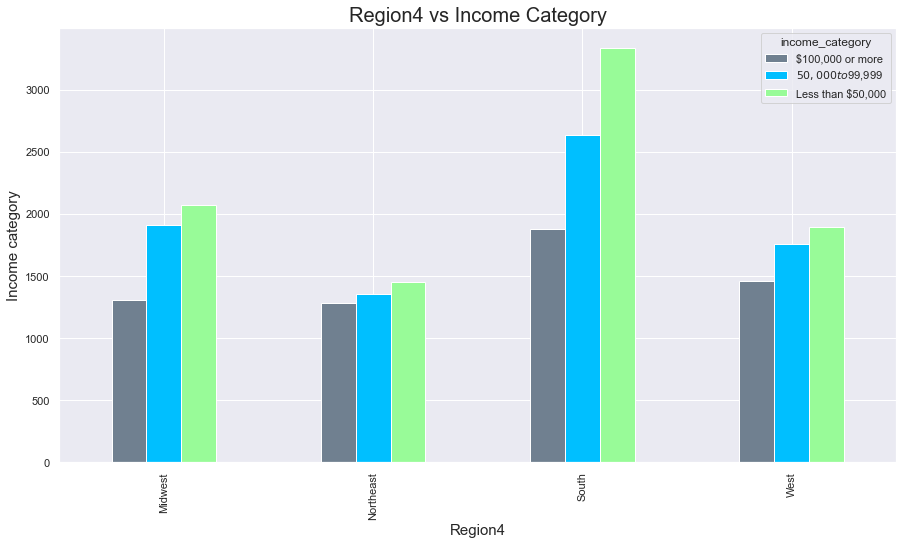

In [222]:
ax= pd.crosstab(index=df['region4'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Region4',fontsize=15)
ax.set_ylabel('Income category',fontsize=15)
ax.set_title('Region4 vs Income Category',fontsize=20);

- **Low income category is predominant**
- **High income is less represented across regions**

In [223]:
# ax= pd.crosstab(index=df['region9'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
# ax.set_xlabel('Region9',fontsize=15)
# ax.set_ylabel('Income category',fontsize=15)
# ax.set_title('Region9 vs Income Category',fontsize=20);

KeyError: 'region9'

- **Low Income is predominant across regions except New England and West-North Central**
- **High income is predominant in New England**
- **Stark  inequality in East South Central region**
- **Pacific region has almost uniform distribution of low, medium and high income categories**

In [224]:
df[['house_size','house_ages18plus']].corr()

house_size  house_ages18plus
house_size          1.000000          0.734844
house_ages18plus    0.734844          1.000000

- **Very high correlation between house_size and house_ages18plus might drop one of them**
- **Keep `children` as defined below and either of `house_size` or `house_ages18plus`and leave out `house_ages0to1`, `house_ages2to5`, `house_ages6to12`, `house_ages13to17`**

In [225]:
df[['house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus','house_size']]

house_ages0to1  house_ages2to5  house_ages6to12  house_ages13to17  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   
...               ...             ...              ...               ...   
22411               0               0                0                 0   
22412               0               1                3                 0   
22413               0               0                0                 0   
22414               0               1                0                 0   
22415               1               0                0                 0   

       house_ages18plus  house_size  
0                     3           3  
1                     2           2  
2                     2           2  
3                     2           2  
4                     2           2  
...                 ...         ...  
22411                 2           2  
22412                 4           8  
22413                 2           2  
22414                 4           5  
22415                 2           3  

[22345 rows x 6 columns]

In [226]:
df['children'] =df['house_ages0to1']+df['house_ages2to5']+df['house_ages6to12']+df['house_ages13to17']

In [227]:
df['children'].describe()

count    22345.000000
mean         0.541687
std          1.009918
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: children, dtype: float64

- **All good with `children` column**

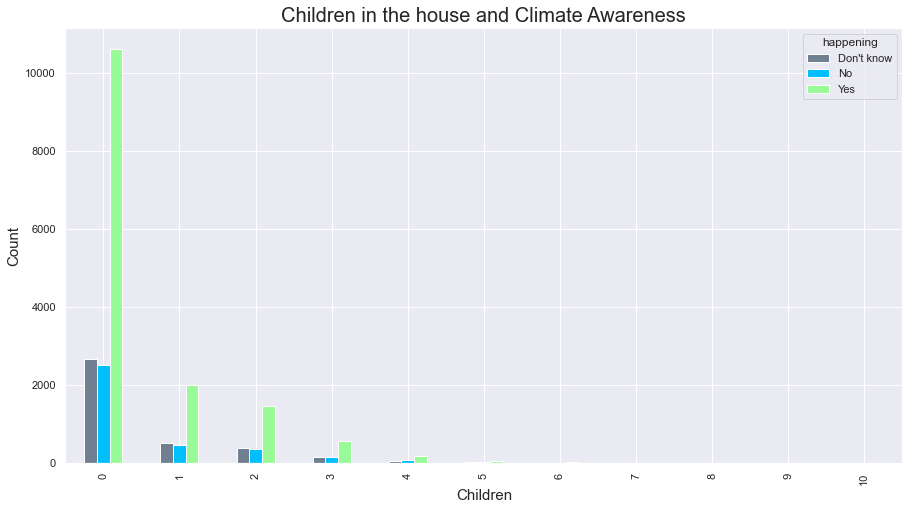

In [228]:
ax= pd.crosstab(index=df['children'],columns=df['happening']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Children', fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.set_title('Children in the house and Climate Awareness', fontsize=20);

- **Seems like having more children reduces the climate awareness or that people with more climate awareness are having less children**
- **I was expecting a reverse relationship too that people having children would want to leave a better world for their children so would be more aware, I don't know the exact relationship**

In [229]:
columns_to_keep=['religion', 'service_attendance','marit_status', 'employment', 'house_head',
                 'house_size',  'house_ages18plus','children', 'house_type', 'house_own']

**These are the columns I would like to keep after EDA*

In [230]:
df.to_csv('../data/survey_data_before_pre_processing.csv', index=False)